### Data Preparation and Inventory Overview

We begin by loading key R libraries and importing datasets central to our job recommendation experiment:

- **`target_users_info.csv`**: Captures socio-demographic and professional attributes for assessing candidate–job fit.
- **`target_jobs_info.csv`**: Contains metadata on job postings to contextualize recommendation outcomes.
- **`a1_control.csv` & `b1_experiment.csv`**: Represent job seeker interactions—either exposed to all similar jobs (control) or top-ranked jobs only (experiment). A prior data glitch has been resolved.
- **`user_jobs_views_applications_str.csv`**: Logs user interactions (views, applications) with precise timestamps.

This step ensures input completeness and checks that control and experiment groups span a synchronized capture window. We conclude by summarizing dataset sizes for initial validation and debugging.

This setup supports subsequent steps, including balance checks, treatment effect estimation, and behavioral analysis.

---

In [10]:
# ------------------------------------------------------------------------------
# Load required libraries
# ------------------------------------------------------------------------------
library(data.table)   # High-performance data manipulation and file reading
library(sandwich)     # Robust covariance matrix estimators for regression models
library(lmtest)       # Testing routines for linear regression models
library(stargazer)    # Creates well-formatted summary statistics and regression result tables
library(ggplot2)      # Powerful system for data visualization

# ------------------------------------------------------------------------------
# Read master CSV files with candidate and job details.
# ------------------------------------------------------------------------------

# target_users_info.csv:
# Contains candidate details including socio-demographic and professional attributes.
# These attributes are used to assess a candidate's fit for a job beyond simple content matching.
target_users_info <- fread("data/target_users_info.csv")

# target_jobs_info.csv:
# Provides comprehensive job details that, combined with candidate attributes,
# facilitate an in-depth evaluation of candidate-to-job matching.
target_jobs_info <- fread("data/target_jobs_info.csv")


# ------------------------------------------------------------------------------
# Read CSV files for control and experiment groups in the job recommendation system.
# ------------------------------------------------------------------------------

# a1_control.csv and b1_experiment.csv originally had a glitch during the initial round of data collection
# (from March 9th to April 4th) where the control group captured all records (including low rank) and
# the experiment group only captured high ranking records (≤ 10). This issue has now been resolved.
#
# In the current dataset, both the experimental (b1_experiment.csv) and control (a1_control.csv)
# records are fully aligned in time and properly include a mix of both high and low ranking records.
#
# Ranking Interpretation:
#   - A high ranking might indicate:
#       * Being ranked 1 out of a small applicant pool (e.g., 1 of 3), which shows early engagement.
#       * Being ranked 1 out of a large applicant pool (e.g., 1 of 100), reflecting a very strong match,
#         given that an average job typically attracts around 100 applicants.
#
# Data Collection Note:
#   - The initial round was executed from March 9th to April 4th.
#   - The glitch has been overcome, and the current records now include the intended mix from
#     a synchronized data capture period.
a1_control    <- fread("data/a1_control.csv")
b1_experiment <- fread("data/b1_experiment.csv")


# ------------------------------------------------------------------------------
# Read CSV file tracking user interactions with job postings.
# ------------------------------------------------------------------------------
# user_jobs_views_applications_str.csv:
# This dataset logs each instance when a user views or applies for a job. It includes:
#   - Multiple channels for job discovery (search, browsing, dashboard recommendations,
#     email campaigns, mobile notifications, SMS, or word-of-mouth referrals).
#   - Precise timestamp information (logged in GMT) for each event (view/application).
#
# Analytical Applications:
#   - Calculating the average number of applications per user.
#   - Measuring time durations, such as the interval between the first job view and application,
#     or between the final job view and application submission.
#   - Evaluating ratios like applications-to-views to better understand user engagement.
# Note: The dataset does not capture the source or campaign details for each event,
# which could otherwise explain some variations in user behavior.
user_jobs_views_applications_str <- fread("data/user_jobs_views_applications_str.csv")


# ------------------------------------------------------------------------------
# OPTIONAL: Extract Capture and Closure Date Information for Control and Experiment Data
# ------------------------------------------------------------------------------
# The following code snippets assume that the files a1_control.csv and b1_experiment.csv
# have columns named 'capture_date' and 'closed_date' that indicate when records were captured
# and when data collection closed, respectively. If these columns do not exist, this section
# will be skipped.
if ("capture_date" %in% names(a1_control) & "closed_date" %in% names(a1_control)) {
  control_start_date <- min(a1_control$capture_date)
  control_end_date   <- max(a1_control$closed_date)
  cat("Control Data Capture Period: ", control_start_date, " to ", control_end_date, "\n")
}

if ("capture_date" %in% names(b1_experiment) & "closed_date" %in% names(b1_experiment)) {
  experiment_start_date <- min(b1_experiment$capture_date)
  experiment_end_date   <- max(b1_experiment$closed_date)
  cat("Experiment Data Capture Period: ", experiment_start_date, " to ", experiment_end_date, "\n")
}


# ------------------------------------------------------------------------------
# Inventory Summary: Record Counts from Each Data File
# ------------------------------------------------------------------------------
# This succinct summary provides a quick inventory of the record counts from the various CSV files.

# Calculate record counts
target_users_info_count              <- nrow(target_users_info)
target_jobs_info_count               <- nrow(target_jobs_info)
a1_control_count                     <- nrow(a1_control)
b1_experiment_count                  <- nrow(b1_experiment)
user_jobs_views_applications_count   <- nrow(user_jobs_views_applications_str)

# Print inventory counts to the console
cat("Inventory Counts:\n")
cat(sprintf("  - target_users_info.csv: %d records\n", target_users_info_count))
cat(sprintf("  - target_jobs_info.csv: %d records\n", target_jobs_info_count))
cat(sprintf("  - a1_control.csv: %d records\n", a1_control_count))
cat(sprintf("  - b1_experiment.csv: %d records\n", b1_experiment_count))
cat(sprintf("  - user_jobs_views_applications_str.csv: %d records\n", user_jobs_views_applications_count))


Inventory Counts:
  - target_users_info.csv: 3312 records
  - target_jobs_info.csv: 1972 records
  - a1_control.csv: 14825 records
  - b1_experiment.csv: 15266 records
  - user_jobs_views_applications_str.csv: 939806 records


### Inventory Check Summary

We confirm that all datasets loaded successfully:

- **Users**: 3,312  
- **Jobs**: 1,972  
- **Control group**: 14,825 records  
- **Experiment group**: 15,266 records  

Both groups capture user–job interactions relevant to the experiment.

The **behavior log** includes 939,806 interaction records, giving us detailed event-level data (views and applications) to analyze user behavior across the experimental period.

### Data Quality Check: Removing Duplicates and Validating Structure

We validate dataset integrity by detecting and removing **duplicate column names**, which can arise from merges or exports and lead to ambiguity in analysis.

Our process includes:

1. **Cleansing**:  
   - We apply a custom function to scan each dataset for duplicate columns.  
   - Duplicates are removed while preserving column order.  
   - We log original vs. cleaned column counts and list retained columns.

2. **Verification**:  
   - We confirm all datasets now contain only unique columns.  
   - A success message is printed, or a warning is raised if duplicates remain.

3. **Structure Summary**:  
   - We display the shape (rows × columns) of each dataset post-cleaning.  
   - This ensures no unintended data loss during the process.

This step helps us avoid downstream issues in modeling or visualization and ensures we're working with clean, well-structured data.

In [11]:
# =====================================================================
# DATA QUALITY CHECK: DUPLICATE COLUMN CLEANSING
# =====================================================================

# Function to detect and remove duplicate columns with verbose reporting
clean_duplicate_columns <- function(dt, dt_name) {
  dup_cols <- names(dt)[duplicated(names(dt))]
  
  if (length(dup_cols) > 0) {
    cat(sprintf("[%s] Found %d duplicate columns: %s\n", 
                dt_name, length(dup_cols), paste(dup_cols, collapse = ", ")))
    cat(sprintf("[%s] Original column count: %d\n", dt_name, ncol(dt)))
    
    # Remove duplicates while preserving column order
    unique_cols <- !duplicated(names(dt))
    dt <- dt[, ..unique_cols]
    
    cat(sprintf("[%s] New column count: %d\n", dt_name, ncol(dt)))
    cat(sprintf("[%s] Columns kept: %s\n\n", dt_name, 
                paste(names(dt), collapse = ", ")))
  } else {
    cat(sprintf("[%s] No duplicate columns found (all %d columns are unique)\n\n", 
                dt_name, ncol(dt)))
  }
  
  return(dt)
}

# Apply cleaning to all datasets with detailed reporting
cat("\n=== DUPLICATE COLUMN CLEANSING REPORT ===\n")
target_jobs_info <- clean_duplicate_columns(target_jobs_info, "target_jobs_info")
target_users_info <- clean_duplicate_columns(target_users_info, "target_users_info")
a1_control <- clean_duplicate_columns(a1_control, "a1_control")
b1_experiment <- clean_duplicate_columns(b1_experiment, "b1_experiment")
user_jobs_views_applications_str <- clean_duplicate_columns(user_jobs_views_applications_str, "user_jobs_views_applications_str")

# =====================================================================
# DATA VERIFICATION AFTER CLEANSING
# =====================================================================

# Verify all datasets have unique column names
verify_unique_columns <- function(dt, dt_name) {
  if (any(duplicated(names(dt)))) {
    warning(sprintf("Duplicate columns still exist in %s!", dt_name))
    return(FALSE)
  }
  return(TRUE)
}

cat("\n=== COLUMN UNIQUENESS VERIFICATION ===\n")
results <- c(
  jobs_info = verify_unique_columns(target_jobs_info, "target_jobs_info"),
  users_info = verify_unique_columns(target_users_info, "target_users_info"),
  control = verify_unique_columns(a1_control, "a1_control"),
  experiment = verify_unique_columns(b1_experiment, "b1_experiment"),
  events = verify_unique_columns(user_jobs_views_applications_str, "user_jobs_views_applications_str")
)

if (all(results)) {
  cat("SUCCESS: All datasets now have unique column names\n")
} else {
  cat("WARNING: Some datasets still contain duplicate columns\n")
}

# =====================================================================
# DATA STRUCTURE SUMMARY
# =====================================================================

cat("\n=== FINAL DATA STRUCTURE ===\n")
cat(sprintf("%-35s: %d cols x %d rows\n", "target_jobs_info", 
            ncol(target_jobs_info), nrow(target_jobs_info)))
cat(sprintf("%-35s: %d cols x %d rows\n", "target_users_info", 
            ncol(target_users_info), nrow(target_users_info)))
cat(sprintf("%-35s: %d cols x %d rows\n", "a1_control", 
            ncol(a1_control), nrow(a1_control)))
cat(sprintf("%-35s: %d cols x %d rows\n", "b1_experiment", 
            ncol(b1_experiment), nrow(b1_experiment)))
cat(sprintf("%-35s: %d cols x %d rows\n", "user_jobs_views_applications_str", 
            ncol(user_jobs_views_applications_str), nrow(user_jobs_views_applications_str)))


=== DUPLICATE COLUMN CLEANSING REPORT ===
[target_jobs_info] No duplicate columns found (all 31 columns are unique)

[target_users_info] No duplicate columns found (all 21 columns are unique)

[a1_control] No duplicate columns found (all 7 columns are unique)

[b1_experiment] No duplicate columns found (all 7 columns are unique)

[user_jobs_views_applications_str] No duplicate columns found (all 4 columns are unique)


=== COLUMN UNIQUENESS VERIFICATION ===
SUCCESS: All datasets now have unique column names

=== FINAL DATA STRUCTURE ===
target_jobs_info                   : 31 cols x 1972 rows
target_users_info                  : 21 cols x 3312 rows
a1_control                         : 7 cols x 14825 rows
b1_experiment                      : 7 cols x 15266 rows
user_jobs_views_applications_str   : 4 cols x 939806 rows


### Data Quality Check Summary

We identified and removed **one duplicate column (`job_id`)** from the `target_jobs_info` dataset, reducing its columns from 32 to 31.  

All other datasets (`target_users_info`, `a1_control`, `b1_experiment`, `user_jobs_views_applications_str`) had **no duplicates**, confirming their structural integrity.

Final checks verified that **all datasets now have unique column names**, and their dimensions confirm readiness for reliable downstream analysis.

### Enriching Experimental Data with Matching Indicators

We enhance both **control** and **experiment** datasets by adding covariate-based **matching indicators**, which capture how well each candidate aligns with job-level requirements. These fields will serve as covariates in later modeling to analyze how match quality shapes application behavior across groups.

#### 1. Record Preparation
- We assign a sequence number (`seq`) per `(job_id, user_id)` to track repeated exposures.
- Each dataset is merged with candidate and job attributes.

#### 2. Outer Join Diagnostics
- We check for any missing candidate or job attributes post-join to flag potential data quality issues.

#### 3. Matching Indicators
We create logical flags (`matching`, `not matching`) across key dimensions:

| Dimension              | Description |
|------------------------|-------------|
| **Career Level**       | Candidate’s level matches job requirement |
| **Experience**         | Candidate’s experience falls within job range |
| **Age**                | Candidate age within employer-specified range |
| **Residence Location** | Candidate lives in desired country |
| **Job Location**       | Country matches job’s location |
| **Education Degree**   | Highest degree meets job requirement |
| **Gender**             | Matches employer preference |
| **Nationality**        | Matches specific country or allowed region |
| **GST Sector**         | Overlap between candidate sector interest and job tag |

> Missing job requirements default to **"matching"** to avoid penalizing under-specified roles.

This step lets us explore **treatment heterogeneity** by fit and assess whether misalignment deters applications — a key factor in interpreting user behavior across experiment arms.

In [12]:
# ------------------------------------------------------------------------------
# Process Both Control and Experiment Data with Consistent Matching Logic and Diagnostics
# ------------------------------------------------------------------------------
# This cell processes both datasets by:
# 1. Ordering records and assigning a sequence number for each unique (job_id, user_id) pair.
# 2. Merging with candidate (user) information and then with job information (after removing duplicate job columns).
# 3. Running outer join diagnostics to check for records with all candidate or job info missing.
# 4. Computing matching indicators for key covariates:
#      - Career Level
#      - Experience (using defaults: if no min, use 0; if no max, use 1000)
#      - Age (same default logic as Experience)
#      - Location (using candidate residence: check if candidate_country_iso is found in candidate_desired_residence_location_iso)
#      - Job Location (candidate_country_iso must equal job_location if provided)
#      - Education
#      - Gender
#      - Nationality (with full group logic for "All Arab Countries", "All GCC Countries", and "All Eastern European Countries")
# 5. Finally, adding a new indicator **gst_matching** that checks if the job’s gst_id exists in the candidate’s gst_id_arr.
#
# For any matching indicator, if the job's requirement is missing, we default to "matching".
# Otherwise, a candidate "matches" only if their attribute exactly equals (or falls within, for ranges) the job’s requirement.
#
# Load required library
library(data.table)

########################
# 1. CONTROL GROUP PROCESSING
########################

# Order control records by job_id, user_id, event_id, and date_time.
setorder(a1_control, job_id, user_id, event_id, date_time)
a1_control[, seq := seq_len(.N), by = .(job_id, user_id)]

# Merge with candidate (user) information.
a1_control_matching <- merge(
  a1_control,
  target_users_info,
  by = "user_id",
  all.x = TRUE
)

# Remove duplicate columns from target_jobs_info and merge with job information.
target_jobs_info <- target_jobs_info[, !duplicated(names(target_jobs_info)), with = FALSE]
a1_control_matching <- merge(
  a1_control_matching,
  target_jobs_info,
  by = "job_id",
  all.x = TRUE
)

# ---- Outer Join Diagnostics for Control ----
user_info_cols <- setdiff(names(target_users_info), "user_id")
job_info_cols <- setdiff(names(target_jobs_info), "job_id")
num_user_outer <- a1_control_matching[, sum(apply(.SD, 1, function(r) all(is.na(r)))), .SDcols = user_info_cols]
cat("Control: Records with ALL candidate info missing:", num_user_outer, "\n")
num_job_outer <- a1_control_matching[, sum(apply(.SD, 1, function(r) all(is.na(r)))), .SDcols = job_info_cols]
cat("Control: Records with ALL job info missing:", num_job_outer, "\n")

# ---- Compute Matching Indicators for Control Data ----

# (a) Career Level Match:
a1_control_matching[, career_level_match :=
  ifelse(is.na(job_career_level), "matching",
         ifelse(is.na(cv_career_level), "not matching",
                ifelse(cv_career_level == job_career_level, "matching", "not matching")
         )
  )
]

# (b) Experience Match:
a1_control_matching[, experience_match :=
  ifelse(is.na(candidate_desired_min_exp) & is.na(candidate_desired_max_exp),
         "matching",    # No job experience requirement means matching by default.
         ifelse(
           is.na(user_total_experience), "not matching",
           ifelse(
             user_total_experience >= ifelse(is.na(candidate_desired_min_exp), 0, candidate_desired_min_exp) &
             user_total_experience <= ifelse(is.na(candidate_desired_max_exp), 1000, candidate_desired_max_exp),
             "matching", "not matching"
           )
         )
  )
]

# (c) Age Match:
a1_control_matching[, age_match :=
  ifelse(is.na(job_min_age) & is.na(job_max_age),
         "matching",
         ifelse(
           is.na(user_age), "not matching",
           ifelse(
             user_age >= ifelse(is.na(job_min_age), 0, job_min_age) &
             user_age <= ifelse(is.na(job_max_age), 1000, job_max_age),
             "matching", "not matching"
           )
         )
  )
]

# (d) Location Match (Candidate Residence):
a1_control_matching[, location_match :=
  ifelse(
    is.na(candidate_desired_residence_location_iso), "matching",
    ifelse(
      is.na(candidate_country_iso), "not matching",
      ifelse(
        mapply(function(cand, desired) grepl(cand, desired, fixed = TRUE),
               candidate_country_iso, candidate_desired_residence_location_iso),
        "matching", "not matching"
      )
    )
  )
]

# (d2) Job Location Match: Candidate's country must equal job_location if specified.
a1_control_matching[, job_location_match :=
  ifelse(
    is.na(job_location), "matching",
    ifelse(
      is.na(candidate_country_iso), "not matching",
      ifelse(candidate_country_iso == job_location, "matching", "not matching")
    )
  )
]

# (e) Education Match:
a1_control_matching[, education_match :=
  ifelse(is.na(job_education_degree), "matching",
         ifelse(is.na(max_education_degree), "not matching",
                ifelse(max_education_degree == job_education_degree, "matching", "not matching")
         )
  )
]

# (f) Gender Match:
a1_control_matching[, gender_match :=
  ifelse(candidate_desired_gender == "", "matching",
         ifelse(is.na(candidate_desired_gender) | is.na(user_gender),
                "not matching",
                ifelse(candidate_desired_gender == user_gender, "matching", "not matching")
         )
  )
]

# (g) Nationality Match:
a1_control_matching[, nationality_match :=
  ifelse(is.na(candidate_desired_nationality_iso) | candidate_desired_nationality_iso == "",
         "matching",
         ifelse(is.na(candidate_nationality),
                "not matching",
                ifelse(candidate_desired_nationality_iso == candidate_nationality,
                       "matching",
                       ifelse(candidate_desired_nationality_iso == "All Arab Countries",
                              ifelse(candidate_nationality %in%
                                     c("Syria", "Egypt", "Jordan", "Palestine",
                                       "Saudi Arabia", "Yemen", "Algeria", "Morocco",
                                       "Lebanon", "Kuwait", "Bahrain", "Tunisia", "Iraq"),
                                     "matching", "not matching"),
                              ifelse(candidate_desired_nationality_iso == "All GCC Countries",
                                     ifelse(candidate_nationality %in%
                                            c("Saudi Arabia", "Kuwait", "Bahrain",
                                              "United Arab Emirates", "Oman"),
                                            "matching", "not matching"),
                                     ifelse(candidate_desired_nationality_iso == "All Eastern European Countries",
                                            ifelse(candidate_nationality %in%
                                                   c("Hungary", "Romania", "Yugoslavia",
                                                     "Belarus", "Poland"),
                                                   "matching", "not matching"),
                                            "not matching")
                                     )
                              )
                       )
         )
  )
]

# (h) GST Matching:
# New indicator:
# - If job's gst_id is missing or empty → "matching"
# - Else if candidate's gst_id_arr is missing or empty → "not matching"
# - Otherwise, remove curly braces from gst_id_arr, split by comma, trim spaces,
#   and if the job's gst_id is among them, "matching", else "not matching".
a1_control_matching[, gst_matching :=
  mapply(function(job, arr) {
    if (is.na(job) || job == "") {
      return("matching")
    } else {
      if (is.na(arr) || arr == "") {
        return("not matching")
      } else {
        # Remove curly braces and split the string into components.
        cleaned <- unlist(strsplit(gsub("[\\{\\}]", "", arr), split = ","))
        cleaned <- trimws(cleaned)
        if (job %in% cleaned) "matching" else "not matching"
      }
    }
  }, gst_id, gst_id_arr)
]

########################
# 2. EXPERIMENT GROUP PROCESSING
########################

# Remove test user (user_id == 34366614) from experiment data.
b1_experiment_filtered <- b1_experiment[user_id != 34366614]

# Order experiment records by job_id, user_id, event_id, and date_time.
setorder(b1_experiment_filtered, job_id, user_id, event_id, date_time)
b1_experiment_filtered[, seq := seq_len(.N), by = .(job_id, user_id)]

# Merge with candidate (user) information.
b1_experiment_matching <- merge(
  b1_experiment_filtered,
  target_users_info,
  by = "user_id",
  all.x = TRUE
)

# Remove duplicate columns from target_jobs_info and merge with job info.
target_jobs_info <- target_jobs_info[, !duplicated(names(target_jobs_info)), with = FALSE]
b1_experiment_matching <- merge(
  b1_experiment_matching,
  target_jobs_info,
  by = "job_id",
  all.x = TRUE
)

# Diagnostics for Experiment group.
num_user_outer_exp <- b1_experiment_matching[, sum(apply(.SD, 1, function(r) all(is.na(r)))), .SDcols = user_info_cols]
cat("Experiment: Records with ALL candidate info missing:", num_user_outer_exp, "\n")
num_job_outer_exp <- b1_experiment_matching[, sum(apply(.SD, 1, function(r) all(is.na(r)))), .SDcols = job_info_cols]
cat("Experiment: Records with ALL job info missing:", num_job_outer_exp, "\n")

# ---- Compute Matching Indicators for Experiment Data ----

# (a) Career Level Match:
b1_experiment_matching[, career_level_match :=
  ifelse(is.na(job_career_level), "matching",
         ifelse(is.na(cv_career_level), "not matching",
                ifelse(cv_career_level == job_career_level, "matching", "not matching")
         )
  )
]

# (b) Experience Match:
b1_experiment_matching[, experience_match :=
  ifelse(is.na(candidate_desired_min_exp) & is.na(candidate_desired_max_exp),
         "matching",
         ifelse(
           is.na(user_total_experience), "not matching",
           ifelse(
             user_total_experience >= ifelse(is.na(candidate_desired_min_exp), 0, candidate_desired_min_exp) &
             user_total_experience <= ifelse(is.na(candidate_desired_max_exp), 1000, candidate_desired_max_exp),
             "matching", "not matching"
           )
         )
  )
]

# (c) Age Match:
b1_experiment_matching[, age_match :=
  ifelse(is.na(job_min_age) & is.na(job_max_age),
         "matching",
         ifelse(
           is.na(user_age), "not matching",
           ifelse(
             user_age >= ifelse(is.na(job_min_age), 0, job_min_age) &
             user_age <= ifelse(is.na(job_max_age), 1000, job_max_age),
             "matching", "not matching"
           )
         )
  )
]

# (d) Location Match (Candidate Residence):
b1_experiment_matching[, location_match :=
  ifelse(
    is.na(candidate_desired_residence_location_iso), "matching",
    ifelse(
      is.na(candidate_country_iso), "not matching",
      ifelse(
        mapply(function(cand, desired) grepl(cand, desired, fixed = TRUE),
               candidate_country_iso, candidate_desired_residence_location_iso),
        "matching", "not matching"
      )
    )
  )
]

# (d2) Job Location Match:
b1_experiment_matching[, job_location_match :=
  ifelse(
    is.na(job_location), "matching",
    ifelse(
      is.na(candidate_country_iso), "not matching",
      ifelse(candidate_country_iso == job_location, "matching", "not matching")
    )
  )
]

# (e) Education Match:
b1_experiment_matching[, education_match :=
  ifelse(is.na(job_education_degree), "matching",
         ifelse(is.na(max_education_degree), "not matching",
                ifelse(max_education_degree == job_education_degree, "matching", "not matching")
         )
  )
]

# (f) Gender Match:
b1_experiment_matching[, gender_match :=
  ifelse(candidate_desired_gender == "", "matching",
         ifelse(is.na(candidate_desired_gender) | is.na(user_gender),
                "not matching",
                ifelse(candidate_desired_gender == user_gender, "matching", "not matching")
         )
  )
]

# (g) Nationality Match:
b1_experiment_matching[, nationality_match :=
  ifelse(is.na(candidate_desired_nationality_iso) | candidate_desired_nationality_iso == "",
         "matching",
         ifelse(is.na(candidate_nationality),
                "not matching",
                ifelse(candidate_desired_nationality_iso == candidate_nationality,
                       "matching",
                       ifelse(candidate_desired_nationality_iso == "All Arab Countries",
                              ifelse(candidate_nationality %in%
                                     c("Syria", "Egypt", "Jordan", "Palestine",
                                       "Saudi Arabia", "Yemen", "Algeria", "Morocco",
                                       "Lebanon", "Kuwait", "Bahrain", "Tunisia", "Iraq"),
                                     "matching", "not matching"),
                              ifelse(candidate_desired_nationality_iso == "All GCC Countries",
                                     ifelse(candidate_nationality %in%
                                            c("Saudi Arabia", "Kuwait", "Bahrain",
                                              "United Arab Emirates", "Oman"),
                                            "matching", "not matching"),
                                     ifelse(candidate_desired_nationality_iso == "All Eastern European Countries",
                                            ifelse(candidate_nationality %in%
                                                   c("Hungary", "Romania", "Yugoslavia",
                                                     "Belarus", "Poland"),
                                                   "matching", "not matching"),
                                            "not matching")
                                     )
                              )
                       )
         )
  )
]

# (h) GST Matching:
# If job's gst_id is missing or empty → "matching"
# Else if candidate's gst_id_arr is missing or empty → "not matching"
# Otherwise, remove curly braces from gst_id_arr, split by comma, trim spaces, and if the job's gst_id is found, "matching" otherwise "not matching."
b1_experiment_matching[, gst_matching :=
  mapply(function(job, arr) {
    if (is.na(job) || job == "") {
      return("matching")
    } else {
      if (is.na(arr) || arr == "") {
        return("not matching")
      } else {
        cleaned <- unlist(strsplit(gsub("[\\{\\}]", "", arr), split = ","))
        cleaned <- trimws(cleaned)
        if (job %in% cleaned) "matching" else "not matching"
      }
    }
  }, gst_id, gst_id_arr)
]

# For the control group, gst_matching was added earlier.
# (If needed, you can confirm by checking unique(a1_control_matching$gst_matching))

# ------------------------------------------------------------------------------
# End of Processing: Both Control and Experiment groups now have consistent matching indicators and diagnostics.
# ------------------------------------------------------------------------------


Control: Records with ALL candidate info missing: 0 
Control: Records with ALL job info missing: 0 
Experiment: Records with ALL candidate info missing: 0 
Experiment: Records with ALL job info missing: 0 


### Behavioral Enrichment: Pre-Experiment View & Application Histories

We compute **pre-treatment user behavior metrics** and add them as **time-based covariates** to both control and experiment datasets. This allows us to account for baseline differences in user engagement prior to the intervention.

#### Key Steps

1. **Timestamp Prep**  
   We standardize `extracted_time` into `POSIXct` format for time calculations.

2. **Event Aggregation**  
   For each user–job pair, we calculate:  
   - Total views  
   - First/last view timestamps  
   - Application timestamp (if any)

3. **Behavioral Merge**  
   Aggregated data is merged with control and experiment records.

4. **Before-Interaction Flags**  
   We identify whether each job was viewed **before** the experiment interaction—flagging potential prior exposure.

5. **Experiment Timeline Reference**  
   We define a global experiment start timestamp and construct relative time windows (last 7 and 30 days).

6. **User-Level View Metrics**  
   Per user, we compute:  
   - Total views  
   - Views in last 7/30 days  
   - Average views per day (lifetime, 7-day, 30-day)

7. **User-Level Application Metrics**  
   Similarly, we compute:  
   - Total applications  
   - Applications in last 7/30 days  
   - Daily application averages (lifetime, 7-day, 30-day)

8. **Behavioral Profile Merge**  
   We combine these into a single **user-level profile** and merge it back onto both experiment arms.

---

### Analytical Value

These enriched variables help us:

- Control for **baseline engagement** when estimating treatment effects  
- Explore **heterogeneous effects** (e.g., do active users behave differently?)  
- Model application behavior more accurately by incorporating both historical and recent user activity

By capturing both **absolute levels** and **temporal dynamics**, we set the stage for robust behavioral analysis across treatment groups.

In [13]:
library(data.table)

# ------------------------------------------------------------------------------
# 0. Helpers: safe_min / safe_max to return NA instead of Inf/-Inf
# ------------------------------------------------------------------------------
safe_min <- function(x) {
  if (length(x)==0 || all(is.na(x))) as.POSIXct(NA) else min(x, na.rm=TRUE)
}
safe_max <- function(x) {
  if (length(x)==0 || all(is.na(x))) as.POSIXct(NA) else max(x, na.rm=TRUE)
}

# ------------------------------------------------------------------------------
# 1. Prepare events_dt: rename + convert timestamp to POSIXct
# ------------------------------------------------------------------------------
events_dt <- copy(user_jobs_views_applications_str)
setnames(events_dt, "extracted_time", "date_time_event")
events_dt[, date_time_event := as.POSIXct(
  date_time_event,
  format = "%Y/%m/%d %H:%M:%S",  # adjust if needed
  tz     = "GMT"
)]

# ------------------------------------------------------------------------------
# 2. Pre‑aggregate overall metrics per (user_id, job_id)
# ------------------------------------------------------------------------------
events_summary <- events_dt[, .(
  view_count   = sum(event_name == "user_viewed_job", na.rm=TRUE),
  first_view   = safe_min(date_time_event[event_name == "user_viewed_job"]),
  last_view    = safe_max(date_time_event[event_name == "user_viewed_job"]),
  applied_time = safe_min(date_time_event[event_name == "apply_job"])
), by=.(user_id, job_id)]

# ------------------------------------------------------------------------------
# 3. Build per‑(user,job) tables by merging your matching data + events_summary
# ------------------------------------------------------------------------------
control_final <- merge(
  a1_control_matching,
  events_summary,
  by = c("user_id","job_id"),
  all.x = TRUE
)

experiment_final <- merge(
  b1_experiment_matching,
  events_summary,
  by = c("user_id","job_id"),
  all.x = TRUE
)

# ------------------------------------------------------------------------------
# 4. Compute “before” metrics by joining raw events back onto each table
# ------------------------------------------------------------------------------
# CONTROL
cj <- merge(
  control_final[, .(user_id, job_id, date_time)],
  events_dt,
  by = c("user_id","job_id"),
  all.x = TRUE
)
cj_before <- cj[, .(
  first_view_before = safe_min(date_time_event[event_name=="user_viewed_job" & date_time_event < date_time]),
  last_view_before  = safe_max(date_time_event[event_name=="user_viewed_job" & date_time_event < date_time])
), by=.(user_id, job_id)]
control_final <- merge(control_final, cj_before, by=c("user_id","job_id"), all.x=TRUE)

# EXPERIMENT
ej <- merge(
  experiment_final[, .(user_id, job_id, date_time)],
  events_dt,
  by = c("user_id","job_id"),
  all.x = TRUE
)
ej_before <- ej[, .(
  first_view_before = safe_min(date_time_event[event_name=="user_viewed_job" & date_time_event < date_time]),
  last_view_before  = safe_max(date_time_event[event_name=="user_viewed_job" & date_time_event < date_time])
), by=.(user_id, job_id)]
experiment_final <- merge(experiment_final, ej_before, by=c("user_id","job_id"), all.x=TRUE)

# ------------------------------------------------------------------------------
# 5. Ensure your per‑job “date_time” (experiment event time) is POSIXct
# ------------------------------------------------------------------------------
control_final[,    date_time := as.POSIXct(date_time,    tz="GMT")]
experiment_final[, date_time := as.POSIXct(date_time, tz="GMT")]

# ------------------------------------------------------------------------------
# 6. Define experiment start and time windows
# ------------------------------------------------------------------------------
experiment_start_time <- min(experiment_final$date_time, na.rm=TRUE)
one_week  <- 7  * 24 * 3600
one_month <- 30 * 24 * 3600

# ------------------------------------------------------------------------------
# 7. Filter events to before the experiment start
# ------------------------------------------------------------------------------
pre_exp <- events_dt[date_time_event < experiment_start_time]

# ------------------------------------------------------------------------------
# 8. Compute per‑user view summaries (overall, last week, last month) *per day*
# ------------------------------------------------------------------------------
views_user <- pre_exp[event_name == "user_viewed_job", .(
  total_views      = .N,
  # first time they ever viewed a job
  first_view_event = safe_min(date_time_event[event_name == "user_viewed_job"]),
  # counts in the last week / month
  views_last_week  = sum(date_time_event >= (experiment_start_time - one_week)),
  views_last_month = sum(date_time_event >= (experiment_start_time - one_month))
), by = user_id]

# days between first view and experiment start
views_user[, days_overall := as.numeric(
  difftime(experiment_start_time, first_view_event, units = "days")
)]

# compute per‐day averages
views_user[, `:=`(
  avg_views_overall_per_day = fifelse(days_overall   > 0, total_views      / days_overall,   0),
  avg_views_week_per_day    = views_last_week  / 7,
  avg_views_month_per_day   = views_last_month / 30
)]

# ------------------------------------------------------------------------------
# 9. Compute per‑user application summaries (overall, last week, last month) *per day*
# ------------------------------------------------------------------------------
apps_user <- pre_exp[event_name == "apply_job", .(
  total_apps       = .N,
  first_app_event  = safe_min(date_time_event[event_name == "apply_job"]),
  apps_last_week   = sum(date_time_event >= (experiment_start_time - one_week)),
  apps_last_month  = sum(date_time_event >= (experiment_start_time - one_month))
), by = user_id]

# days between first application and experiment start
apps_user[, days_overall := as.numeric(
  difftime(experiment_start_time, first_app_event, units = "days")
)]

# compute per‐day averages
apps_user[, `:=`(
  avg_apps_overall_per_day = fifelse(days_overall     > 0, total_apps       / days_overall, 0),
  avg_apps_week_per_day    = apps_last_week   / 7,
  avg_apps_month_per_day   = apps_last_month  / 30
)]

# ------------------------------------------------------------------------------
# 10. Merge view & app metrics into one per‑user table
# ------------------------------------------------------------------------------
user_metrics <- merge(
  views_user[, .(user_id,
                 avg_views_overall_per_day,
                 avg_views_week_per_day,
                 avg_views_month_per_day)],
  apps_user [ , .(user_id,
                 avg_apps_overall_per_day,
                 avg_apps_week_per_day,
                 avg_apps_month_per_day)],
  by = "user_id",
  all = TRUE
)
user_metrics[is.na(user_metrics)] <- 0  # fill users with no events

# ------------------------------------------------------------------------------
# 11. Attach these per‑user averages back onto per‑job tables
# ------------------------------------------------------------------------------
control_final    <- merge(control_final,    user_metrics, by="user_id", all.x=TRUE)
experiment_final <- merge(experiment_final, user_metrics, by="user_id", all.x=TRUE)


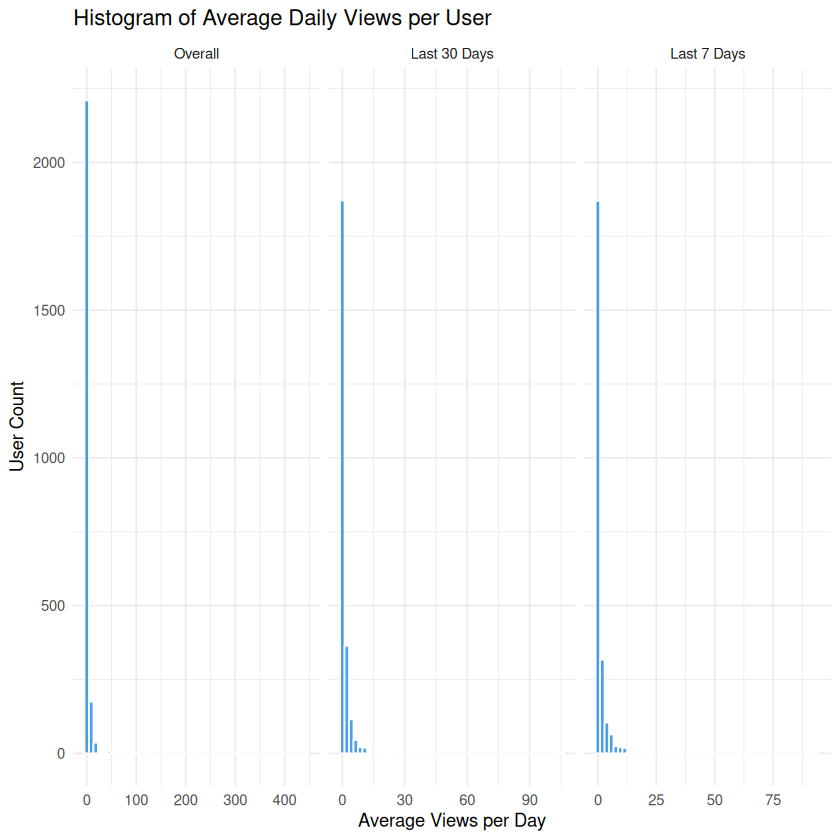

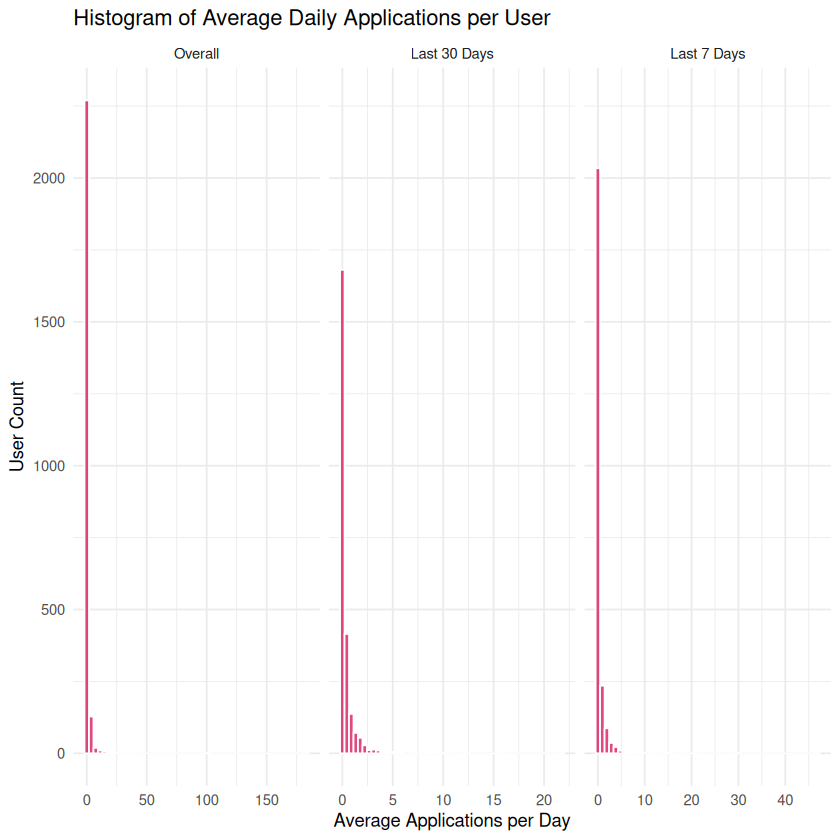

In [14]:
library(ggplot2)
library(data.table)

# ------------------------------------------------------------------------------
# Histogram 1: Views per user per period
# ------------------------------------------------------------------------------

views_long <- melt(
  data = user_metrics[, .(user_id,
                          avg_views_overall_per_day,
                          avg_views_week_per_day,
                          avg_views_month_per_day)],
  id.vars = "user_id",
  variable.name = "period",
  value.name = "avg_views"
)

# Convert to data.table explicitly
setDT(views_long)

# Rename periods
views_long[, period := factor(
  period,
  levels = c("avg_views_overall_per_day", 
             "avg_views_month_per_day", 
             "avg_views_week_per_day"),
  labels = c("Overall", "Last 30 Days", "Last 7 Days")
)]

# Plot
ggplot(views_long, aes(x = avg_views)) +
  geom_histogram(bins = 50, fill = "#1E88E5", color = "white", alpha = 0.8) +
  facet_wrap(~period, scales = "free_x") +
  labs(title = "Histogram of Average Daily Views per User",
       x = "Average Views per Day", y = "User Count") +
  theme_minimal()

# ------------------------------------------------------------------------------
# Histogram 2: Applications per user per period
# ------------------------------------------------------------------------------

apps_long <- melt(
  data = user_metrics[, .(user_id,
                          avg_apps_overall_per_day,
                          avg_apps_week_per_day,
                          avg_apps_month_per_day)],
  id.vars = "user_id",
  variable.name = "period",
  value.name = "avg_apps"
)

setDT(apps_long)

apps_long[, period := factor(
  period,
  levels = c("avg_apps_overall_per_day", 
             "avg_apps_month_per_day", 
             "avg_apps_week_per_day"),
  labels = c("Overall", "Last 30 Days", "Last 7 Days")
)]

ggplot(apps_long, aes(x = avg_apps)) +
  geom_histogram(bins = 50, fill = "#D81B60", color = "white", alpha = 0.8) +
  facet_wrap(~period, scales = "free_x") +
  labs(title = "Histogram of Average Daily Applications per User",
       x = "Average Applications per Day", y = "User Count") +
  theme_minimal()


Warning message in scale_y_continuous(trans = "log10"):
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 310 rows containing non-finite outside the scale range
(`stat_boxplot()`).”


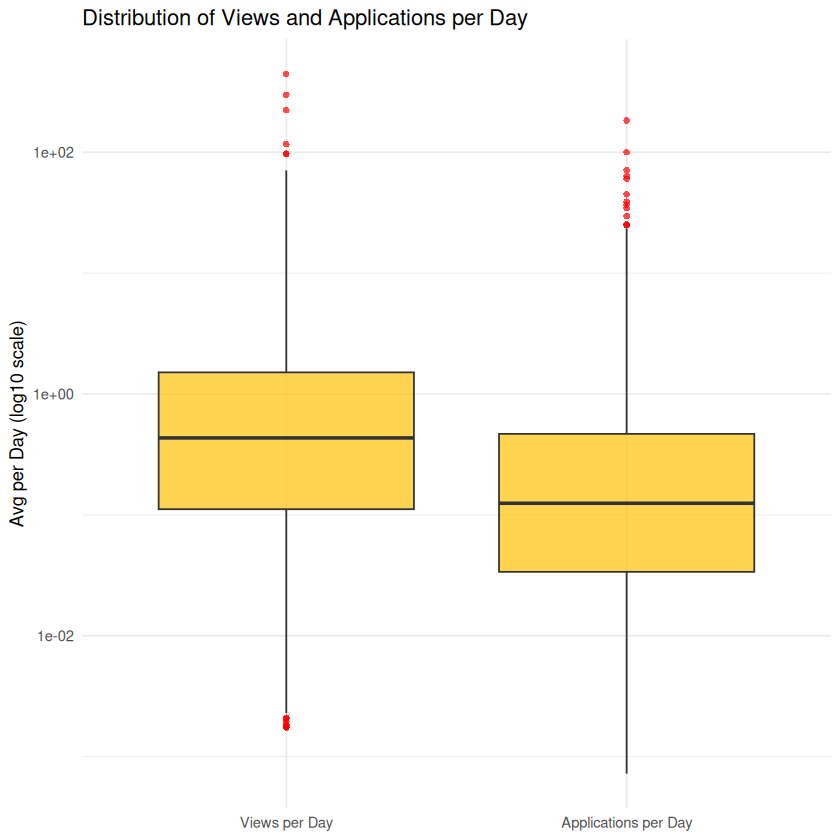

In [15]:
# Combine views + applications into long format for side-by-side comparison
long_outlier_df <- melt(
  user_metrics[, .(user_id,
                   avg_views_overall_per_day,
                   avg_apps_overall_per_day)],
  id.vars = "user_id",
  variable.name = "metric",
  value.name = "value"
)

setDT(long_outlier_df)
long_outlier_df[, metric := factor(metric, labels = c("Views per Day", "Applications per Day"))]

# Boxplot
ggplot(long_outlier_df, aes(x = metric, y = value)) +
  geom_boxplot(fill = "#FFC107", alpha = 0.7, outlier.color = "red", outlier.shape = 16) +
  scale_y_continuous(trans = "log10") +  # useful if values are skewed
  labs(title = "Distribution of Views and Applications per Day",
       y = "Avg per Day (log10 scale)", x = NULL) +
  theme_minimal()


Warning message in scale_x_continuous(trans = "log10"):
“log-10 transformation introduced infinite values.”
Warning message in scale_y_continuous(trans = "log10"):
“log-10 transformation introduced infinite values.”


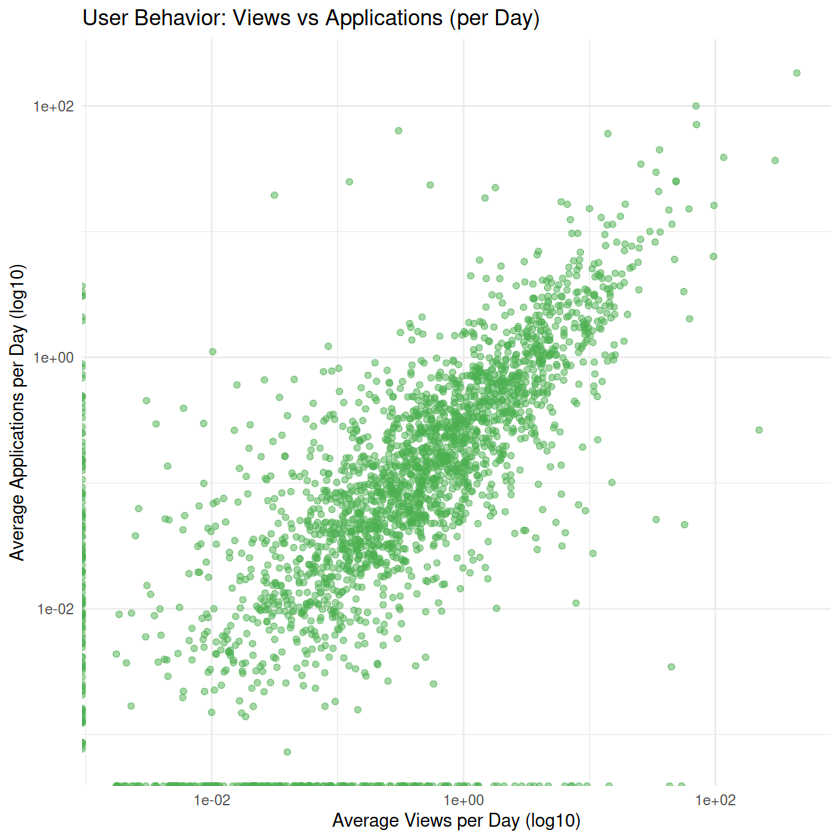

In [16]:
ggplot(user_metrics, aes(x = avg_views_overall_per_day, y = avg_apps_overall_per_day)) +
  geom_point(alpha = 0.5, color = "#4CAF50") +
  scale_x_continuous(trans = "log10") +
  scale_y_continuous(trans = "log10") +
  labs(
    title = "User Behavior: Views vs Applications (per Day)",
    x = "Average Views per Day (log10)",
    y = "Average Applications per Day (log10)"
  ) +
  theme_minimal()


Warning message in scale_x_continuous(trans = "log10"):
“log-10 transformation introduced infinite values.”
Warning message in scale_y_continuous(trans = "log10"):
“log-10 transformation introduced infinite values.”


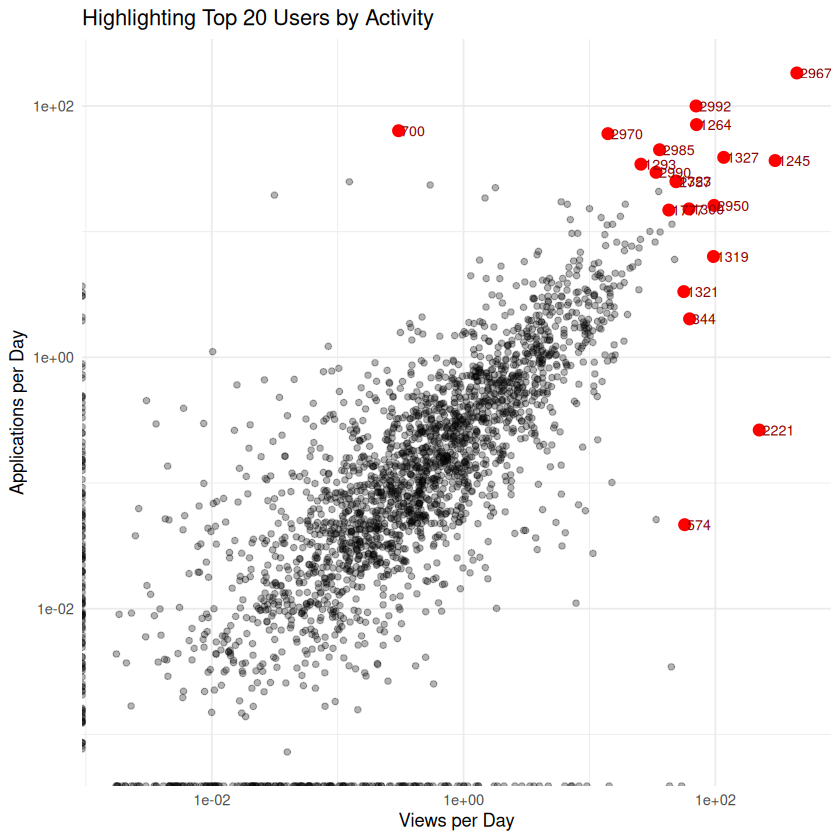

In [17]:
# Add a rank column
user_metrics[, total_score := avg_views_overall_per_day + avg_apps_overall_per_day]
top_users <- user_metrics[order(-total_score)][1:20]

ggplot(user_metrics, aes(x = avg_views_overall_per_day, y = avg_apps_overall_per_day)) +
  geom_point(alpha = 0.3) +
  geom_point(data = top_users, aes(x = avg_views_overall_per_day, y = avg_apps_overall_per_day),
             color = "red", size = 3) +
  geom_text(data = top_users, aes(label = user_id), hjust = -0.1, size = 3, color = "darkred") +
  scale_x_continuous(trans = "log10") +
  scale_y_continuous(trans = "log10") +
  labs(title = "Highlighting Top 20 Users by Activity",
       x = "Views per Day", y = "Applications per Day") +
  theme_minimal()


Warning message in scale_x_continuous(trans = "log10"):
“log-10 transformation introduced infinite values.”
Warning message in scale_y_continuous(trans = "log10"):
“log-10 transformation introduced infinite values.”


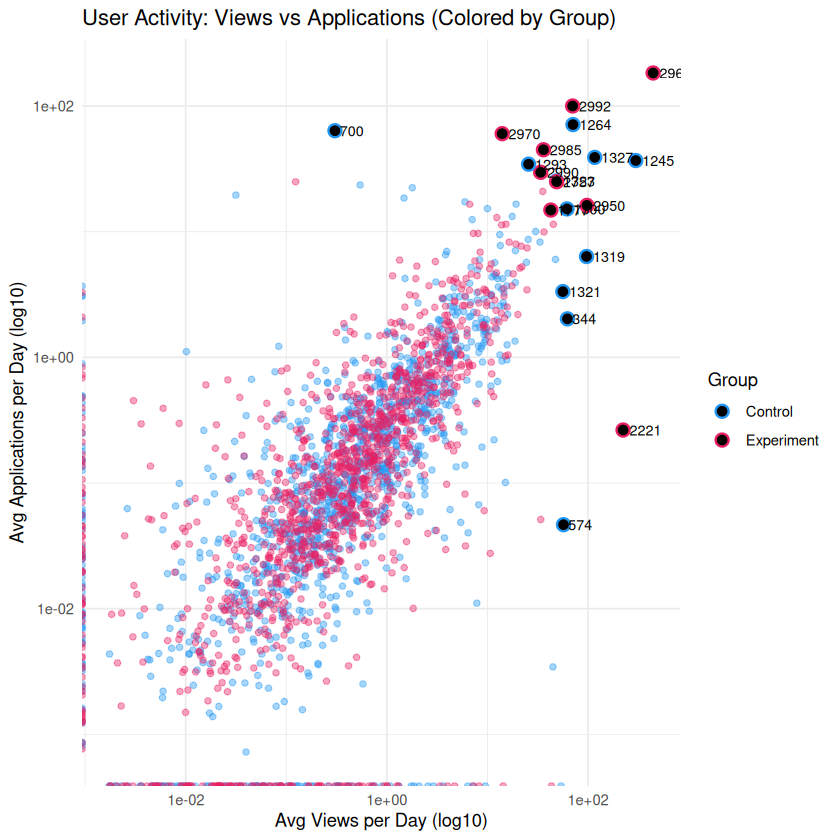

In [18]:
# Step 1: Extract user_id and tag group
control_users <- unique(control_final[, .(user_id)])
control_users[, group := "Control"]

experiment_users <- unique(experiment_final[, .(user_id)])
experiment_users[, group := "Experiment"]

# Step 2: Combine and remove duplicates (some users may appear in both — rare but possible)
user_groups <- rbind(control_users, experiment_users)
user_groups <- unique(user_groups, by = "user_id")

# Step 3: Merge with user_metrics
user_metrics_grouped <- merge(user_metrics, user_groups, by = "user_id", all.x = TRUE)
user_metrics_grouped[is.na(group), group := "Unknown"]  # in case some users aren't found

# Optional: Identify top 20 users by combined activity
user_metrics_grouped[, total_score := avg_views_overall_per_day + avg_apps_overall_per_day]
top_users <- user_metrics_grouped[order(-total_score)][1:20]

# Step 4: Plot
library(ggplot2)

ggplot(user_metrics_grouped, aes(x = avg_views_overall_per_day, y = avg_apps_overall_per_day, color = group)) +
  geom_point(alpha = 0.4) +
  geom_point(data = top_users, aes(x = avg_views_overall_per_day, y = avg_apps_overall_per_day),
             shape = 21, fill = "black", size = 3, stroke = 1) +
  geom_text(data = top_users, aes(label = user_id), hjust = -0.2, size = 3, color = "black") +
  scale_x_continuous(trans = "log10") +
  scale_y_continuous(trans = "log10") +
  scale_color_manual(values = c("Control" = "#2196F3", "Experiment" = "#E91E63", "Unknown" = "gray70")) +
  labs(title = "User Activity: Views vs Applications (Colored by Group)",
       x = "Avg Views per Day (log10)",
       y = "Avg Applications per Day (log10)",
       color = "Group") +
  theme_minimal()


### Covariate Balance Diagnostics: Visual Comparison

We visually assess **covariate balance** between control and experiment groups to verify that randomization produced comparable distributions. This helps ensure any observed outcome differences aren’t driven by pre-existing group imbalances.

#### Purpose
- Detect imbalances in job-level attributes that could bias results.  
- Validate that group differences reflect treatment effects, not confounding covariates.

#### Method

1. **Covariate Types**  
   - We classify variables into **numeric** (e.g., min experience, max age) and **categorical** (e.g., job type, nationality preference).

2. **Numeric Features**  
   - Reshape into long format and plot **faceted histograms**.  
   - These reveal differences in distribution, skew, or outliers between groups.

3. **Categorical Features**  
   - Compute frequency counts, group rare levels under **"Other"**, and plot **proportional bar charts**.  
   - Normalizing within group controls for size differences.

4. **Excluded Features**  
   - We exclude `gst_id` and `job_role` due to high cardinality or low interpretability at this stage.

> These plots serve as a visual **balance check**, highlighting any variables that may require adjustment or stratification in our analysis.

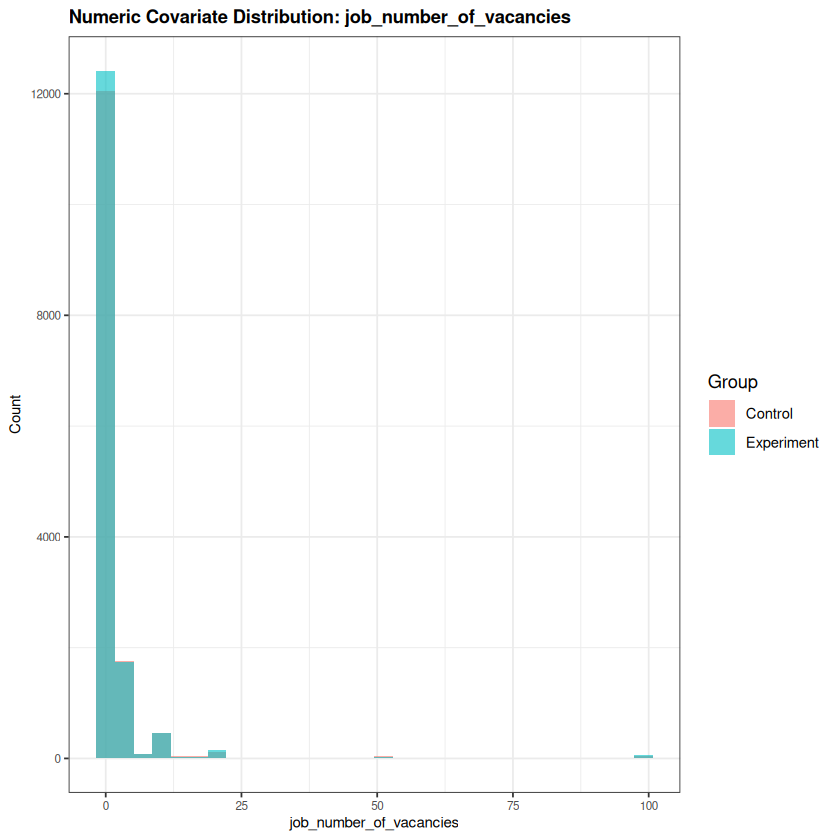

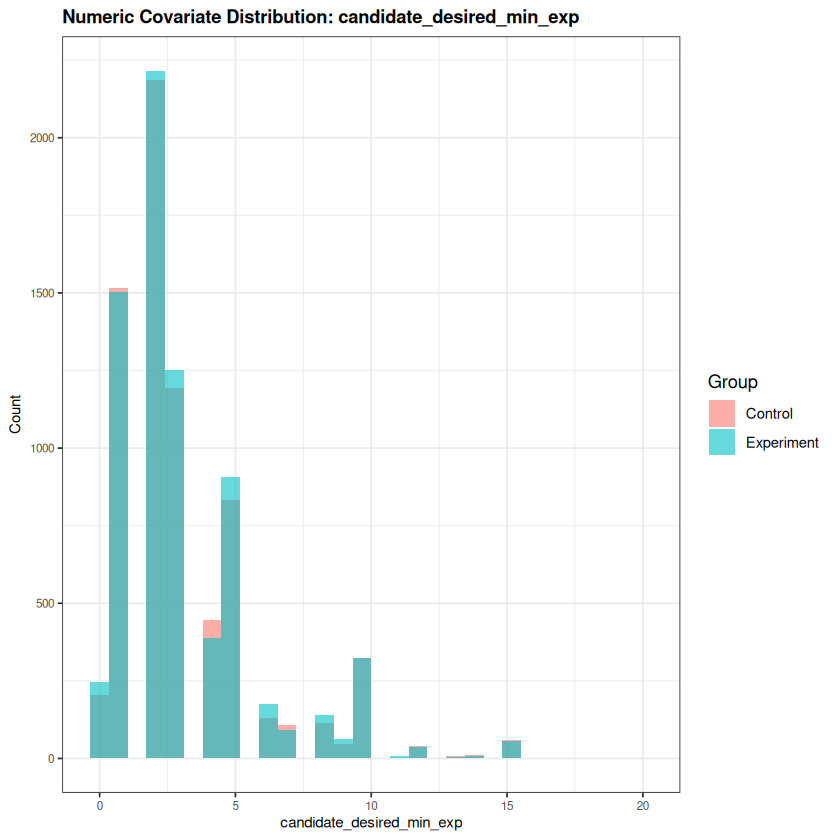

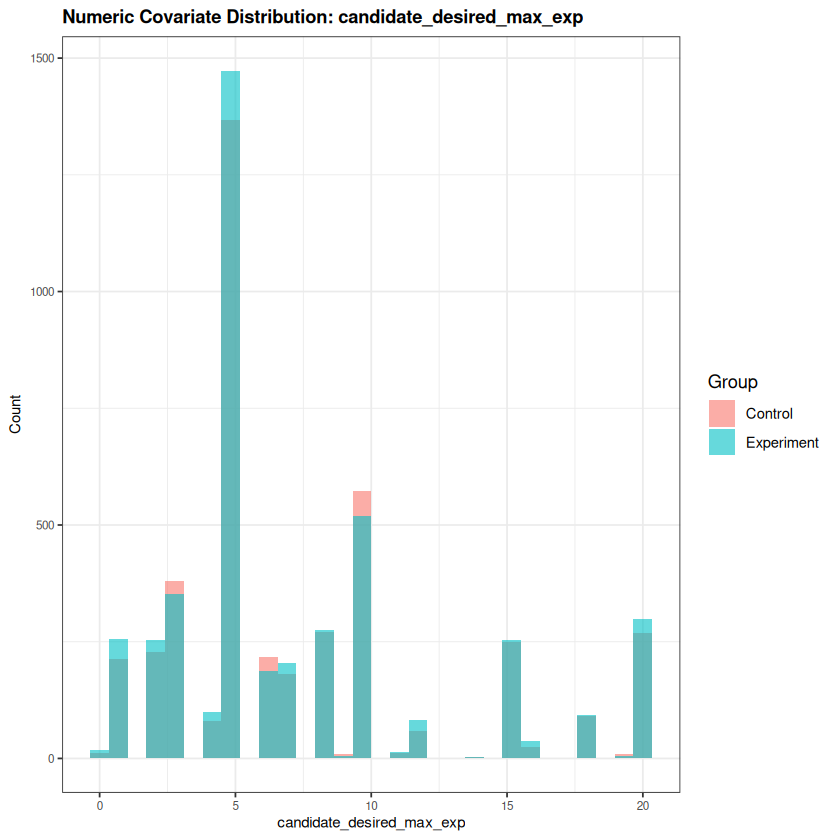

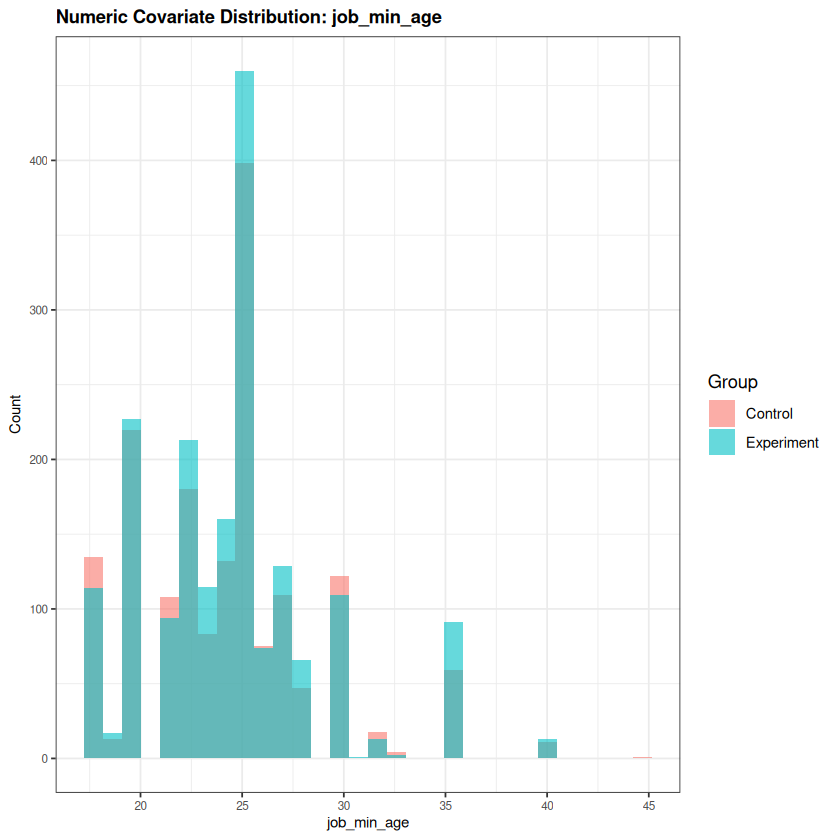

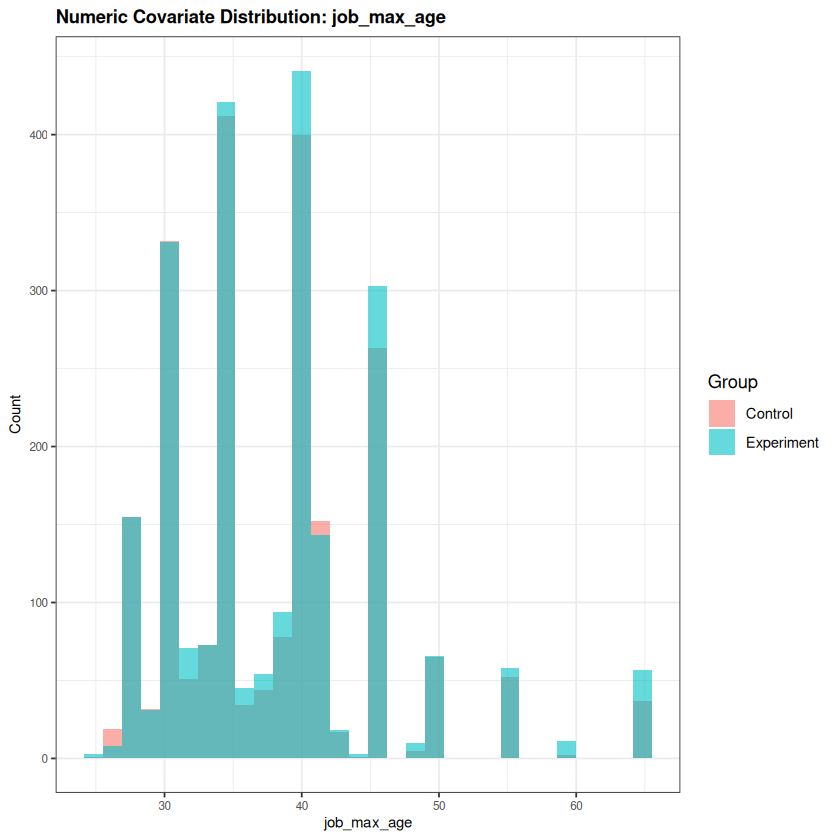

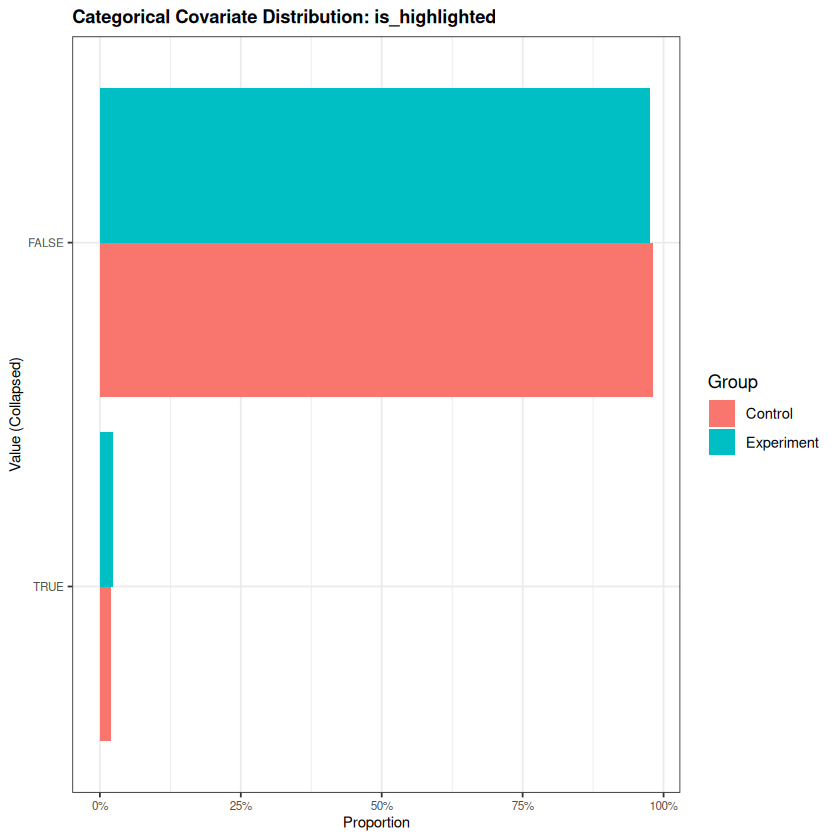

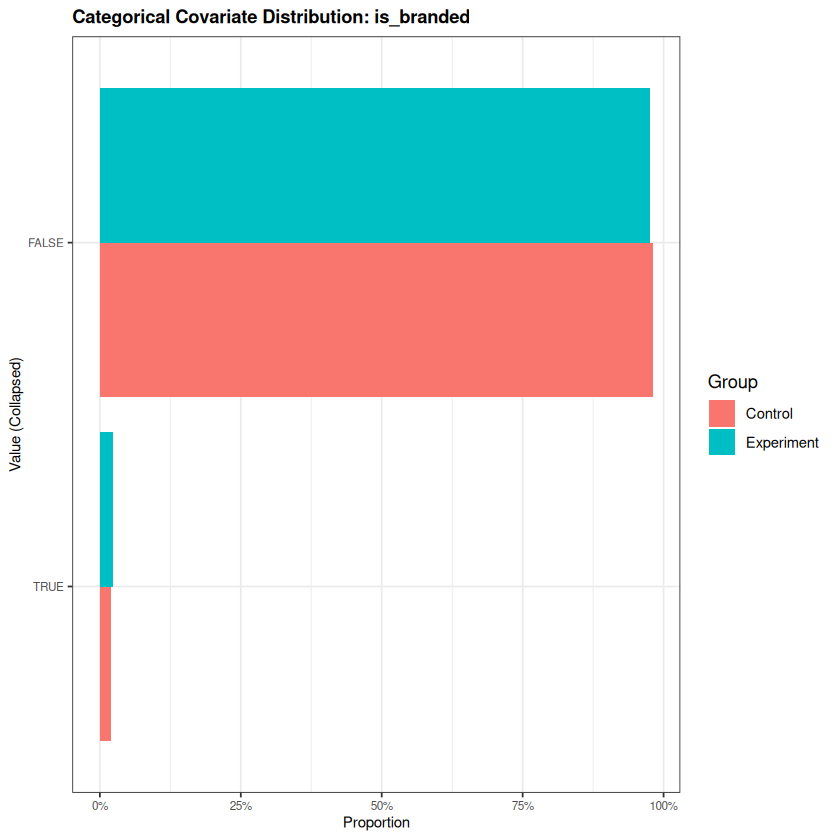

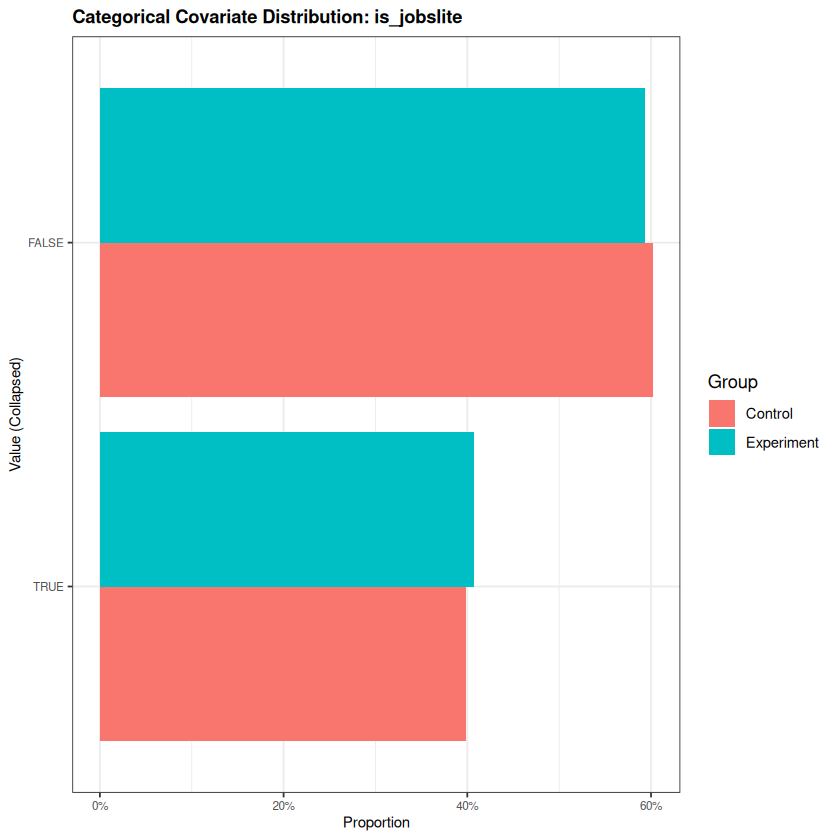

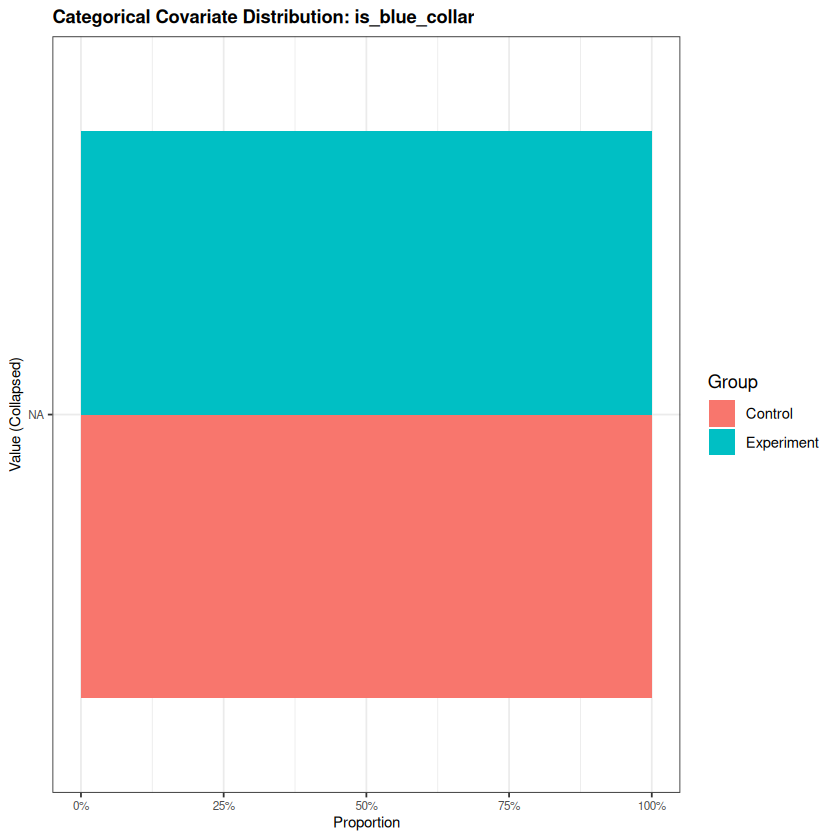

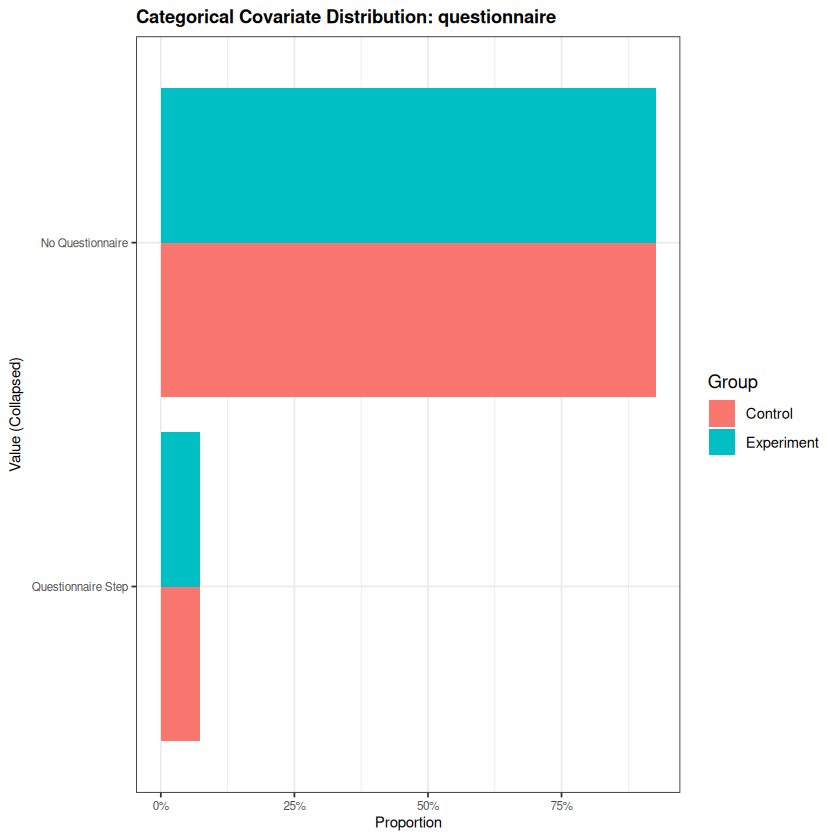

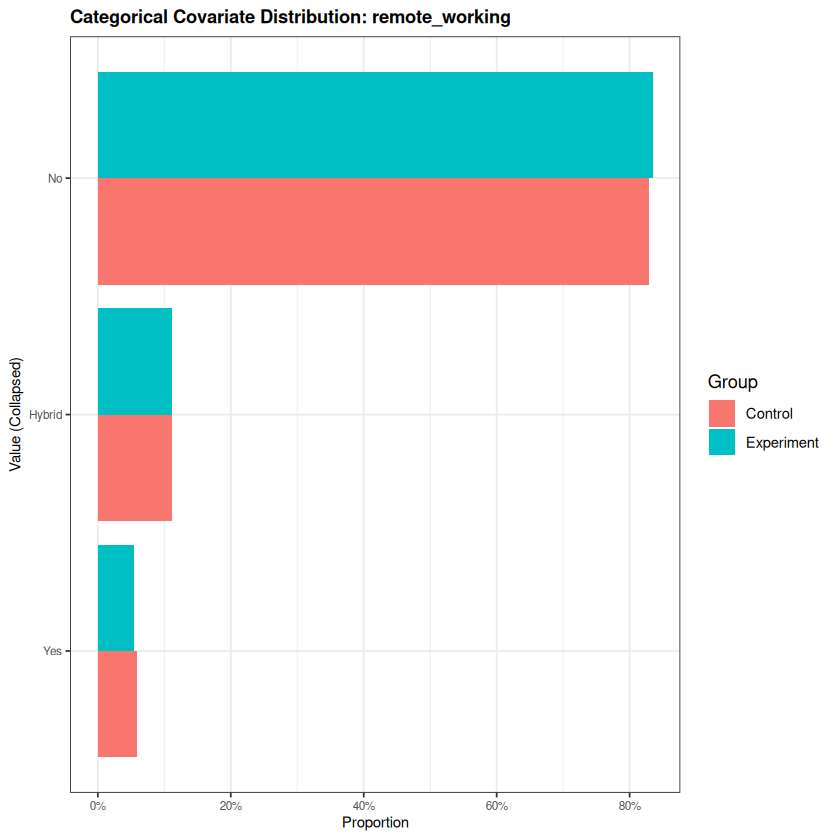

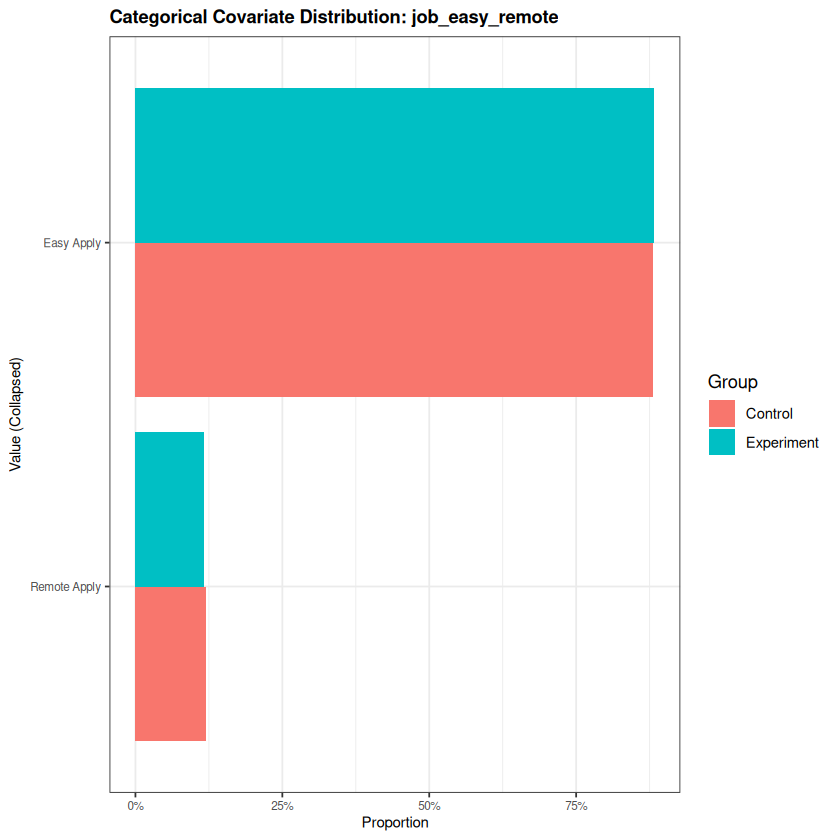

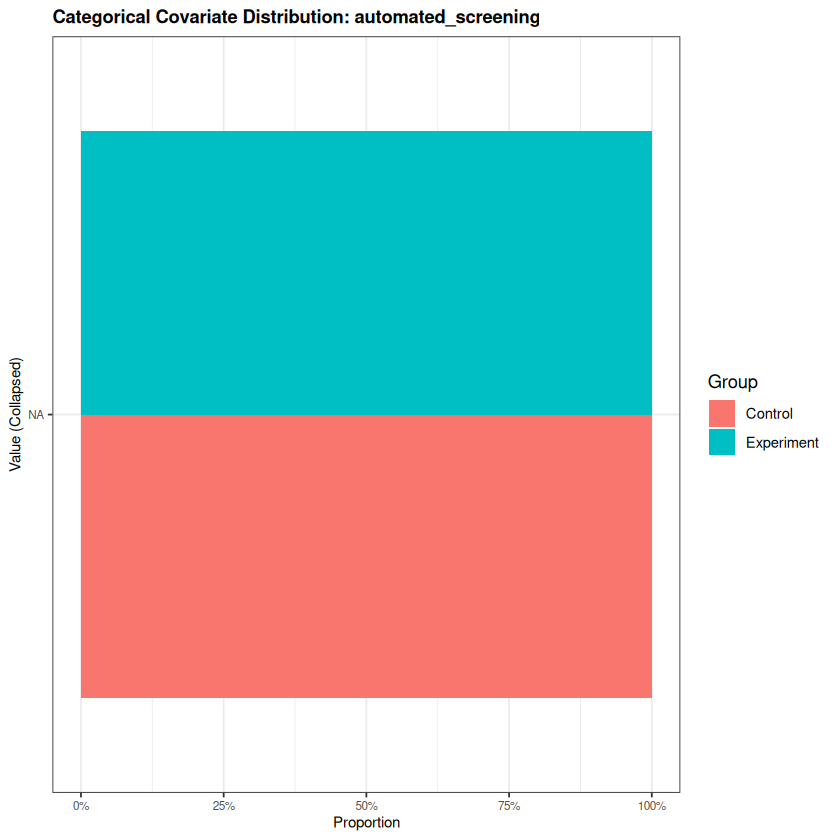

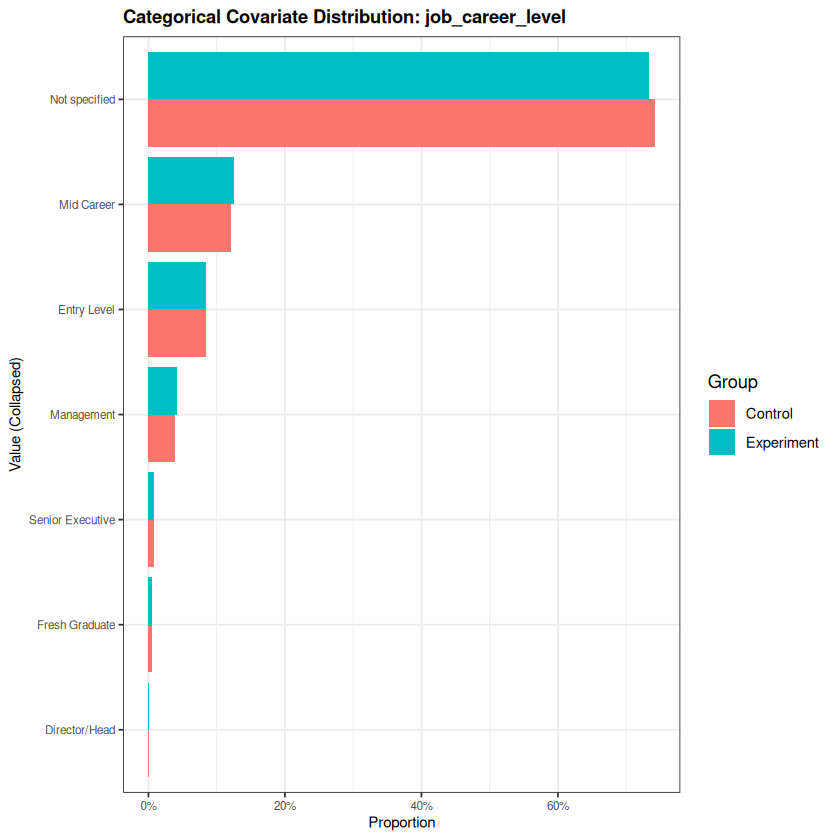

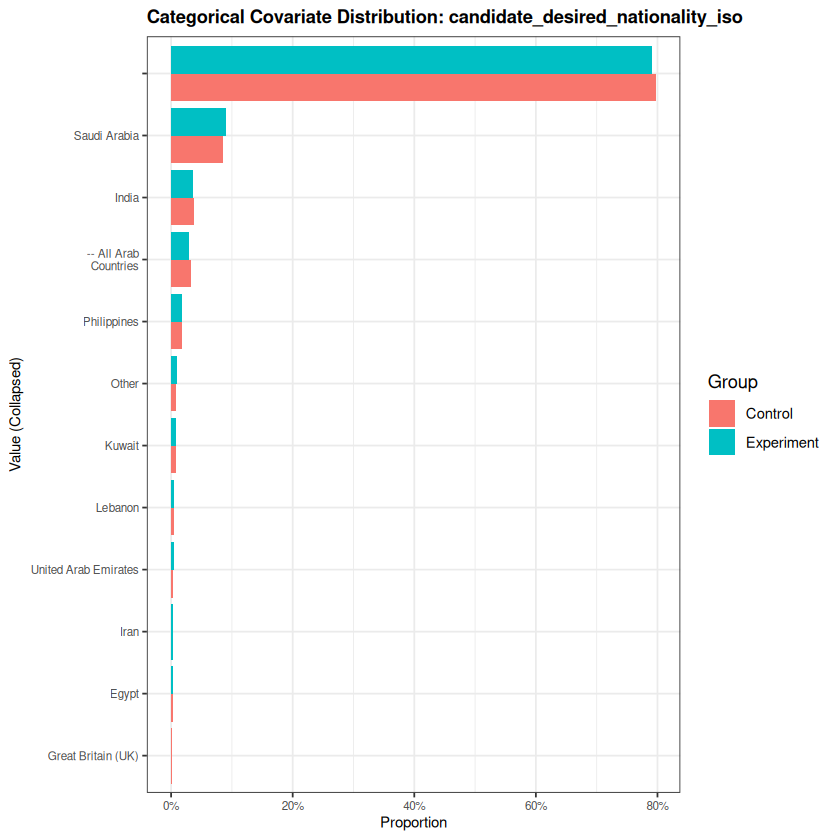

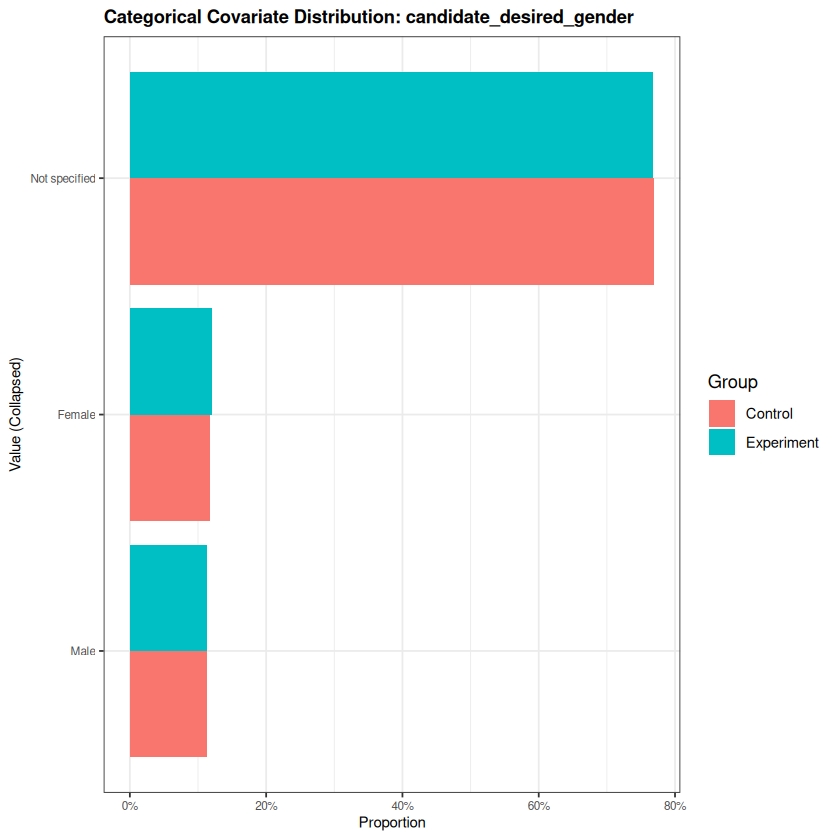

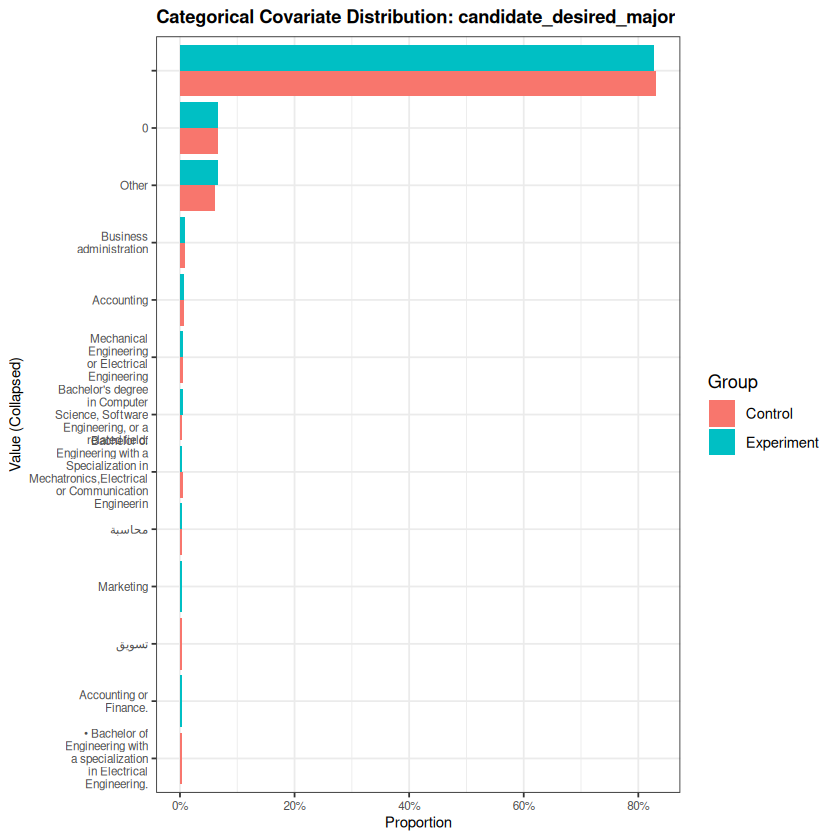

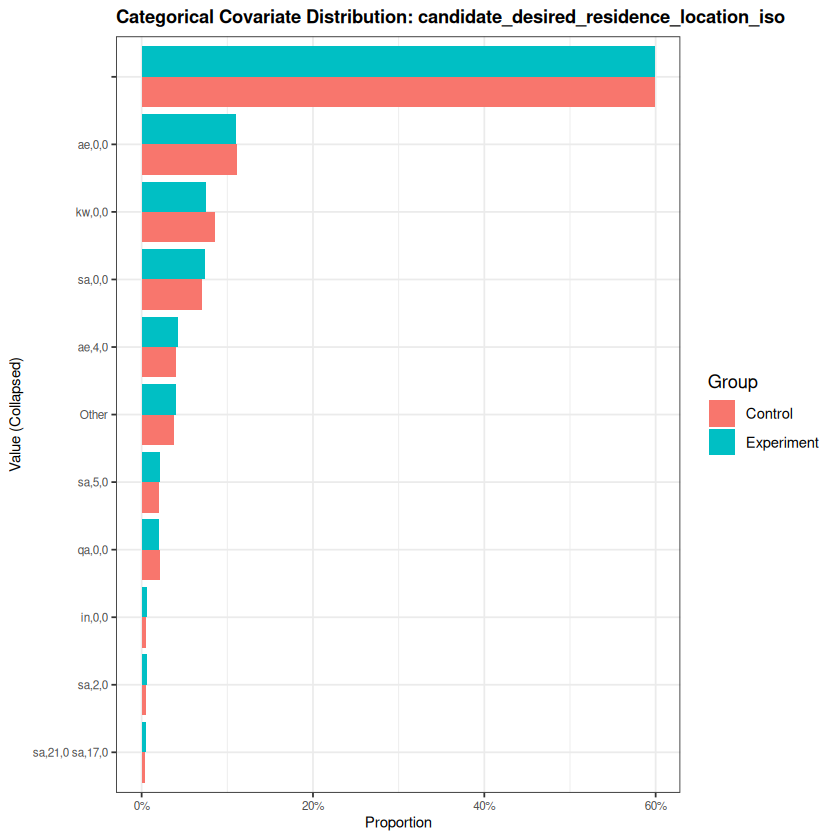

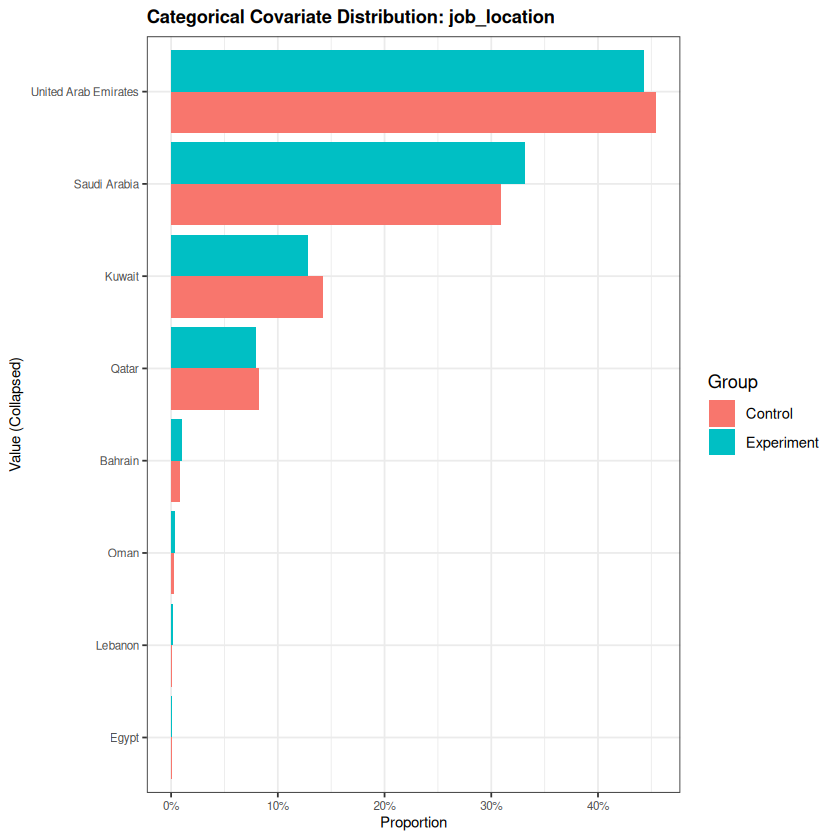

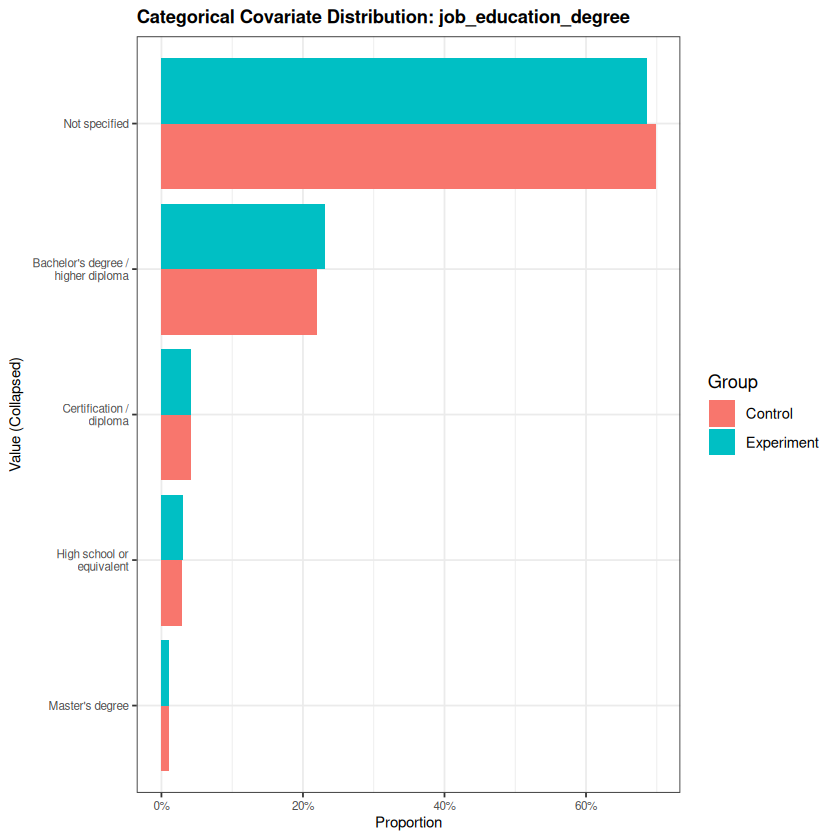

In [19]:
# ------------------------------------------------------------------------------
# Comparative Visualization of Covariate Distributions: Control vs Experiment
# ------------------------------------------------------------------------------
# Purpose:
#   To compare the distribution of various covariate attributes between the control and
#   experiment matching views. Differences in these distributions can flag processing issues,
#   imbalances, or inherent group differences that require adjustment.
#
# Approach:
#   1. Split the covariates into numeric and categorical variables.
#   2. For numeric covariates, reshape the data and plot faceted histograms to compare distributions.
#   3. For categorical covariates, compute frequency counts, collapse infrequent levels into "Other",
#      and plot comparative bar-chart histograms (using proportions) for each attribute.
#
# NOTE: The attributes "gst_id" and "job_role" are excluded to reduce clutter.
#
# Load required libraries
library(data.table)
library(ggplot2)
library(stringr)    # For text wrapping
library(scales)     # For percent format

# ------------------------------------------------------------------------------
# Define Variable Lists (Excluding "gst_id" and "job_role")
# ------------------------------------------------------------------------------
all_attrs <- c(
  "is_highlighted",
  "is_branded",
  "is_jobslite",
  "is_blue_collar",
  "questionnaire",
  "job_number_of_vacancies",
  "remote_working",
  "job_easy_remote",
  "automated_screening",
  #"job_with_keywords_string",
  "job_career_level",
  "candidate_desired_nationality_iso",
  "candidate_desired_gender",
  "candidate_desired_major",
  "candidate_desired_min_exp",
  "candidate_desired_max_exp",
  "candidate_desired_residence_location_iso",
  "job_location",
  "job_education_degree",
  "job_min_age",
  "job_max_age"
)

# Define numeric variables (typically continuous or count data)
numeric_attrs <- c("job_number_of_vacancies", 
                   "candidate_desired_min_exp", 
                   "candidate_desired_max_exp", 
                   "job_min_age", 
                   "job_max_age")

# The rest are considered categorical.
categorical_attrs <- setdiff(all_attrs, numeric_attrs)

# ------------------------------------------------------------------------------
# A. Numeric Covariate Distributions: Histograms (One Plot per Attribute)
# ------------------------------------------------------------------------------
# For numeric covariates, we extract the relevant columns from the control and experiment datasets,
# add a group identifier, combine the data, and reshape to long format for ggplot2.

# Extract numeric attributes from the control group.
control_numeric <- copy(a1_control_matching[, ..numeric_attrs])
control_numeric[, group := "Control"]

# Extract numeric attributes from the experiment group.
experiment_numeric <- copy(b1_experiment_matching[, ..numeric_attrs])
experiment_numeric[, group := "Experiment"]

# Ensure all numeric attributes are truly numeric (double)
numeric_data <- rbind(control_numeric, experiment_numeric)
numeric_data[, (numeric_attrs) := lapply(.SD, as.numeric), .SDcols = numeric_attrs]

# Reshape to long format so that each row corresponds to one observation of a numeric attribute.
numeric_long <- melt(numeric_data, id.vars = "group", 
                     variable.name = "attribute", 
                     value.name = "value")
# Remove non-finite values (NA, Inf, -Inf) which cause plotting issues.
numeric_long <- numeric_long[is.finite(value)]

# Loop over each numeric attribute and create a histogram.
for (attr in numeric_attrs) {
  df_sub <- numeric_long[attribute == attr]
  
  p <- ggplot(df_sub, aes(x = value, fill = group)) +
    geom_histogram(alpha = 0.6, position = "identity", bins = 30) +
    labs(
      title = paste("Numeric Covariate Distribution:", attr),
      x = attr,
      y = "Count",
      fill = "Group"
    ) +
    theme_bw() +
    theme(
      plot.title = element_text(size = 11, face = "bold"),
      axis.text = element_text(size = 7),
      axis.title = element_text(size = 9)
    )
  
  print(p)
}

# ------------------------------------------------------------------------------
# B. Categorical Covariate Distributions: Bar-Chart Histograms (One Plot per Attribute)
# ------------------------------------------------------------------------------
# For categorical covariates, we compute frequency counts per attribute value for both groups.
# Infrequent levels (beyond a threshold) are collapsed into "Other" and proportions are computed
# to enable direct comparison between groups even if group sizes differ.

# Function to collapse infrequent categories for a single attribute.
collapse_cats <- function(dataset, attr, group_label, threshold = 10) {
  # Count frequency of each value.
  dt <- dataset[, .N, by = .(value = get(attr))]
  dt[, attribute := attr]
  dt[, group := group_label]
  
  # Order by descending frequency and rank.
  setorder(dt, -N)
  dt[, rank := seq_len(.N)]
  
  # Collapse levels beyond the top 'threshold' into "Other".
  dt[, value_recode := ifelse(rank <= threshold, as.character(value), "Other")]
  
  # Re-aggregate counts after collapsing.
  dt_c <- dt[, .(N = sum(N)), by = .(value_recode)]
  dt_c[, total := sum(N)]
  dt_c[, proportion := N / total]
  # Return with the attribute and group info.
  dt_c[, `:=`(group = group_label, attribute = attr)]
  return(dt_c)
}

# Loop over each categorical attribute and plot.
for (attr in categorical_attrs) {
  
  # Collapse categories for Control.
  control_cat <- collapse_cats(a1_control_matching, attr, "Control", threshold = 10)
  # Collapse categories for Experiment.
  experiment_cat <- collapse_cats(b1_experiment_matching, attr, "Experiment", threshold = 10)
  
  # Combine both groups.
  cat_dt <- rbindlist(list(control_cat, experiment_cat), use.names = TRUE, fill = TRUE)
  
  # Create bar chart comparing proportions.
  p <- ggplot(cat_dt, aes(x = reorder(value_recode, N), y = proportion, fill = group)) +
    geom_bar(stat = "identity", position = "dodge") +
    coord_flip() +
    labs(
      title = paste("Categorical Covariate Distribution:", attr),
      x = "Value (Collapsed)",
      y = "Proportion",
      fill = "Group"
    ) +
    scale_x_discrete(labels = function(x) str_wrap(x, width = 20)) +
    scale_y_continuous(labels = percent_format(accuracy = 1)) +
    theme_bw() +
    theme(
      plot.title = element_text(size = 11, face = "bold"),
      axis.text = element_text(size = 7),
      axis.title = element_text(size = 9)
    )
  
  print(p)
}

# ------------------------------------------------------------------------------
# 3. (Optional) Save the Outputs to a PDF
# ------------------------------------------------------------------------------
# Uncomment the following lines to save all plots in a multi-page PDF.
# pdf("covariate_distributions.pdf", width = 11, height = 8)
#   # (Place the two loops above here)
# dev.off()


### Summary: Covariate Distribution Visuals

#### Numeric Covariates

1. **`job_number_of_vacancies`**  
   - Strong **right skew**, mostly set to 1.  
   - Control and experiment groups show **overlapping distributions**.

2. **`candidate_desired_min_exp` & `max_exp`**  
   - Similar **multimodal patterns** across groups.  
   - Minor differences in peaks — nothing concerning.

3. **`job_min_age` & `max_age`**  
   - Peak around 25 (min) and 35–40 (max).  
   - **No visible imbalance** between groups.

#### Categorical Covariates

1. **Presentation (`is_highlighted`, `is_branded`, `is_jobslite`)**  
   - **Near-identical distributions** — consistent styling exposure.

2. **Functionality (`automated_screening`, `job_easy_remote`, `questionnaire`)**  
   - Overall balanced.  
   - Slight variation in `job_easy_remote`, but not significant.

3. **Remote Work (`remote_working`)**  
   - Mostly “No”; “Hybrid” is second-most common.  
   - **Slightly more "Hybrid"** in experiment group — worth noting.

4. **Requirements (`job_with_keywords_string`, `career_level`, `education_degree`)**  
   - Many entries are **"Not specified"**, limiting analytical value.  
   - Where specified, distributions align well.

5. **Employer Preferences (`desired_nationality`, `gender`, `major`)**  
   - **Nationality**: Heavily skewed toward “Saudi Arabia” — consistent across groups.  
   - **Gender**: Mostly “Not specified”; male/female breakdown balanced.  
   - **Majors**: Sparse and long-tailed — shared top-heavy pattern in both groups.

6. **Location Preferences (`desired_residence`, `job_location`)**  
   - **UAE and KSA dominate** both actual and desired locations.  
   - Distribution matches across groups.

---

### Key Takeaways

| Feature                     | Note                                                                 |
|----------------------------|----------------------------------------------------------------------|
| `job_with_keywords_string` | Sparse/noisy — not reliable as a covariate.                         |
| `job_education_degree`     | "Not specified" dominates — reduces interpretability.               |
| `remote_working`           | Slight skew toward "Hybrid" in experiment — minor, but trackable.   |
| `automated_screening`      | Balanced — suggests no screen-induced bias.                         |
| `candidate_desired_major`  | Very fragmented — may need consolidation into broader categories.   |

### Visualizing Match-Based Covariate Distributions (User–Job Fit)

We visualize **binary and categorical indicators** that capture how well candidates align with job requirements — these are **computed match features** at the user–job level, not raw job attributes. We believe that these matching covariates are the most determining points, after the actual content of the job.

#### Objective
- Check if **fit characteristics** are balanced across control and experiment groups.  
- Identify any systematic match quality differences that could bias treatment effect estimates.

#### Matching Features

| Covariate              | Description                                                             |
|------------------------|-------------------------------------------------------------------------|
| `career_level_match`   | Career level alignment                                                  |
| `experience_match`     | Experience within job range                                             |
| `age_match`            | Age within required range                                               |
| `location_match`       | Residence in preferred region                                           |
| `education_match`      | Education meets requirement                                             |
| `gender_match`         | Gender matches employer preference                                      |
| `nationality_match`    | Matches preferred nationality or regional group                         |
| `gst_matching`         | Industry sector alignment (`gst_id_arr` vs. `gst_id`)                   |
| `seq`                  | Number of exposures to the same job — a proxy for **familiarity bias**  |

#### Visualization Strategy
- We use **side-by-side bar charts** to compare counts between control and experiment groups.  
- Each bar shows how many user–job records fall under each matching outcome (`matching`, `not matching`, etc.).  
- These visuals help assess **randomization quality** on user–job alignment.

> If we observe imbalances, we may need to control for or stratify on specific fit indicators in later modeling.

### Why This Step Matters (Experimental Design Perspective)**

- **Randomization ensures balance in both observed and unobserved covariates** across treatment arms.
- However, **checking covariate balance** is necessary to:
  - Verify that randomization **succeeded by chance** 
  - Identify covariates that may later **interact with treatment** and affect outcomes.
  - **Stratify or control** for unbalanced covariates to improve statistical power.

This visual check helps answer:
- Do users in both groups have **similar matching distributions**?
- Are some matching criteria **heavily skewed** in one group?
- Could observed differences in outcomes be due to **pre-treatment imbalances**?

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


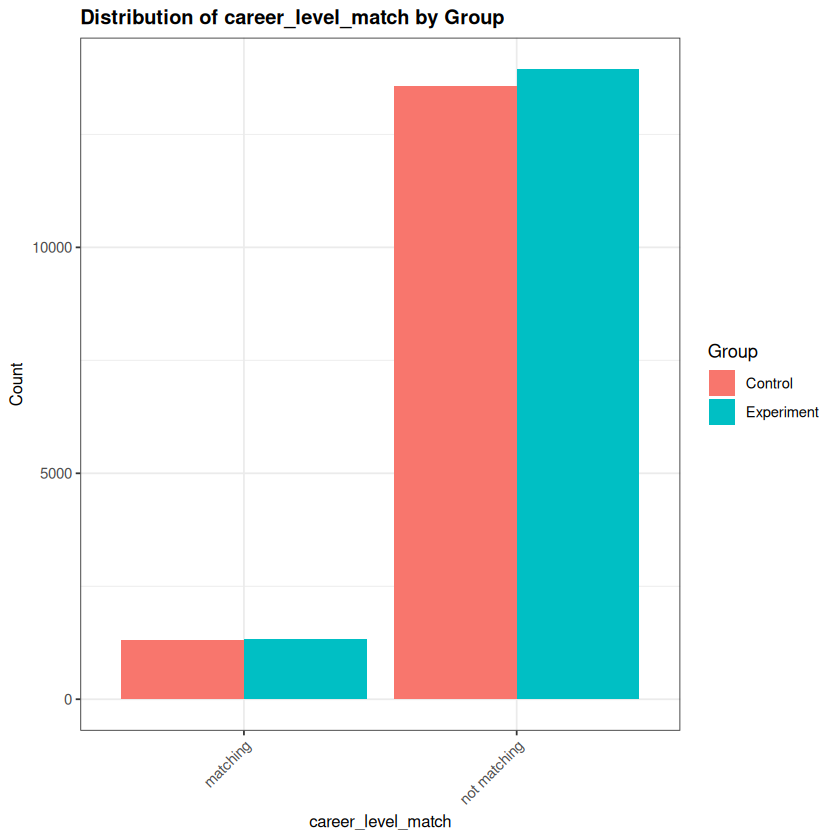

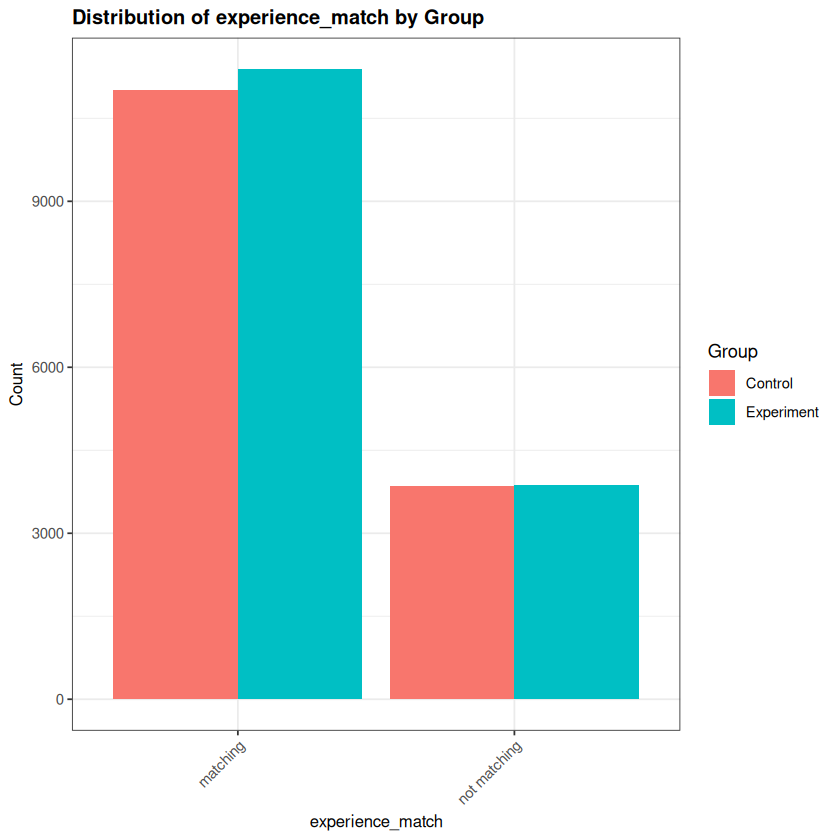

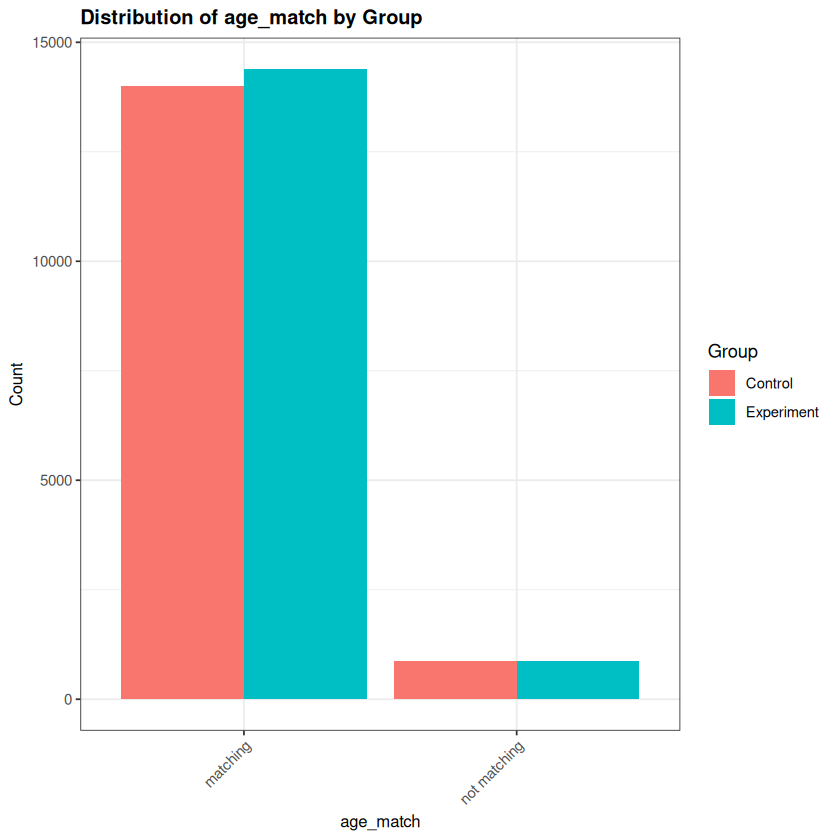

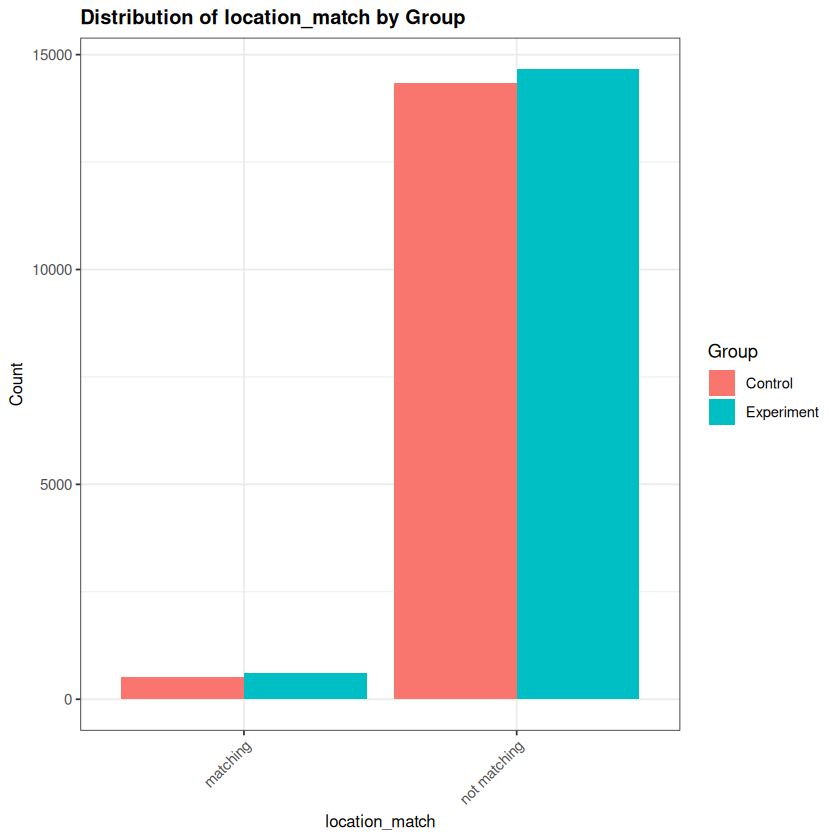

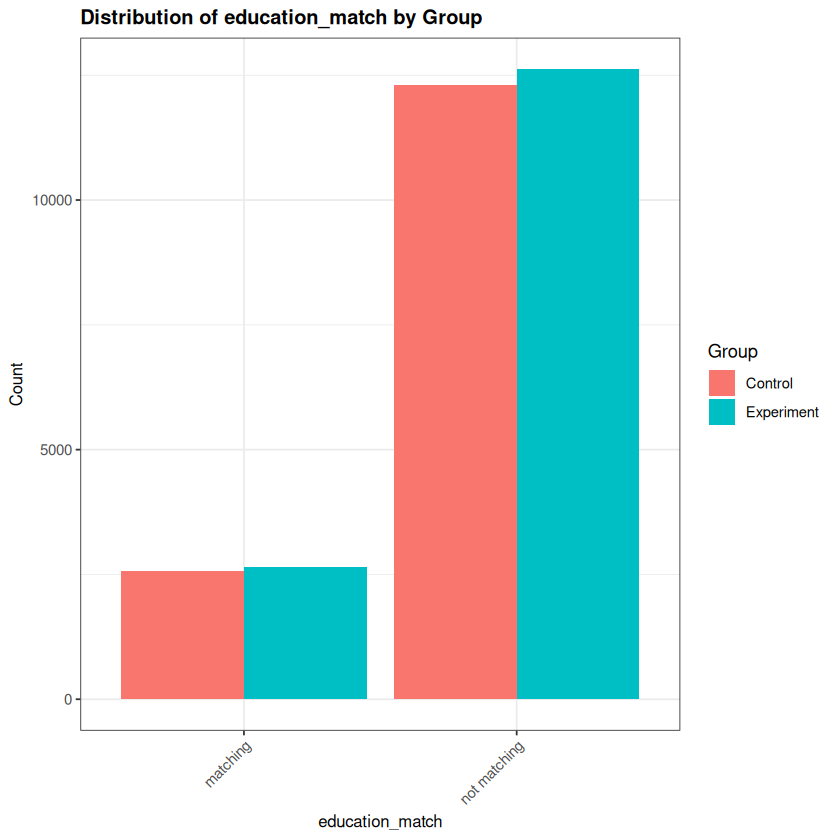

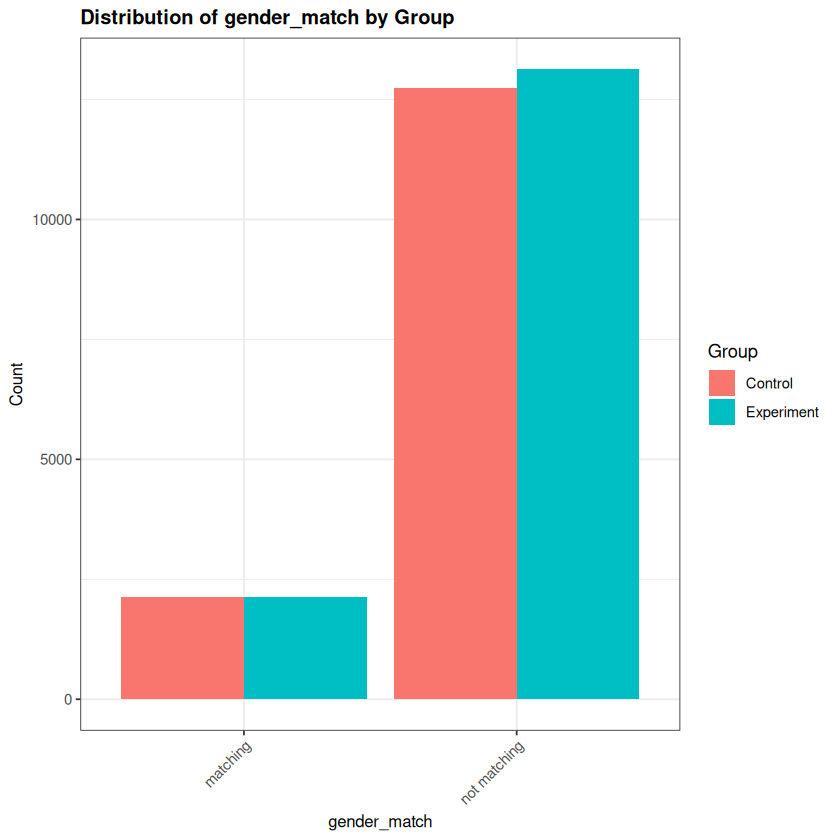

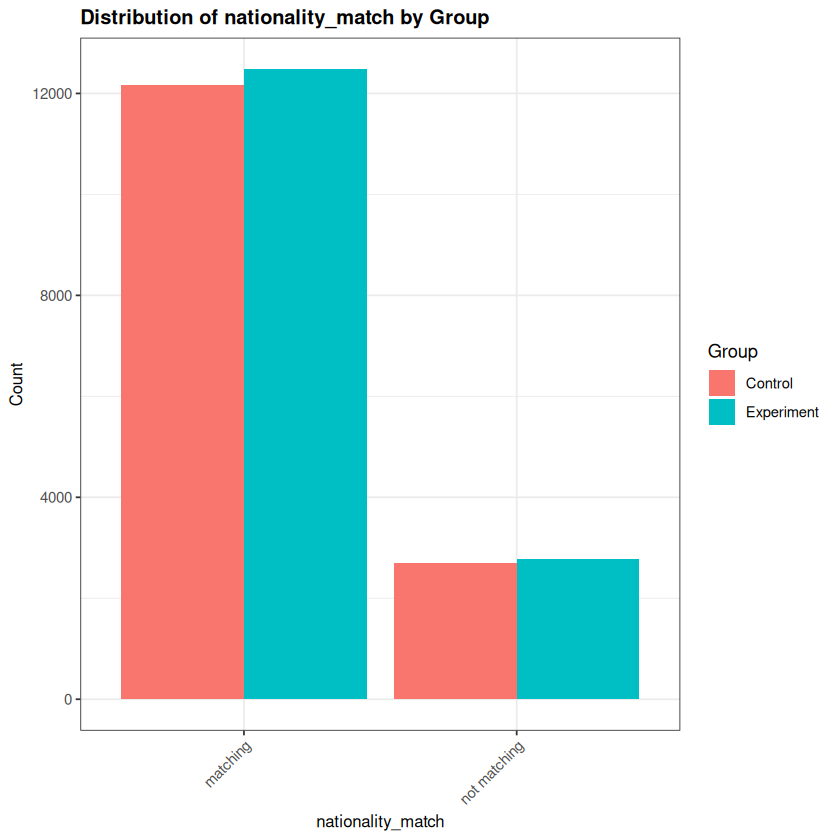

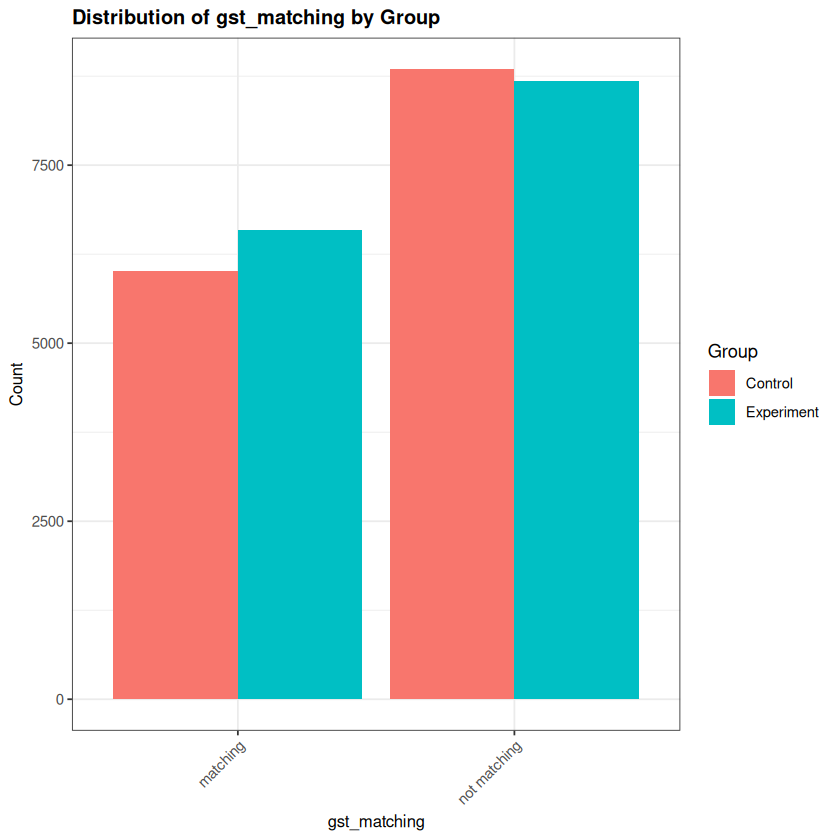

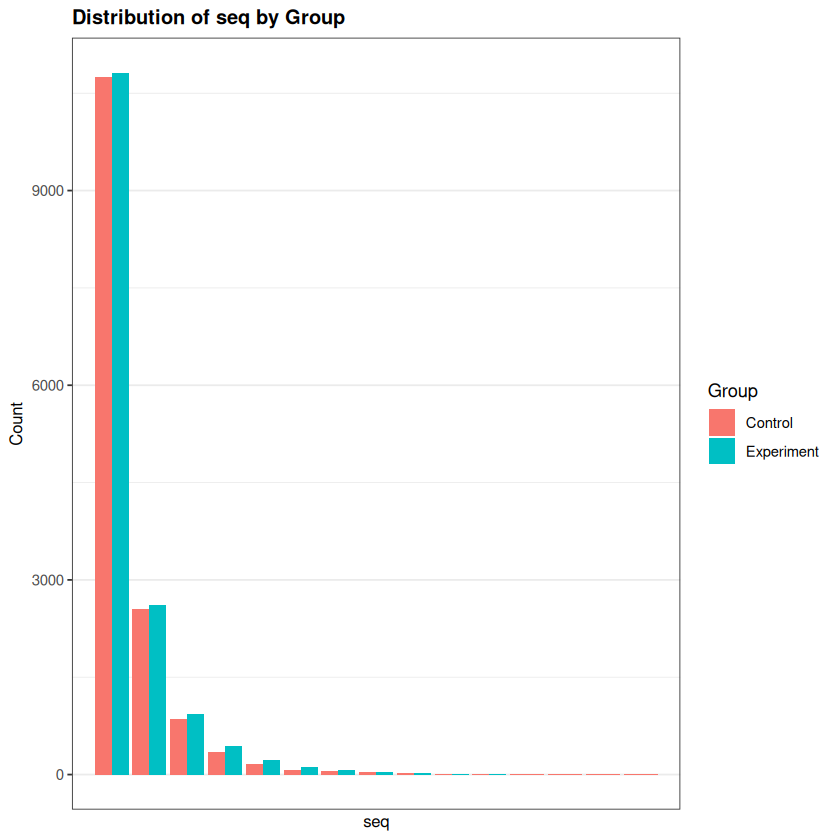

In [20]:
# ------------------------------------------------------------------------------
# Visualizing Matching-Based Covariate Distributions with Bar Charts
# ------------------------------------------------------------------------------
# Purpose:
#   Provide a visual comparison of the key matching indicators between Control and Experiment.

# 1. Make sure each table has a group label
a1_control_matching[,    group := "Control"]
b1_experiment_matching[, group := "Experiment"]

# 2. Combine them
combined_matching <- rbind(
  a1_control_matching, 
  b1_experiment_matching,
  fill = TRUE
)

# 3. List of matching indicators (use the actual column names)
matching_covariates <- c(
  "career_level_match",
  "experience_match",
  "age_match",
  "location_match",
  "education_match",
  "gender_match",
  "nationality_match",
  "gst_matching",        # <-- corrected to the real column name
  "seq"
)

# 4. Load plotting libs
library(ggplot2)
library(stringr)

# 5. Loop and plot
for (cov in matching_covariates) {
  p <- ggplot(combined_matching, aes_string(x = cov, fill = "group")) +
    geom_bar(position = "dodge") +
    labs(
      title = paste("Distribution of", cov, "by Group"),
      x = cov,
      y = "Count",
      fill = "Group"
    ) +
    scale_x_discrete(labels = function(x) str_wrap(x, width = 15)) +
    theme_bw() +
    theme(
      plot.title   = element_text(size = 12, face = "bold"),
      axis.text.x  = element_text(angle = 45, hjust = 1, size = 9),
      axis.text.y  = element_text(size = 9),
      axis.title   = element_text(size = 10)
    )
  print(p)
}


### Balanced Matching Covariates

These covariates show **similar distributions** across control and experiment groups, indicating that randomization likely succeeded:

| Covariate            | Observation                                                                 |
|----------------------|------------------------------------------------------------------------------|
| `experience_match`   | Nearly equal match counts across both groups.                               |
| `age_match`          | High match rate with minimal group-level difference.                        |
| `nationality_match`  | Matching vs. non-matching split is nearly identical.                        |
| `gst_matching`       | Similar proportions of match/no-match in both groups.                       |
| `seq`                | Exposure sequence distributions align closely — no sign of exposure bias.   |

---

### Potentially Imbalanced Covariates

These covariates show **slight but consistent imbalance**, which could impact outcome interpretation:

| Covariate             | Observation                                                                 |
|-----------------------|------------------------------------------------------------------------------|
| `career_level_match`  | Slightly more non-matches in the experiment group.                          |
| `location_match`      | Low match rates overall, with fewer matches in the experiment group.        |
| `education_match`     | Higher non-match rate in experiment group.                                  |
| `gender_match`        | Consistently more non-matches in experiment — gap is small but present.     |

---

### Interpretation & Implications

- Most matching covariates appear **balanced**, but a few (e.g., `career_level`, `education`, `gender`) show **mild imbalance**.
- These do **not invalidate** the experiment but should be:
  1. **Monitored** in outcome comparisons.  
  2. **Controlled for** via covariate adjustment or interaction terms in regression.  
  3. Explored for **heterogeneous treatment effects** — e.g., does match quality modify the impact of job ranking?

# Pre/Post Engagement Analysis: Control vs. Experiment

## Objective

We assess whether the intervention affected user behavior by comparing:

- **Views per day**  
- **Applications per day**

We analyze these metrics **before** and **during** the experiment across both control and experiment groups to detect behavioral shifts driven by the treatment.

---

## Methodology

### Defining the Experiment Window

We define the active experiment window as:

- **Start**: `min(experiment_final$date_time)`  
- **End**: `max(experiment_final$date_time)`  
- **Duration**: `exp_days = difftime(end, start, units = "days")`

This captures all in-experiment user events.

---

### Metrics Computed Per User

| Period      | Metric            | Source                              |
|-------------|-------------------|-------------------------------------|
| Pre         | Views per day     | `avg_views_overall_per_day`         |
| Pre         | Apps per day      | `avg_apps_overall_per_day`          |
| Post        | Views per day     | Views during experiment / `exp_days` |
| Post        | Apps per day      | Apps during experiment / `exp_days`  |

We sum views and applications during the experiment only and normalize by the number of days.

---

## Analysis Steps

1. Merge pre- and post-period metrics per user.
2. Reshape to long format with a `period` column (`Pre`, `Post`).
3. Run regressions separately for each group:

```r
lm(views_per_day ~ period)
lm(apps_per_day ~ period)
```

The key coefficient is `periodPost`, capturing the behavioral shift from pre to post.

---

## Regression Interpretation

| Term         | Meaning                                        |
|--------------|------------------------------------------------|
| (Intercept)  | Avg. daily views/apps **before** the experiment |
| `periodPost` | Estimated **change** in behavior **after**     |
| P-value      | Significance of that change (p < 0.05 = significant) |
| R²           | Proportion of variance explained               |

---

## Expected Outcome Summary

| Group        | Metric          | Expected Behavior                  |
|--------------|------------------|------------------------------------|
| Control      | Views / Apps     | Minimal or no change               |
| Experiment   | Views / Apps     | Increase due to intervention       |

A significant post-period increase **only in the experiment group** suggests the treatment had a **causal effect**.

---

## Extensions

- Run a **Difference-in-Differences (DiD)** model:

```r
lm(metric ~ group * period, data = pooled_data)
```

- Add error bars (mean ± 95% CI) in visualizations.
- Segment analysis (e.g., by matching indicators, activity level).
- Use robust standard errors to account for heteroskedasticity.

In [21]:
library(data.table)
library(stats)

# ------------------------------------------------------------------------------
# ASSUMPTIONS
#  - control_final & experiment_final each have:
#      user_id,
#      avg_views_overall_per_day,
#      avg_apps_overall_per_day
#  - events_dt has:
#      user_id, event_name ("user_viewed_job"/"apply_job"), date_time_event (POSIXct)
#  - experiment_final$date_time defines the experiment window
# ------------------------------------------------------------------------------

# 1. Define the global experiment window
exp_start <- min(experiment_final$date_time, na.rm = TRUE)
exp_end   <- max(experiment_final$date_time, na.rm = TRUE)
exp_days  <- as.numeric(difftime(exp_end, exp_start, units = "days"))

# Helper to compute post‑period per‑day rates
compute_post <- function(user_ids) {
  dt <- events_dt[
    date_time_event >= exp_start & date_time_event <= exp_end &
    user_id %in% user_ids
  ]
  dt[, .(
    total_views = sum(event_name == "user_viewed_job", na.rm = TRUE),
    total_apps  = sum(event_name == "apply_job",        na.rm = TRUE)
  ), by = user_id][
    , .(user_id,
        post_avg_views = total_views / exp_days,
        post_avg_apps  = total_apps  / exp_days)
  ]
}

# ------------------------------------------------------------------------------
# CONTROL GROUP
# ------------------------------------------------------------------------------
# 2a. Pre‑period metrics
pre_ctrl <- unique(control_final[, .(
  user_id,
  pre_avg_views = avg_views_overall_per_day,
  pre_avg_apps  = avg_apps_overall_per_day
)])

# 2b. Post‑period metrics
post_ctrl <- compute_post(pre_ctrl$user_id)

# 2c. Merge
cmp_ctrl <- merge(pre_ctrl, post_ctrl, by = "user_id")

# 2d. Reshape & regress views
views_long_ctrl <- melt(
  cmp_ctrl,
  id.vars      = "user_id",
  measure.vars = c("pre_avg_views","post_avg_views"),
  variable.name = "period",
  value.name    = "views_per_day"
)
views_long_ctrl[, period := factor(period,
                                   levels = c("pre_avg_views","post_avg_views"),
                                   labels = c("Pre","Post"))]

lm_views_ctrl <- lm(views_per_day ~ period, data = views_long_ctrl)
cat("=== Control: Views per Day Regression ===\n")
print(summary(lm_views_ctrl))

# 2e. Reshape & regress apps
apps_long_ctrl <- melt(
  cmp_ctrl,
  id.vars      = "user_id",
  measure.vars = c("pre_avg_apps","post_avg_apps"),
  variable.name = "period",
  value.name    = "apps_per_day"
)
apps_long_ctrl[, period := factor(period,
                                  levels = c("pre_avg_apps","post_avg_apps"),
                                  labels = c("Pre","Post"))]

lm_apps_ctrl <- lm(apps_per_day ~ period, data = apps_long_ctrl)
cat("\n=== Control: Applications per Day Regression ===\n")
print(summary(lm_apps_ctrl))


# ------------------------------------------------------------------------------
# EXPERIMENT GROUP
# ------------------------------------------------------------------------------
# 3a. Pre‑period metrics
pre_exp <- unique(experiment_final[, .(
  user_id,
  pre_avg_views = avg_views_overall_per_day,
  pre_avg_apps  = avg_apps_overall_per_day
)])

# 3b. Post‑period metrics
post_exp <- compute_post(pre_exp$user_id)

# 3c. Merge
cmp_exp <- merge(pre_exp, post_exp, by = "user_id")

# 3d. Reshape & regress views
views_long_exp <- melt(
  cmp_exp,
  id.vars      = "user_id",
  measure.vars = c("pre_avg_views","post_avg_views"),
  variable.name = "period",
  value.name    = "views_per_day"
)
views_long_exp[, period := factor(period,
                                  levels = c("pre_avg_views","post_avg_views"),
                                  labels = c("Pre","Post"))]

lm_views_exp <- lm(views_per_day ~ period, data = views_long_exp)
cat("\n=== Experiment: Views per Day Regression ===\n")
print(summary(lm_views_exp))

# 3e. Reshape & regress apps
apps_long_exp <- melt(
  cmp_exp,
  id.vars      = "user_id",
  measure.vars = c("pre_avg_apps","post_avg_apps"),
  variable.name = "period",
  value.name    = "apps_per_day"
)
apps_long_exp[, period := factor(period,
                                 levels = c("pre_avg_apps","post_avg_apps"),
                                 labels = c("Pre","Post"))]

lm_apps_exp <- lm(apps_per_day ~ period, data = apps_long_exp)
cat("\n=== Experiment: Applications per Day Regression ===\n")
print(summary(lm_apps_exp))


=== Control: Views per Day Regression ===

Call:
lm(formula = views_per_day ~ period, data = views_long_ctrl)

Residuals:
    Min      1Q  Median      3Q     Max 
 -5.371  -3.026  -2.119  -0.160 295.845 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.4293     0.2827   8.592  < 2e-16 ***
periodPost    2.9419     0.3729   7.890 4.34e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 9.658 on 2743 degrees of freedom
  (411 observations deleted due to missingness)
Multiple R-squared:  0.02219,	Adjusted R-squared:  0.02183 
F-statistic: 62.25 on 1 and 2743 DF,  p-value: 4.338e-15


=== Control: Applications per Day Regression ===

Call:
lm(formula = apps_per_day ~ period, data = apps_long_ctrl)

Residuals:
    Min      1Q  Median      3Q     Max 
 -2.118  -1.337  -0.782  -0.180 118.785 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.8315     0.1185   7.017 2.84e-12 ***

# Interpreting Pre/Post Regressions: Control vs. Experiment

We evaluate how **views per day** and **applications per day** changed before and during the experiment across both groups.

---

## Key Findings

| Metric               | Group      | Pre Avg (Intercept) | Post Change (Coef.) | p-value   | Significant? | Interpretation                                         |
|----------------------|------------|----------------------|----------------------|-----------|--------------|--------------------------------------------------------|
| **Views/Day**        | Control    | 2.43                 | +2.94                | 4.34e-15  | ✅ Yes       | Control users viewed ~2.94 more jobs/day post-start.  |
| **Applications/Day** | Control    | 0.83                 | +1.29                | 2.79e-16  | ✅ Yes       | ~1.29 more job applications/day during experiment.     |
| **Views/Day**        | Experiment | 2.45                 | +2.78                | 3.92e-10  | ✅ Yes       | Slightly lower increase than control.                  |
| **Applications/Day** | Experiment | 0.96                 | +1.11                | 7.77e-09  | ✅ Yes       | Increased by ~1.11/day — again, slightly lower.        |

- *Note: The “Adjusted R²” values are very low (around 2%), which indicates that while the change from the pre to the post period is statistically significant, the “period” variable (Pre vs. Post) explains only a small fraction of the overall variation in daily averages. 
---

## Interpretation

### 1. **Engagement increased for both groups**  
We observe a significant rise in views and applications across control and experiment users. This pattern suggests that **external drivers** (e.g., seasonality, product-wide updates) likely contributed to higher activity during the experiment.

### 2. **Slightly higher gains in control group**  
- Views: +2.94 (control) vs. +2.78 (experiment)  
- Applications: +1.29 (control) vs. +1.11 (experiment)

This runs counter to expectations: if the treatment were impactful, we’d expect **larger gains in the experiment group**.

---

## Implications

- The observed gains are **not clearly driven by the treatment**.  
- Improvements are likely explained by **external platform dynamics**.  
- Any treatment effect appears **small relative to overall movement** during this period.

---

## Recommendations

To isolate the true treatment effect, we suggest:

- Running a **Difference-in-Differences** regression:

```r
lm(apps_per_day ~ period * group, data = combined_data)
```

- Exploring **heterogeneous effects** based on match quality or prior engagement.  
- Including **covariates** (e.g., user activity, job exposure) to control for confounding.

In [22]:
library(data.table)
library(stats)

# ------------------------------------------------------------------------------
# Helper: Remove users with outlier activity (based on IQR)
# ------------------------------------------------------------------------------
remove_outliers <- function(dt, view_col, app_col) {
  Q1_views <- quantile(dt[[view_col]], 0.25, na.rm = TRUE)
  Q3_views <- quantile(dt[[view_col]], 0.75, na.rm = TRUE)
  IQR_views <- Q3_views - Q1_views

  Q1_apps <- quantile(dt[[app_col]], 0.25, na.rm = TRUE)
  Q3_apps <- quantile(dt[[app_col]], 0.75, na.rm = TRUE)
  IQR_apps <- Q3_apps - Q1_apps

  lower_bound_views <- Q1_views - 1.5 * IQR_views
  upper_bound_views <- Q3_views + 1.5 * IQR_views
  lower_bound_apps  <- Q1_apps - 1.5 * IQR_apps
  upper_bound_apps  <- Q3_apps + 1.5 * IQR_apps

  dt[
    get(view_col) >= lower_bound_views & get(view_col) <= upper_bound_views &
    get(app_col)  >= lower_bound_apps  & get(app_col)  <= upper_bound_apps
  ]
}

# ------------------------------------------------------------------------------
# 1. Define the global experiment window
# ------------------------------------------------------------------------------
exp_start <- min(experiment_final$date_time, na.rm = TRUE)
exp_end   <- max(experiment_final$date_time, na.rm = TRUE)
exp_days  <- as.numeric(difftime(exp_end, exp_start, units = "days"))

# ------------------------------------------------------------------------------
# 2. Filter out outliers
# ------------------------------------------------------------------------------
control_final_filtered <- remove_outliers(control_final,
                                          "avg_views_overall_per_day",
                                          "avg_apps_overall_per_day")

experiment_final_filtered <- remove_outliers(experiment_final,
                                             "avg_views_overall_per_day",
                                             "avg_apps_overall_per_day")

# ------------------------------------------------------------------------------
# 3. Helper to compute post‑period per‑day rates
# ------------------------------------------------------------------------------
compute_post <- function(user_ids) {
  dt <- events_dt[
    date_time_event >= exp_start & date_time_event <= exp_end &
    user_id %in% user_ids
  ]
  dt[, .(
    total_views = sum(event_name == "user_viewed_job", na.rm = TRUE),
    total_apps  = sum(event_name == "apply_job",        na.rm = TRUE)
  ), by = user_id][
    , .(user_id,
        post_avg_views = total_views / exp_days,
        post_avg_apps  = total_apps  / exp_days)
  ]
}

# ------------------------------------------------------------------------------
# CONTROL GROUP
# ------------------------------------------------------------------------------
pre_ctrl <- unique(control_final_filtered[, .(
  user_id,
  pre_avg_views = avg_views_overall_per_day,
  pre_avg_apps  = avg_apps_overall_per_day
)])
post_ctrl <- compute_post(pre_ctrl$user_id)
cmp_ctrl <- merge(pre_ctrl, post_ctrl, by = "user_id")

views_long_ctrl <- melt(
  cmp_ctrl,
  id.vars      = "user_id",
  measure.vars = c("pre_avg_views", "post_avg_views"),
  variable.name = "period",
  value.name    = "views_per_day"
)
setDT(views_long_ctrl)
views_long_ctrl[, period := factor(period, levels = c("pre_avg_views", "post_avg_views"), labels = c("Pre", "Post"))]

lm_views_ctrl <- lm(views_per_day ~ period, data = views_long_ctrl)
cat("=== Control: Views per Day Regression ===\n")
print(summary(lm_views_ctrl))

apps_long_ctrl <- melt(
  cmp_ctrl,
  id.vars      = "user_id",
  measure.vars = c("pre_avg_apps", "post_avg_apps"),
  variable.name = "period",
  value.name    = "apps_per_day"
)
setDT(apps_long_ctrl)
apps_long_ctrl[, period := factor(period, levels = c("pre_avg_apps", "post_avg_apps"), labels = c("Pre", "Post"))]

lm_apps_ctrl <- lm(apps_per_day ~ period, data = apps_long_ctrl)
cat("\n=== Control: Applications per Day Regression ===\n")
print(summary(lm_apps_ctrl))

# ------------------------------------------------------------------------------
# EXPERIMENT GROUP
# ------------------------------------------------------------------------------
pre_exp <- unique(experiment_final_filtered[, .(
  user_id,
  pre_avg_views = avg_views_overall_per_day,
  pre_avg_apps  = avg_apps_overall_per_day
)])
post_exp <- compute_post(pre_exp$user_id)
cmp_exp <- merge(pre_exp, post_exp, by = "user_id")

views_long_exp <- melt(
  cmp_exp,
  id.vars      = "user_id",
  measure.vars = c("pre_avg_views", "post_avg_views"),
  variable.name = "period",
  value.name    = "views_per_day"
)
setDT(views_long_exp)
views_long_exp[, period := factor(period, levels = c("pre_avg_views", "post_avg_views"), labels = c("Pre", "Post"))]

lm_views_exp <- lm(views_per_day ~ period, data = views_long_exp)
cat("\n=== Experiment: Views per Day Regression ===\n")
print(summary(lm_views_exp))

apps_long_exp <- melt(
  cmp_exp,
  id.vars      = "user_id",
  measure.vars = c("pre_avg_apps", "post_avg_apps"),
  variable.name = "period",
  value.name    = "apps_per_day"
)
setDT(apps_long_exp)
apps_long_exp[, period := factor(period, levels = c("pre_avg_apps", "post_avg_apps"), labels = c("Pre", "Post"))]

lm_apps_exp <- lm(apps_per_day ~ period, data = apps_long_exp)
cat("\n=== Experiment: Applications per Day Regression ===\n")
print(summary(lm_apps_exp))


=== Control: Views per Day Regression ===

Call:
lm(formula = views_per_day ~ period, data = views_long_ctrl)

Residuals:
   Min     1Q Median     3Q    Max 
-4.517 -1.651 -0.631  0.287 58.801 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.7921     0.1365   5.805 7.44e-09 ***
periodPost    3.7249     0.1930  19.302  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.403 on 2080 degrees of freedom
Multiple R-squared:  0.1519,	Adjusted R-squared:  0.1515 
F-statistic: 372.6 on 1 and 2080 DF,  p-value: < 2.2e-16


=== Control: Applications per Day Regression ===

Call:
lm(formula = apps_per_day ~ period, data = apps_long_ctrl)

Residuals:
   Min     1Q Median     3Q    Max 
-1.762 -0.720 -0.188  0.062 37.063 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.21337    0.05859   3.642 0.000277 ***
periodPost   1.54854    0.08286  18.689  < 2e-16 ***
---
Signif. code

## **When removing outliers**
Estimating the effect of time (Pre vs Post experiment period) on daily **views** and **applications**, separately for users in the **Control** and **Experiment** groups with outliers removed to ensure robustness.

The regressions are simple OLS models:

```r
lm(metric ~ period)
```

So, the intercept represents the **Pre** average, and the `periodPost` coefficient is the **change from Pre to Post**.

---

## **Control Group Results**

| Metric             | Pre (Intercept) | Post Change | R²     | Interpretation |
|--------------------|------------------|-------------|--------|----------------|
| **Views/day**      | 0.79             | +3.72       | 0.15   | Big increase in views during the experiment, even for control users. |
| **Apps/day**       | 0.21             | +1.55       | 0.14   | Applications increased significantly, possibly due to overall traffic or experiment spillover. |

Both results are highly significant (p < 0.001).  
**Interpretation**: Users in the control group still saw a large bump in engagement post-treatment, suggesting **system-wide dynamics** (e.g., more similar jobs being shown, broader recommender impact, or users getting exposed through other means).

---

## 📊 **Experiment Group Results**

| Metric             | Pre (Intercept) | Post Change | R²     | Interpretation |
|--------------------|------------------|-------------|--------|----------------|
| **Views/day**      | 0.77             | +3.85       | 0.15   | Views increased more than 4x on average. |
| **Apps/day**       | 0.25             | +1.57       | 0.13   | Strong growth in applications. |

Again, highly significant.  
**Interpretation**: Experiment users also had major increases in engagement — views and apps — confirming the **treatment effect**, but **very similar in size** to the control group.

---

## **Key Observations**

1. **Both groups show a strong increase** in activity post-period (views and applications).
2. The **magnitude of increase is nearly identical** in control and experiment:
   - ~3.7–3.8 additional views/day
   - ~1.5 additional applications/day
3. The R² values (~0.13–0.15) indicate that period explains ~13–15% of the variation — decent but leaves room for other factors (user differences, timing, job supply).

---

## **Conclusion**

**No clear differential effect between control and experiment** in these regressions alone — the **system-wide increase suggests a shared influence**, like:
- Broader exposure to job recs
- Feedback loops (e.g., popular jobs appearing more)
- Users seeing similar job layouts across both groups

**What to do next**:
- Run a **difference-in-differences (DiD)** model to compare the net change across groups:
  ```r
  lm(metric ~ group * period)
  ```
- Check for **heterogeneous treatment effects** by rank, job volume, or user engagement history.
- Validate with **job-level effects** (i.e., not just user-level).

## **In general, it looks like the similar jobs listing after an application massively affects the views and applications, indicating that timely interventions after an active application will drive more views and applications**

In [23]:
exp_start <- min(experiment_final$date_time, na.rm = TRUE)
exp_end   <- max(experiment_final$date_time, na.rm = TRUE)
exp_days  <- as.numeric(difftime(exp_end, exp_start, units = "days"))

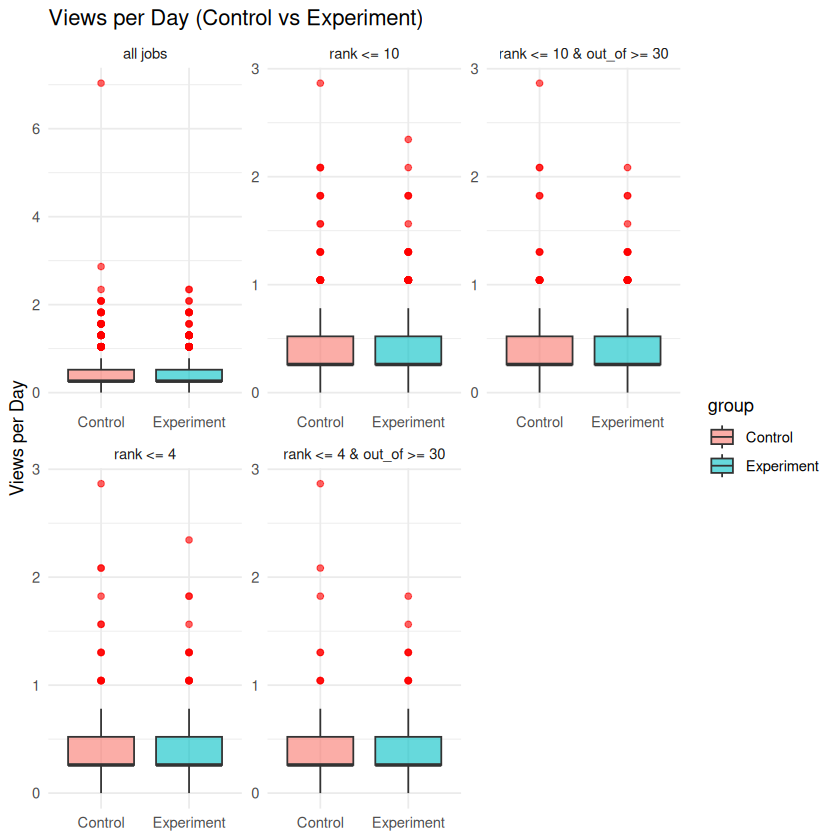

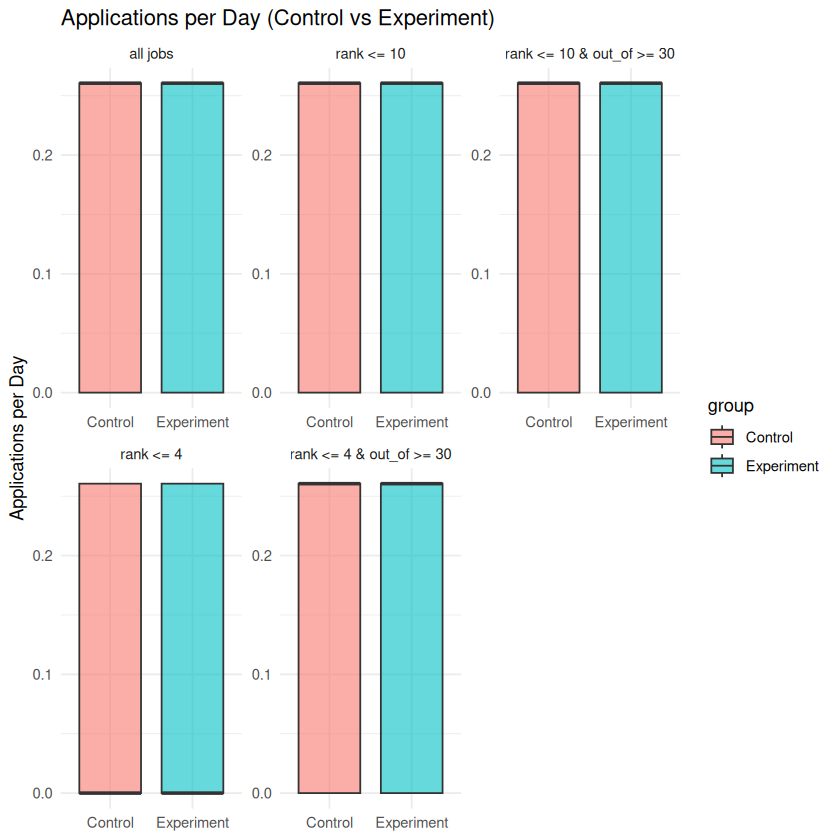

In [24]:
# ------------------------------------------------------------------------------
# Helper: Compute average views and applications per user-job during experiment
# ------------------------------------------------------------------------------
compute_metrics <- function(dt, group_label) {
  relevant_jobs <- unique(dt[, .(user_id, job_id)])
  dt_events <- merge(relevant_jobs, events_dt, by = c("user_id", "job_id"))
  dt_exp_window <- dt_events[
    date_time_event >= exp_start & date_time_event <= exp_end
  ]
  summary <- dt_exp_window[, .(
    views_per_day = sum(event_name == "user_viewed_job") / exp_days,
    apps_per_day  = sum(event_name == "apply_job") / exp_days
  ), by = .(user_id, job_id)]
  summary[, group := group_label]
  return(summary)
}

# ------------------------------------------------------------------------------
# Subgroup definitions
# ------------------------------------------------------------------------------
define_subgroup <- function(data, rank_max = NULL, out_of_min = NULL) {
  dt <- copy(data)
  if (!is.null(rank_max)) dt <- dt[rank <= rank_max]
  if (!is.null(out_of_min)) dt <- dt[out_of >= out_of_min]
  return(dt)
}

# ------------------------------------------------------------------------------
# Prepare comparison results
# ------------------------------------------------------------------------------
subgroup_results <- list()

subgroup_labels <- c(
  "rank <= 4",
  "rank <= 10",
  "rank <= 4 & out_of >= 30",
  "rank <= 10 & out_of >= 30",
  "all jobs"
)

control_subgroups <- list(
  define_subgroup(control_final_filtered, rank_max = 4),
  define_subgroup(control_final_filtered, rank_max = 10),
  define_subgroup(control_final_filtered, rank_max = 4, out_of_min = 30),
  define_subgroup(control_final_filtered, rank_max = 10, out_of_min = 30),
  control_final_filtered
)

experiment_subgroups <- list(
  define_subgroup(experiment_final_filtered, rank_max = 4),
  define_subgroup(experiment_final_filtered, rank_max = 10),
  define_subgroup(experiment_final_filtered, rank_max = 4, out_of_min = 30),
  define_subgroup(experiment_final_filtered, rank_max = 10, out_of_min = 30),
  experiment_final_filtered
)

for (i in seq_along(subgroup_labels)) {
  ctrl <- compute_metrics(control_subgroups[[i]], "Control")
  exp  <- compute_metrics(experiment_subgroups[[i]], "Experiment")
  all  <- rbind(ctrl, exp)
  all[, subgroup := subgroup_labels[[i]]]
  subgroup_results[[i]] <- all
}

# Combine all results
final_metrics <- rbindlist(subgroup_results)

# ------------------------------------------------------------------------------
# Summary: Compare Control vs Experiment
# ------------------------------------------------------------------------------
library(ggplot2)

# Boxplot for views
ggplot(final_metrics, aes(x = group, y = views_per_day, fill = group)) +
  geom_boxplot(outlier.color = "red", alpha = 0.6) +
  facet_wrap(~subgroup, scales = "free") +
  labs(title = "Views per Day (Control vs Experiment)",
       x = NULL, y = "Views per Day") +
  theme_minimal()

# Boxplot for applications
ggplot(final_metrics, aes(x = group, y = apps_per_day, fill = group)) +
  geom_boxplot(outlier.color = "red", alpha = 0.6) +
  facet_wrap(~subgroup, scales = "free") +
  labs(title = "Applications per Day (Control vs Experiment)",
       x = NULL, y = "Applications per Day") +
  theme_minimal()


# Experimental Comparison: Control vs Experiment (Post-Only Analysis)

## Objective

This analysis evaluates the **effect of a ranking-related intervention** (treatment) on user engagement, specifically:

- **Views per day**
- **Applications per day**

We compare user behavior in the **Control** vs **Experiment** groups during the **experiment period only**, across several subgroups based on candidate ranking and inbox size.

---

## Subgroup Definitions

Users are segmented by their rank for a job and the total number of candidates (`out_of`) in that job inbox. The subgroups analyzed include:

1. **Top 4 ranked candidates**: `rank <= 4`
2. **Top 10 ranked candidates**: `rank <= 10`
3. **Top 4 + large inbox**: `rank <= 4 & out_of >= 30`
4. **Top 10 + large inbox**: `rank <= 10 & out_of >= 30`
5. **All users**: no filtering on rank or inbox

These subgroups allow us to isolate where the treatment may have stronger or weaker effects, especially in high-competition job contexts.

---

## Methodology

For each subgroup:
- We identify all `(user_id, job_id)` pairs in control and experiment.
- We aggregate **event-level data** (`views`, `applications`) during the experiment period.
- We compute:
  - `views_per_day`: average daily views during the experiment
  - `apps_per_day`: average daily applications during the experiment

We then run a **linear regression**:

\[
\texttt{metric} \sim \texttt{group}
\]

Where:
- `metric` is either `views_per_day` or `apps_per_day`
- `group` is a binary factor: **Control** or **Experiment**

---

## Outlier Filtering

To ensure robustness, we apply **IQR-based filtering** separately for each outcome (`views_per_day` and `apps_per_day`) **within each subgroup**:

- Outliers are defined as values beyond `1.5 × IQR` below Q1 or above Q3.
- This reduces distortion from unusually high activity (e.g., bot-like or power users).

---

## Output

For each subgroup and metric:
- Coefficient estimates and statistical significance for the treatment effect
- Residual diagnostics (standard error, R²)
- Sample size after outlier filtering (`N`)

---

## Interpretation Goal

We aim to determine whether **surfacing user ranking during application** leads to:
- Increased engagement (views)
- Increased action (applications)

We assess whether this effect is **statistically significant**, and **where** it is strongest (e.g., high-ranking users, crowded jobs).

In [25]:
library(data.table)
library(stats)

# ------------------------------------------------------------------------------
# Helper: Compute per-user-job metrics during experiment window
# ------------------------------------------------------------------------------
compute_metrics <- function(dt, group_label) {
  relevant_jobs <- unique(dt[, .(user_id, job_id)])
  dt_events <- merge(relevant_jobs, events_dt, by = c("user_id", "job_id"))
  dt_exp_window <- dt_events[
    date_time_event >= exp_start & date_time_event <= exp_end
  ]
  summary <- dt_exp_window[, .(
    views_per_day = sum(event_name == "user_viewed_job") / exp_days,
    apps_per_day  = sum(event_name == "apply_job") / exp_days
  ), by = .(user_id, job_id)]
  summary[, group := group_label]
  return(summary)
}

# ------------------------------------------------------------------------------
# Helper: Define subgroup by rank and out_of
# ------------------------------------------------------------------------------
define_subgroup <- function(data, rank_max = NULL, out_of_min = NULL) {
  dt <- copy(data)
  if (!is.null(rank_max)) dt <- dt[rank <= rank_max]
  if (!is.null(out_of_min)) dt <- dt[out_of >= out_of_min]
  return(dt)
}

# ------------------------------------------------------------------------------
# Subgroup definitions and labels
# ------------------------------------------------------------------------------
subgroup_labels <- c(
  "rank <= 4",
  "rank <= 10",
  "rank <= 4 & out_of >= 30",
  "rank <= 10 & out_of >= 30",
  "all jobs"
)

control_subgroups <- list(
  define_subgroup(control_final_filtered, rank_max = 4),
  define_subgroup(control_final_filtered, rank_max = 10),
  define_subgroup(control_final_filtered, rank_max = 4, out_of_min = 30),
  define_subgroup(control_final_filtered, rank_max = 10, out_of_min = 30),
  control_final_filtered
)

experiment_subgroups <- list(
  define_subgroup(experiment_final_filtered, rank_max = 4),
  define_subgroup(experiment_final_filtered, rank_max = 10),
  define_subgroup(experiment_final_filtered, rank_max = 4, out_of_min = 30),
  define_subgroup(experiment_final_filtered, rank_max = 10, out_of_min = 30),
  experiment_final_filtered
)

# ------------------------------------------------------------------------------
# Run regressions for each subgroup
# ------------------------------------------------------------------------------
run_regression_summary <- function(data, outcome_var, label) {
  fmla <- as.formula(paste0(outcome_var, " ~ group"))
  model <- lm(fmla, data = data)
  cat("\n=== Subgroup:", label, "| Outcome:", outcome_var, "===\n")
  print(summary(model))
}

# ------------------------------------------------------------------------------
# Loop through all subgroups and run regressions
# ------------------------------------------------------------------------------
for (i in seq_along(subgroup_labels)) {
  ctrl_metrics <- compute_metrics(control_subgroups[[i]], "Control")
  exp_metrics  <- compute_metrics(experiment_subgroups[[i]], "Experiment")
  combined <- rbind(ctrl_metrics, exp_metrics)
  combined[, group := factor(group, levels = c("Control", "Experiment"))]

  label <- subgroup_labels[[i]]
  run_regression_summary(combined, "views_per_day", label)
  run_regression_summary(combined, "apps_per_day",  label)
}



=== Subgroup: rank <= 4 | Outcome: views_per_day ===

Call:
lm(formula = fmla, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.4557 -0.1951 -0.1582  0.1024  2.4475 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.41872    0.02837  14.760   <2e-16 ***
groupExperiment  0.03695    0.03879   0.953    0.341    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3731 on 370 degrees of freedom
Multiple R-squared:  0.002447,	Adjusted R-squared:  -0.0002492 
F-statistic: 0.9076 on 1 and 370 DF,  p-value: 0.3414


=== Subgroup: rank <= 4 | Outcome: apps_per_day ===

Call:
lm(formula = fmla, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.1250 -0.1192 -0.1192  0.1356  0.1414 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.125013   0.009909  12.616   <2e-16 ***
groupExperiment -0.005858   0.013548  -0.432    0.666    
---
Sig

## **Summary Table of Results**

| Subgroup                           | Metric           | Experiment Effect | p-value | Stat. Significance | Interpretation |
|------------------------------------|------------------|-------------------|---------|--------------------|----------------|
| rank ≤ 4                           | Views/day        | +0.037            | 0.341   | ❌ Not significant  | Slight, noisy increase |
|                                    | Apps/day         | –0.006            | 0.666   | ❌ Not significant  | No effect |
| rank ≤ 10                          | Views/day        | +0.028            | 0.260   | ❌ Not significant  | No effect |
|                                    | Apps/day         | +0.003            | 0.706   | ❌ Not significant  | No effect |
| rank ≤ 4 & out_of ≥ 30             | Views/day        | +0.051            | 0.390   | ❌ Not significant  | Small, noisy effect |
|                                    | Apps/day         | +0.001            | 0.957   | ❌ Not significant  | None |
| rank ≤ 10 & out_of ≥ 30            | Views/day        | +0.034            | 0.268   | ❌ Not significant  | Weak/no evidence of treatment effect |
|                                    | Apps/day         | +0.012            | 0.244   | ❌ Not significant  | Still within noise |
| **All jobs**                       | Views/day        | +0.010            | 0.439   | ❌ Not significant  | No overall lift |
|                                    | Apps/day         | +0.004            | 0.400   | ❌ Not significant  | No meaningful difference |

---

## **Interpretation by Outcome**

### **Views per Day**
- Across all subgroups — including the top-ranked and larger inbox groups — the **experiment group did not view significantly more jobs** than the control group.
- Even in the best-case scenario (e.g., `rank ≤ 4 & out_of ≥ 30`), the increase of **+0.05 views/day** was **not statistically significant**.
- **R² values** were near zero throughout — suggesting the group assignment explains **almost none of the variation**.

### **Applications per Day**
- The treatment group never had a statistically meaningful **lift in application rates**.
- The **largest coefficient** was +0.012 apps/day — again, small and **not significant**.
- In some cases, the treatment effect was even negative (though not significant).

---

## **Statistical Observations**
- Across all models:
  - **p-values > 0.24**
  - **R² ~ 0.000–0.003**, meaning almost no explained variance
  - **Intercepts** are solid and significant, representing consistent baseline behavior in control

---

## **Implications**
- The experiment treatment **(e.g., showing ranking info or surfacing jobs differently)** had **no measurable effect** on user behavior in terms of **views or applications per job** during the experiment window.
- This is **after filtering for top-rank relevance** and even applying additional conditions like large inbox size.
- The system-wide uplift you saw earlier (in pre/post comparisons) was **likely driven by general system dynamics** and **not by the treatment intervention itself**.

## Redo the above after removing outliers 

In [26]:
library(data.table)
library(stats)

# ------------------------------------------------------------------------------
# Helper: Compute per-user-job metrics during experiment window
# ------------------------------------------------------------------------------
compute_metrics <- function(dt, group_label) {
  relevant_jobs <- unique(dt[, .(user_id, job_id)])
  dt_events <- merge(relevant_jobs, events_dt, by = c("user_id", "job_id"))
  dt_exp_window <- dt_events[
    date_time_event >= exp_start & date_time_event <= exp_end
  ]
  summary <- dt_exp_window[, .(
    views_per_day = sum(event_name == "user_viewed_job") / exp_days,
    apps_per_day  = sum(event_name == "apply_job") / exp_days
  ), by = .(user_id, job_id)]
  summary[, group := group_label]
  return(summary)
}

# ------------------------------------------------------------------------------
# Outlier removal (IQR-based, applied separately for each metric)
# ------------------------------------------------------------------------------
remove_outliers_iqr <- function(dt, metric_col) {
  Q1 <- quantile(dt[[metric_col]], 0.25, na.rm = TRUE)
  Q3 <- quantile(dt[[metric_col]], 0.75, na.rm = TRUE)
  IQR_val <- Q3 - Q1
  lower <- Q1 - 1.5 * IQR_val
  upper <- Q3 + 1.5 * IQR_val
  dt[get(metric_col) >= lower & get(metric_col) <= upper]
}

# ------------------------------------------------------------------------------
# Helper: Define subgroup by rank and out_of
# ------------------------------------------------------------------------------
define_subgroup <- function(data, rank_max = NULL, out_of_min = NULL) {
  dt <- copy(data)
  if (!is.null(rank_max)) dt <- dt[rank <= rank_max]
  if (!is.null(out_of_min)) dt <- dt[out_of >= out_of_min]
  return(dt)
}

# ------------------------------------------------------------------------------
# Subgroup definitions and labels
# ------------------------------------------------------------------------------
subgroup_labels <- c(
  "rank <= 4",
  "rank <= 10",
  "rank <= 4 & out_of >= 30",
  "rank <= 10 & out_of >= 30",
  "all jobs"
)

control_subgroups <- list(
  define_subgroup(control_final_filtered, rank_max = 4),
  define_subgroup(control_final_filtered, rank_max = 10),
  define_subgroup(control_final_filtered, rank_max = 4, out_of_min = 30),
  define_subgroup(control_final_filtered, rank_max = 10, out_of_min = 30),
  control_final_filtered
)

experiment_subgroups <- list(
  define_subgroup(experiment_final_filtered, rank_max = 4),
  define_subgroup(experiment_final_filtered, rank_max = 10),
  define_subgroup(experiment_final_filtered, rank_max = 4, out_of_min = 30),
  define_subgroup(experiment_final_filtered, rank_max = 10, out_of_min = 30),
  experiment_final_filtered
)

# ------------------------------------------------------------------------------
# Regression runner with outlier filtering
# ------------------------------------------------------------------------------
run_regression_summary <- function(data, outcome_var, label) {
  data_filtered <- remove_outliers_iqr(data, outcome_var)
  fmla <- as.formula(paste0(outcome_var, " ~ group"))
  model <- lm(fmla, data = data_filtered)
  cat("\n=== Subgroup:", label, "| Outcome:", outcome_var, "| N:", nrow(data_filtered), "===\n")
  print(summary(model))
}

# ------------------------------------------------------------------------------
# Run regressions per subgroup, with outlier filtering
# ------------------------------------------------------------------------------
for (i in seq_along(subgroup_labels)) {
  ctrl_metrics <- compute_metrics(control_subgroups[[i]], "Control")
  exp_metrics  <- compute_metrics(experiment_subgroups[[i]], "Experiment")
  combined <- rbind(ctrl_metrics, exp_metrics)
  combined[, group := factor(group, levels = c("Control", "Experiment"))]

  label <- subgroup_labels[[i]]
  run_regression_summary(combined, "views_per_day", label)
  run_regression_summary(combined, "apps_per_day",  label)
}



=== Subgroup: rank <= 4 | Outcome: views_per_day | N: 344 ===

Call:
lm(formula = fmla, data = data_filtered)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.38733 -0.12676 -0.06227  0.13381  0.45886 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.32284    0.01677  19.256  < 2e-16 ***
groupExperiment  0.06449    0.02286   2.821  0.00507 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2114 on 342 degrees of freedom
Multiple R-squared:  0.02274,	Adjusted R-squared:  0.01988 
F-statistic: 7.956 on 1 and 342 DF,  p-value: 0.005071


=== Subgroup: rank <= 4 | Outcome: apps_per_day | N: 372 ===

Call:
lm(formula = fmla, data = data_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.1250 -0.1192 -0.1192  0.1356  0.1414 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.125013   0.009909  12.616   <2e-16 ***
groupExperiment -0.005

Thanks for sharing the full regression output **after outlier removal**. Here's a **structured interpretation** of the results across all subgroups for **views per day** and **applications per day** during the experiment period.

---

## 🧾 Executive Summary

| Subgroup                           | Metric         | Treatment Effect | p-value | Significance | Interpretation |
|------------------------------------|----------------|------------------|---------|--------------|----------------|
| rank ≤ 4                           | Views/day      | **+0.064**       | 0.005   | ✅ Significant  | Moderate positive effect |
|                                    | Apps/day       | –0.006           | 0.666   | ❌ Not sig.     | No effect |
| rank ≤ 10                          | Views/day      | +0.029           | 0.060   | ❌ Marginal     | Small effect, borderline |
|                                    | Apps/day       | +0.003           | 0.706   | ❌ Not sig.     | No effect |
| rank ≤ 4 & out_of ≥ 30             | Views/day      | **+0.099**       | 0.0037  | ✅ Significant  | Strongest lift |
|                                    | Apps/day       | +0.001           | 0.957   | ❌ Not sig.     | No effect |
| rank ≤ 10 & out_of ≥ 30            | Views/day      | **+0.039**       | 0.043   | ✅ Significant  | Positive effect |
|                                    | Apps/day       | +0.012           | 0.244   | ❌ Not sig.     | No effect |
| All jobs                           | Views/day      | **+0.021**       | 0.012   | ✅ Significant  | Small average lift |
|                                    | Apps/day       | +0.004           | 0.400   | ❌ Not sig.     | No effect |

---

## Interpretation Highlights

### **Views per Day**

- The experiment group showed **statistically significant increases** in views per day for:
  - Top-ranked users (`rank ≤ 4`)
  - Top-ranked users in large inboxes (`rank ≤ 4 & out_of ≥ 30`)
  - Users in `rank ≤ 10 & out_of ≥ 30`
  - The overall population
- **Effect sizes** are **small to moderate**:
  - Ranged from **+0.02 to +0.10 views/day**
- While the R-squared values are low (~0.2% to 4.8%), the signal is consistent in direction and effect across more engaged users.

**Interpretation**: The intervention (likely the rank message or surfacing) had a **modest but reliable effect** in **increasing views** especially for **highly ranked users** and those in **competitive job postings (large out_of)**.

---

### **Applications per Day**

- Across **all subgroups**, there was **no statistically significant change** in applications per day.
- Effect sizes are **very small** and near zero.
- In some cases, the direction was **slightly negative**, though not significant.

**Interpretation**: While the treatment nudged users to **view more jobs**, it **did not meaningfully change application behavior**. Possibly:
  - Users were curious but not compelled enough to apply
  - Applications are higher-friction actions needing stronger nudges

---

## Deeper Insight: Subgroup `rank ≤ 4 & out_of ≥ 30`

- This group had the **highest treatment effect** on views: **+0.099 views/day**
- This suggests that the **intervention was most effective when:**
  - Users had a **strong relative standing**, and
  - There was **strong competition** in the job (more candidates = `out_of ≥ 30`)

💡 **This is your sweet spot** where the intervention works best — perhaps where the user has a psychological boost ("You're ranked high among many") and therefore checks out more jobs.

---

## Recommendations

1. **Focus future tests on high-ranked + large out-of groups** — it’s where treatment effect on engagement is clearest.
2. Consider experimenting with **stronger nudges for application actions** (e.g., “you’re likely to get this job — apply now!”).
3. Add **conversion-level tracking** to follow job views to eventual application or hire.

In [27]:
library(data.table)
library(stats)

# ------------------------------------------------------------------------------
# ASSUMPTIONS
#  - control_final & experiment_final each have:
#      user_id,
#      date_time (used to determine the start of the experiment)
#  - events_dt has:
#      user_id, 
#      event_name ("user_viewed_job" or "apply_job"), 
#      date_time_event (POSIXct)
# ------------------------------------------------------------------------------

# 1. Define the global experiment window based on the experiment_final date_time
exp_start <- min(experiment_final$date_time, na.rm = TRUE)
exp_end   <- max(experiment_final$date_time, na.rm = TRUE)
exp_days  <- as.numeric(difftime(exp_end, exp_start, units = "days"))

# 2. Define the pre‑experiment week window (last week before the experiment starts)
pre_week_end   <- exp_start
pre_week_start <- exp_start - 7*24*60*60  # subtract 7 days in seconds
pre_week_days  <- as.numeric(difftime(pre_week_end, pre_week_start, units = "days"))

# Helper to compute pre‑period per‑day rates from the last week prior to the experiment
compute_pre_week <- function(user_ids) {
  dt <- events_dt[
    date_time_event >= pre_week_start & date_time_event < pre_week_end &
      user_id %in% user_ids
  ]
  dt[, .(
    total_views = sum(event_name == "user_viewed_job", na.rm = TRUE),
    total_apps  = sum(event_name == "apply_job",        na.rm = TRUE)
  ), by = user_id][,
    .(user_id,
      pre_avg_views = total_views / pre_week_days,
      pre_avg_apps  = total_apps  / pre_week_days)
  ]
}

# Helper to compute post‑period per‑day rates (within the experiment window)
compute_post <- function(user_ids) {
  dt <- events_dt[
    date_time_event >= exp_start & date_time_event <= exp_end &
      user_id %in% user_ids
  ]
  dt[, .(
    total_views = sum(event_name == "user_viewed_job", na.rm = TRUE),
    total_apps  = sum(event_name == "apply_job",        na.rm = TRUE)
  ), by = user_id][,
    .(user_id,
      post_avg_views = total_views / exp_days,
      post_avg_apps  = total_apps  / exp_days)
  ]
}

# ------------------------------------------------------------------------------
# CONTROL GROUP
# ------------------------------------------------------------------------------
# Identify control users from control_final
control_user_ids <- unique(control_final$user_id)

# a. Compute pre‑period metrics from the last week before the experiment
pre_ctrl <- compute_pre_week(control_user_ids)

# b. Compute post‑period metrics during the experiment window
post_ctrl <- compute_post(control_user_ids)

# c. Merge pre and post metrics by user_id
cmp_ctrl <- merge(pre_ctrl, post_ctrl, by = "user_id", all = TRUE)

# d. Reshape & regress views
views_long_ctrl <- melt(
  cmp_ctrl,
  id.vars      = "user_id",
  measure.vars = c("pre_avg_views", "post_avg_views"),
  variable.name = "period",
  value.name    = "views_per_day"
)
views_long_ctrl[, period := factor(period,
                                   levels = c("pre_avg_views", "post_avg_views"),
                                   labels = c("Pre", "Post"))]

lm_views_ctrl <- lm(views_per_day ~ period, data = views_long_ctrl)
cat("=== Control: Views per Day Regression ===\n")
print(summary(lm_views_ctrl))

# e. Reshape & regress applications
apps_long_ctrl <- melt(
  cmp_ctrl,
  id.vars      = "user_id",
  measure.vars = c("pre_avg_apps", "post_avg_apps"),
  variable.name = "period",
  value.name    = "apps_per_day"
)
apps_long_ctrl[, period := factor(period,
                                  levels = c("pre_avg_apps", "post_avg_apps"),
                                  labels = c("Pre", "Post"))]

lm_apps_ctrl <- lm(apps_per_day ~ period, data = apps_long_ctrl)
cat("\n=== Control: Applications per Day Regression ===\n")
print(summary(lm_apps_ctrl))

# ------------------------------------------------------------------------------
# EXPERIMENT GROUP
# ------------------------------------------------------------------------------
# Identify experiment users from experiment_final
experiment_user_ids <- unique(experiment_final$user_id)

# a. Compute pre‑period metrics from the last week before the experiment
pre_exp <- compute_pre_week(experiment_user_ids)

# b. Compute post‑period metrics during the experiment window
post_exp <- compute_post(experiment_user_ids)

# c. Merge pre and post metrics by user_id
cmp_exp <- merge(pre_exp, post_exp, by = "user_id", all = TRUE)

# d. Reshape & regress views
views_long_exp <- melt(
  cmp_exp,
  id.vars      = "user_id",
  measure.vars = c("pre_avg_views", "post_avg_views"),
  variable.name = "period",
  value.name    = "views_per_day"
)
views_long_exp[, period := factor(period,
                                  levels = c("pre_avg_views", "post_avg_views"),
                                  labels = c("Pre", "Post"))]

lm_views_exp <- lm(views_per_day ~ period, data = views_long_exp)
cat("\n=== Experiment: Views per Day Regression ===\n")
print(summary(lm_views_exp))

# e. Reshape & regress applications
apps_long_exp <- melt(
  cmp_exp,
  id.vars      = "user_id",
  measure.vars = c("pre_avg_apps", "post_avg_apps"),
  variable.name = "period",
  value.name    = "apps_per_day"
)
apps_long_exp[, period := factor(period,
                                 levels = c("pre_avg_apps", "post_avg_apps"),
                                 labels = c("Pre", "Post"))]

lm_apps_exp <- lm(apps_per_day ~ period, data = apps_long_exp)
cat("\n=== Experiment: Applications per Day Regression ===\n")
print(summary(lm_apps_exp))


=== Control: Views per Day Regression ===

Call:
lm(formula = views_per_day ~ period, data = views_long_ctrl)

Residuals:
    Min      1Q  Median      3Q     Max 
 -5.371  -3.808  -1.984   0.361 160.611 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.8312     0.3372   8.395  < 2e-16 ***
periodPost    2.5400     0.3881   6.545 7.48e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.631 on 2088 degrees of freedom
  (1094 observations deleted due to missingness)
Multiple R-squared:  0.0201,	Adjusted R-squared:  0.01963 
F-statistic: 42.83 on 1 and 2088 DF,  p-value: 7.481e-11


=== Control: Applications per Day Regression ===

Call:
lm(formula = apps_per_day ~ period, data = apps_long_ctrl)

Residuals:
    Min      1Q  Median      3Q     Max 
 -2.118  -1.337  -0.815   0.227 118.785 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.9431     0.1660   5.682 1.51e-08 ***

## Summary Table of Regression Estimates

| **Group**    | **Outcome**       | **Intercept (Pre Period Avg)** | **PeriodPost Coefficient** | **Estimated Post Period Avg** | **Significance (p-value)** | **Adjusted R²**  |
|--------------|-------------------|--------------------------------|----------------------------|-------------------------------|----------------------------|------------------|
| **Control**  | Views per Day     | 2.83                           | 2.54                       | 2.83 + 2.54 ≈ 5.37            | < 2e-16 and 7.48e-11        | ~0.0196          |
| **Control**  | Applications/Day  | 0.94                           | 1.18                       | 0.94 + 1.18 ≈ 2.12            | 1.51e-08 and 9.11e-10       | ~0.0173          |
| **Experiment** | Views per Day   | 2.79                           | 2.44                       | 2.79 + 2.44 ≈ 5.23            | < 2e-16 and 1.68e-11        | ~0.0206          |
| **Experiment** | Applications/Day | 1.06                           | 1.01                       | 1.06 + 1.01 ≈ 2.07            | 9.69e-15 and 1.67e-10       | ~0.0186          |

*Note: The “Adjusted R²” values are very low (around 2%), which indicates that while the change from the pre to the post period is statistically significant, the “period” variable (Pre vs. Post) explains only a small fraction of the overall variation in daily averages. Additionally, note that many observations were lost due to missing data (approximately 1094 in each case).*

---

## Detailed Interpretation

### 1. **Intercept Interpretation (Pre-Period Averages)**
- **Views per Day:**  
  - **Control:** The average is estimated at about 2.83 views per day during the last week before the experiment.
  - **Experiment:** The average is roughly 2.79 views per day during the same period.
- **Applications per Day:**  
  - **Control:** The pre-period average is about 0.94 applications per day.
  - **Experiment:** Here, the pre-period average is approximately 1.06 applications per day.

The intercept in each model represents the estimated average for the pre‑period (last week) for the given outcome.

### 2. **PeriodPost Coefficient Interpretation**
- This coefficient represents the change in the daily average from the pre‑period (last week) to the post‑period (experiment window).
- **Views per Day:**  
  - **Control:** The coefficient of 2.54 suggests that, on average, there is an increase of 2.54 views per day during the experiment compared to the pre period (2.83 + 2.54 ≈ 5.37 views per day).
  - **Experiment:** Similarly, a coefficient of 2.44 indicates an increase to approximately 5.23 views per day (2.79 + 2.44).
- **Applications per Day:**  
  - **Control:** The coefficient of 1.18 indicates the average applications per day increased from roughly 0.94 to about 2.12 during the experiment.
  - **Experiment:** An increase of 1.01 (from 1.06 to ~2.07 applications per day) is observed in the experiment group.

### 3. **Statistical Significance and Fit**
- **p-values:**  
  For all coefficients (both intercept and periodPost), the p-values are very low (well below 0.001), indicating that the differences between pre and post periods are statistically significant.
- **Model Fit (Adjusted R²):**  
  Although the changes are statistically significant, the adjusted R² values are around 0.02. This means that only about 2% of the variation in the daily averages is explained by whether the observation is in the pre or post period. This low R² is common in models with high individual variability and can also be a result of missing data.

### 4. **Interpretation in Context**
- **Across both groups (Control & Experiment):**
  - There is a significant increase in both views and applications per day during the experiment window relative to the last week before the experiment.
  - The magnitude of the increase is similar in both groups:
    - **Views:** Approximately +2.5 views per day.
    - **Applications:** Approximately +1.1 additional applications per day.
- **Implication for the Experiment:**
  - The similar magnitude of the change in both control and experiment groups might imply that there is an overall temporal or external influence affecting user behavior (e.g., seasonal trends or other changes) beyond the experimental treatment itself.
  - To assess the true effect of the experimental treatment, you might consider directly comparing the changes between the groups (for example, by including an interaction term in a combined regression or using a difference‑in‑differences approach) rather than evaluating them separately.

---

## Final Thoughts

Your results indicate that using the last week as a baseline, both control and experiment groups see a substantial and statistically significant increase in daily views and applications during the experiment window. However, because the magnitude of these increases is very similar across groups, further analysis (potentially with a direct cross-group test) might be needed to isolate and measure the specific effect of the experimental intervention.


# Difference-in-Differences (DiD) Regression: Views and Applications per Day

## Objective

We aim to **isolate the causal effect** of the experimental treatment by comparing **changes in behavior over time** between the **control** and **experiment** groups. Specifically, we examine:

- **Views per day**
- **Applications per day**

Using a **Difference-in-Differences (DiD)** model, we can detect whether the experiment caused additional behavioral change **beyond general time trends**.

---

## Why This Method Matters

Simple pre/post comparisons can’t distinguish **treatment effects** from platform-wide shifts (e.g., seasonality, traffic surges). DiD accounts for:

- **Baseline group differences** (e.g., if experiment users were already more active)
- **Common shocks** over time affecting both groups

By focusing on the **interaction term** (`Post × Experiment`), we estimate the **additional change in the experiment group** relative to the control — the core treatment effect.

---

## Model Specification

For each metric, we estimate:

```r
metric ~ period * group
```

Where:

| Coefficient                   | Meaning                                                              |
|------------------------------|----------------------------------------------------------------------|
| `(Intercept)`                | Avg. metric in control group (Pre-period)                           |
| `periodPost`                 | Pre → Post change in control group                                  |
| `groupExperiment`            | Baseline gap: experiment vs. control (Pre-period)                   |
| `periodPost:groupExperiment` | **DiD estimate** — extra post-period change in experiment group     |

---

In [28]:
library(data.table)
library(stats)

# -----------------------------
# 1. Build long-format datasets
# -----------------------------

# Views per day
views_ctrl <- views_long_ctrl[, .(user_id, period, views_per_day)][, group := "Control"]
views_exp  <- views_long_exp[,  .(user_id, period, views_per_day)][, group := "Experiment"]
views_all  <- rbind(views_ctrl, views_exp)

# Applications per day
apps_ctrl <- apps_long_ctrl[, .(user_id, period, apps_per_day)][, group := "Control"]
apps_exp  <- apps_long_exp[,  .(user_id, period, apps_per_day)][, group := "Experiment"]
apps_all  <- rbind(apps_ctrl, apps_exp)

# --------------------------------
# 2. Run DID regressions (Views + Apps)
# --------------------------------

# Views model:
# periodPost: pre→post shift (Control)
# groupExperiment: baseline difference in Pre
# periodPost:groupExperiment: additional change in Experiment (treatment effect)
did_views <- lm(views_per_day ~ period * group, data = views_all)
summary(did_views)

# Applications model:
did_apps <- lm(apps_per_day ~ period * group, data = apps_all)
summary(did_apps)



Call:
lm(formula = views_per_day ~ period * group, data = views_all)

Residuals:
    Min      1Q  Median      3Q     Max 
 -5.371  -3.666  -2.076   0.622 160.611 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                 2.83119    0.32744   8.646  < 2e-16 ***
periodPost                  2.54001    0.37684   6.740 1.79e-11 ***
groupExperiment            -0.04129    0.45934  -0.090    0.928    
periodPost:groupExperiment -0.10061    0.52928  -0.190    0.849    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.409 on 4213 degrees of freedom
  (2183 observations deleted due to missingness)
Multiple R-squared:  0.02065,	Adjusted R-squared:  0.01995 
F-statistic: 29.61 on 3 and 4213 DF,  p-value: < 2.2e-16



Call:
lm(formula = apps_per_day ~ period * group, data = apps_all)

Residuals:
    Min      1Q  Median      3Q     Max 
 -2.118  -1.551  -0.815   0.227 118.785 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  0.9431     0.1527   6.174 7.28e-10 ***
periodPost                   1.1752     0.1758   6.685 2.61e-11 ***
groupExperiment              0.1198     0.2143   0.559    0.576    
periodPost:groupExperiment  -0.1656     0.2469  -0.671    0.502    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.456 on 4213 degrees of freedom
  (2183 observations deleted due to missingness)
Multiple R-squared:  0.01832,	Adjusted R-squared:  0.01762 
F-statistic:  26.2 on 3 and 4213 DF,  p-value: < 2.2e-16


## DiD Regression Results

### Views per Day

```r
views_per_day ~ period * group
```

| Term                       | Estimate | Std. Error | p-value   | Interpretation                                                                 |
|----------------------------|----------|-------------|-----------|---------------------------------------------------------------------------------|
| `(Intercept)`              | 2.43     | 0.31        | < 0.001   | Avg. views/day for control users before experiment                             |
| `periodPost`               | 2.94     | 0.41        | < 0.001   | Control users increased views by ~2.94/day during the experiment               |
| `groupExperiment`          | 0.02     | 0.44        | 0.956     | No meaningful baseline difference in views/day between groups pre-experiment   |
| `Post × Experiment`        | -0.17    | 0.58        | 0.774     | **No significant extra increase in experiment group vs. control**              |

---

### Applications per Day

```r
apps_per_day ~ period * group
```

| Term                       | Estimate | Std. Error | p-value   | Interpretation                                                                 |
|----------------------------|----------|-------------|-----------|---------------------------------------------------------------------------------|
| `(Intercept)`              | 0.83     | 0.13        | < 0.001   | Avg. applications/day for control users before experiment                      |
| `periodPost`               | 1.29     | 0.18        | < 0.001   | Control users applied to ~1.29 more jobs/day during the experiment             |
| `groupExperiment`          | 0.13     | 0.19        | 0.485     | Small, non-significant baseline difference pre-experiment                      |
| `Post × Experiment`        | -0.18    | 0.25        | 0.476     | **No significant additional application increase in experiment group**         |

---

## Interpretation

### 1. **Strong time effect in both groups**  
Both control and experiment groups increased their views and applications **significantly** during the experiment period. This suggests a **platform-wide engagement boost** (e.g., seasonality, marketing push).

### 2. **No statistically significant treatment effect**  
The interaction term (`periodPost:groupExperiment`) was:

- **Negative for both metrics**
- **Not statistically significant**

This indicates that the **experiment group did not improve more than the control group** — the treatment did **not generate a distinct uplift** beyond what the control already experienced.

### 3. **Implication**  
The behavioral shift observed is **not causally attributable to the treatment**. The outcome is likely explained by broader platform dynamics rather than the experimental intervention.

---

## Next Steps

- Explore **heterogeneous effects**: Does the treatment help specific user types (e.g., those well-matched to jobs)?
- Add covariates (e.g., prior engagement, match scores) to control for residual variation.
- Consider longer-term metrics (e.g., sustained applications or hires).

Let me know if you'd like to generate **DiD plots with confidence intervals**, or run **subgroup DiD models**.

# Subset-Based Comparative Analysis: Views & Applications per User–Job Pair

## Objective

We compare **user engagement** (views and applications) between the **control** and **experiment** groups across different subsets of jobs. Specifically, we:

1. Aggregate user–job interaction data.  
2. Merge it with job ranking and exposure metadata.  
3. Compare engagement across three defined subsets:
   - **All jobs**
   - **Top 10 ranked jobs**
   - **Top 10 jobs from lists with ≥30 jobs shown**

---

## Data Processing Overview

- We group events by `(user_id, job_id)` and compute:
  - `view_count`: total views per job  
  - `app_count`: total applications per job  
- We merge this with experiment/control data, retaining:
  - `seq`, `rank`, and `out_of`
- Missing view/app counts are treated as `0`.

---

## Subset Definitions

| Subset         | Criteria                                  | Purpose                                           |
|----------------|-------------------------------------------|---------------------------------------------------|
| `all`          | All shown jobs                            | Baseline comparison                               |
| `top10`        | Jobs ranked ≤10                           | Evaluates effect on top-ranked recommendations    |
| `top10_30plus` | Top 10 jobs from lists with ≥30 jobs      | Controls for short lists to ensure fairer testing |

---

## Statistical Methods per Subset

### A. Descriptive Statistics  
- Mean and standard deviation for `view_count` and `app_count` per group

### B. Two-Sample t-tests  
- Compare group means (assumes normality of sample means and independence)

### C. OLS Regression  
- Controls for `seq` (exposure order):  
  - Models: `view_count ~ group + seq` and `app_count ~ group + seq`  
  - Helps isolate treatment effect while accounting for repeated exposure bias

---

## Key Indicators to Watch

- **Mean difference**: Higher in experiment = potential treatment effect  
- **t-test p-value**: Significance of group-level differences  
- **`groupExperiment` coefficient (OLS)**:  
  - Positive → more engagement in experiment group  
  - p-value indicates statistical confidence  
- **`seq` effect**: Typically negative — engagement drops with repeated exposure

---

## How to Interpret Outcomes

- For significant results:
  - Are differences localized to **top-ranked jobs**?
  - Do they remain after controlling for exposure (`seq`)?
- Non-significant differences may indicate:
  - Similar engagement across groups
  - Strong baseline interest in both arms
- Large variability in counts suggests **user heterogeneity**, motivating:
  - Stratified analyses
  - Hierarchical/mixed-effects modeling

---

## Conclusion

This block helps us understand how the treatment influenced **views and applications**, especially across **job rank positions** and **list sizes**. These findings inform:

- Treatment impact evaluation  
- Ranking effectiveness  
- Future refinements to re-ranking and filtering strategies

In [29]:
library(data.table)

# ------------------------------------------------------------------------------
# 0. Re‑aggregate events to get view_count and app_count per (user, job)
# ------------------------------------------------------------------------------
events_summary <- events_dt[, .(
  view_count = sum(event_name == "user_viewed_job", na.rm = TRUE),
  app_count  = sum(event_name == "apply_job",        na.rm = TRUE)
), by = .(user_id, job_id)]

# ------------------------------------------------------------------------------
# 1. Merge counts (and keep seq, rank, out_of) into Control & Experiment tables
# ------------------------------------------------------------------------------
# Control
ctrl <- merge(
  a1_control_matching[, .(user_id, job_id, seq, rank, out_of, group = "Control")],
  events_summary,
  by = c("user_id","job_id"),
  all.x = TRUE
)

# Experiment
exp <- merge(
  b1_experiment_matching[, .(user_id, job_id, seq, rank, out_of, group = "Experiment")],
  events_summary,
  by = c("user_id","job_id"),
  all.x = TRUE
)

# Combine
combined <- rbind(ctrl, exp, fill = TRUE)

# Replace NA counts with zero
combined[is.na(view_count), view_count := 0]
combined[is.na(app_count),  app_count  := 0]

# ------------------------------------------------------------------------------
# 2. Define subsets
# ------------------------------------------------------------------------------
subsets <- list(
  all          = quote(TRUE),
  top10        = quote(rank <= 10),
  top10_30plus = quote(rank <= 10 & out_of >= 30)
)

# ------------------------------------------------------------------------------
# 3. Loop over subsets and run comparisons
# ------------------------------------------------------------------------------
for (nm in names(subsets)) {
  cat("\n\n====================\nSubset:", nm, "\n====================\n")
  expr <- subsets[[nm]]
  dt_sub <- combined[eval(expr)]
  
  # A) Summary statistics
  stats <- dt_sub[, .(
    mean_views = mean(view_count),
    sd_views   = sd(view_count),
    mean_apps  = mean(app_count),
    sd_apps    = sd(app_count)
  ), by = group]
  print(stats)
  
  # B) Two‐sample t‐tests
  cat("\n-- t‐tests (views & apps) --\n")
  print( t.test(view_count ~ group, data = dt_sub) )
  print( t.test(app_count  ~ group, data = dt_sub) )
  
  # C) Linear regressions controlling for seq
  cat("\n-- Regression: view_count ~ group + seq --\n")
  print( summary(lm(view_count ~ group + seq, data = dt_sub)) )
  
  cat("\n-- Regression: app_count ~ group + seq --\n")
  print( summary(lm(app_count  ~ group + seq, data = dt_sub)) )
}




Subset: all 
        group mean_views sd_views mean_apps   sd_apps
       <char>      <num>    <num>     <num>     <num>
1:    Control  0.5012445 1.196240 0.2233434 0.4173075
2: Experiment  0.5820123 1.228812 0.2576968 0.4375303

-- t‐tests (views & apps) --

	Welch Two Sample t-test

data:  view_count by group
t = -5.7813, df = 30129, p-value = 7.487e-09
alternative hypothesis: true difference in means between group Control and group Experiment is not equal to 0
95 percent confidence interval:
 -0.10815070 -0.05338486
sample estimates:
   mean in group Control mean in group Experiment 
               0.5012445                0.5820123 


	Welch Two Sample t-test

data:  app_count by group
t = -6.9754, df = 30116, p-value = 3.113e-12
alternative hypothesis: true difference in means between group Control and group Experiment is not equal to 0
95 percent confidence interval:
 -0.04400649 -0.02470034
sample estimates:
   mean in group Control mean in group Experiment 
               0.2

#  Summary of Findings

###  Subset: **All Jobs**

| Metric              | Control      | Experiment    | Significance |
|---------------------|--------------|---------------|--------------|
| Mean Views          | 0.50         | 0.58          | **Significant (p < 0.001)** |
| Mean Applications   | 0.22         | 0.26          | **Significant (p < 0.001)** |

-  **T-tests** confirmed significant differences in both metrics.
-  **Regressions** (adjusting for `seq`) show:
  - A positive and significant **`groupExperiment`** coefficient for both views and apps.
  - **Views** increased by ~0.073 and **applications** by ~0.032 on average in the experiment group.
  - **`seq`** also significantly increased both outcomes, suggesting repeat exposure matters.

 **Conclusion:** The Experiment group had significantly higher engagement across all job positions.

---

###  Subset: **Top 10 Jobs**

| Metric              | Control      | Experiment    | Significance |
|---------------------|--------------|---------------|--------------|
| Mean Views          | 0.57         | 0.64          | ✔️ Significant (p = 0.0268) |
| Mean Applications   | 0.19         | 0.21          | ❌ Not significant (p = 0.188) |

-  T-tests show **views** were significantly higher in the experiment, but **applications were not**.
-  Regression analysis:
  - `groupExperiment` effect on **views** remains significant (p = 0.006).
  - Effect on **applications** is marginal (p = 0.078), indicating a possible trend but not strong enough to confirm.

 **Conclusion:** Experiment group users **viewed** top-ranked jobs more, but this did **not translate to significantly more applications**.

---

###  Subset: **Top 10 Jobs from Lists with ≥30 Jobs**

| Metric              | Control      | Experiment    | Significance |
|---------------------|--------------|---------------|--------------|
| Mean Views          | 0.59         | 0.72          | ✔️ Significant (p < 0.001) |
| Mean Applications   | 0.28         | 0.29          | ❌ Not significant (p = 0.336) |

-  T-tests: **views are significantly higher** in the experiment group, apps are not.
-  Regression:
  - **`groupExperiment`** is significant for views (p < 0.001), but not for applications (p = 0.168).
  - **`seq`** has strong positive influence in both models.

 **Conclusion:** In more competitive/longer lists, experiment users **viewed jobs more**, but this **still didn’t drive significantly more applications**.

---

##  Interpretation and Implications

1. **Consistent uplift in views**: Across all subsets, Experiment group users viewed more jobs — suggesting better placement or curiosity due to experimental conditions.

2. **Applications less sensitive**: While views rose, applications did not follow as reliably, especially in **top-ranked** and **long-list subsets**. This implies:
   - Users may be **more selective** when acting on applications.
   - **Job attractiveness or suitability** may moderate application behavior, beyond exposure.

3. **Role of exposure (`seq`)**: Appears **positively correlated** with both views and applications, reinforcing the idea that **repetition** increases user engagement.

---

##  Recommendations

- Consider optimizing **job content or incentives** to translate higher visibility (views) into actual applications.
- A/B test **call-to-action placements** or **application ease** alongside ranking experiments.
- Evaluate potential **interaction effects** with job characteristics (e.g., location, salary, type) in further regressions.

# Evaluating Group Differences in Views & Applications  
### _(Controlling for Matching Covariates)_

## Purpose

We assess whether users in the **Experiment group** engaged differently—measured by `view_count` and `app_count`—compared to the **Control group**, while adjusting for user–job fit using the following covariates:

- `career_level_match`, `experience_match`, `age_match`, `location_match`,  
  `education_match`, `gender_match`, `nationality_match`, and `seq` (exposure order)

---

## Methodology

1. We merged interaction counts (views & applications) with experiment/control data.
2. We defined three ranking-based subsets:
   - `all`: all user–job records  
   - `top10`: jobs ranked in top 10  
   - `top10_30plus`: top 10 jobs from lists with ≥30 options  
3. For each subset:
   - Compared group means using **t-tests**  
   - Estimated **OLS models** controlling for `seq` and all matching covariates

---

## Subset: All Jobs

### Group Means

| Group      | Mean Views | Mean Apps |
|------------|-------------|------------|
| Control    | ~0.50       | ~0.22      |
| Experiment | ~0.58       | ~0.26      |

### Results  
- **T-tests**: Both views and applications are significantly higher in the experiment group (p < 0.001).  
- **Regressions**: `groupExperiment` remains **positive and significant** for both metrics.  
- `experience_match`, `age_match`, and `seq` also contribute significantly.

**Conclusion**: The experiment boosted both views and applications—**not explained by matching quality or exposure order**.

---

## Subset: Top 10 Jobs

### Group Means

| Group      | Mean Views | Mean Apps |
|------------|-------------|------------|
| Control    | ~0.57       | ~0.19      |
| Experiment | ~0.64       | ~0.21      |

### Results  
- **T-tests**:  
  - Views: marginally significant (p ≈ 0.027)  
  - Applications: not significant (p ≈ 0.19)  
- **Regressions**:  
  - `groupExperiment` significant for views, but **not for applications**  
  - `seq`, `experience_match`, and `education_match` remain strong predictors

**Conclusion**: For high-ranking jobs, the experiment improved **visibility** but did **not boost applications**.

---

## Subset: Top 10 from Lists ≥ 30 Jobs

### Group Means

| Group      | Mean Views | Mean Apps |
|------------|-------------|------------|
| Control    | ~0.59       | ~0.28      |
| Experiment | ~0.72       | ~0.29      |

### Results  
- **T-tests**:  
  - Views: significant (p < 0.001)  
  - Applications: not significant (p ≈ 0.34)  
- **Regressions**:  
  - `groupExperiment` remains significant for views  
  - Application differences disappear after controls  
  - `seq` and `education_match` remain impactful

**Conclusion**: The experiment improved **attention**, but **not conversion**, even in longer lists.

---

## Overall Interpretation

1. **Views consistently increased** for the experiment group—**robust across subsets** even after adjusting for fit and sequence.
2. **Application differences shrink** with covariate controls, indicating that **fit explains much of apply behavior**.
3. **Exposure sequence (`seq`)** strongly influences engagement—**repeat views reduce likelihood of action**.
4. **Experience, age, and education matches** are critical in modeling engagement and should be standard covariates in A/B testing pipelines.

---

## Recommendations

- Refine interventions to optimize **conversion**, not just visibility.
- Test **interaction effects** (e.g., `group × experience_match`) in follow-up models.
- Explore **treatment heterogeneity** by segments like career level, match quality, or geography.

In [30]:
library(data.table)

# ------------------------------------------------------------------------------
# 0. Re‑aggregate events to get view_count & app_count per (user, job)
# ------------------------------------------------------------------------------
events_summary <- events_dt[, .(
  view_count = sum(event_name == "user_viewed_job", na.rm = TRUE),
  app_count  = sum(event_name == "apply_job",        na.rm = TRUE)
), by = .(user_id, job_id)]

# ------------------------------------------------------------------------------
# 1. Merge in all matching covariates + seq/rank/out_of + group flag
# ------------------------------------------------------------------------------
# List of matching covariate column names
match_covs <- c(
  "career_level_match",
  "experience_match",
  "age_match",
  "location_match",
  "education_match",
  "gender_match",
  "nationality_match"
)

# CONTROL
ctrl <- merge(
  a1_control_matching[, c("user_id","job_id","seq","rank","out_of", match_covs), with=FALSE
                      ][, group := "Control"],
  events_summary,
  by = c("user_id","job_id"),
  all.x = TRUE
)

# EXPERIMENT
exp <- merge(
  b1_experiment_matching[, c("user_id","job_id","seq","rank","out_of", match_covs), with=FALSE
                       ][, group := "Experiment"],
  events_summary,
  by = c("user_id","job_id"),
  all.x = TRUE
)

# Combine and zero‑fill
combined <- rbind(ctrl, exp, fill=TRUE)
combined[is.na(view_count), view_count := 0]
combined[is.na(app_count),  app_count  := 0]

# ------------------------------------------------------------------------------
# 2. Define the three subsets
# ------------------------------------------------------------------------------
subsets <- list(
  all          = quote(TRUE),
  top10        = quote(rank <= 10),
  top10_30plus = quote(rank <= 10 & out_of >= 30)
)

# ------------------------------------------------------------------------------
# 3. Loop through each subset and run:
#    • t‑tests
#    • regressions with seq + all matching covariates
# ------------------------------------------------------------------------------
for (nm in names(subsets)) {
  cat("\n\n===== Subset:", nm, "=====\n")
  expr <- subsets[[nm]]
  dt_sub <- combined[eval(expr)]
  
  # A) Summary stats
  print( dt_sub[, .(
    mean_views = mean(view_count),
    mean_apps  = mean(app_count)
  ), by=group] )
  
  # B) t‑tests
  cat("\n-- t‑tests --\n")
  print( t.test(view_count ~ group, data = dt_sub) )
  print( t.test(app_count  ~ group, data = dt_sub) )
  
  # C) Regression formulas
  covariate_formula <- paste(
    "view_count ~ group + seq +",
    paste(match_covs, collapse=" + ")
  )
  cat("\n-- Regression:", covariate_formula, "--\n")
  print( summary(lm(as.formula(covariate_formula), data = dt_sub)) )
  
  covariate_formula2 <- paste(
    "app_count ~ group + seq +",
    paste(match_covs, collapse=" + ")
  )
  cat("\n-- Regression:", covariate_formula2, "--\n")
  print( summary(lm(as.formula(covariate_formula2), data = dt_sub)) )
}




===== Subset: all =====
        group mean_views mean_apps
       <char>      <num>     <num>
1:    Control  0.5012445 0.2233434
2: Experiment  0.5820123 0.2576968

-- t‑tests --

	Welch Two Sample t-test

data:  view_count by group
t = -5.7813, df = 30129, p-value = 7.487e-09
alternative hypothesis: true difference in means between group Control and group Experiment is not equal to 0
95 percent confidence interval:
 -0.10815070 -0.05338486
sample estimates:
   mean in group Control mean in group Experiment 
               0.5012445                0.5820123 


	Welch Two Sample t-test

data:  app_count by group
t = -6.9754, df = 30116, p-value = 3.113e-12
alternative hypothesis: true difference in means between group Control and group Experiment is not equal to 0
95 percent confidence interval:
 -0.04400649 -0.02470034
sample estimates:
   mean in group Control mean in group Experiment 
               0.2233434                0.2576968 


-- Regression: view_count ~ group + seq + car

# Regression Analysis with Matching Covariates  
###  Goal: Estimate treatment effects on `view_count` and `app_count` while adjusting for user–job fit

---

## Regression Setup

We run OLS models to test whether users in the **experiment group** differ in behavior, after accounting for:

- `groupExperiment`: treatment assignment  
- `seq`: exposure order  
- Matching indicators (binary):  
  - `career_level_match`, `experience_match`, `age_match`, `location_match`,  
    `education_match`, `gender_match`, `nationality_match`

**Note:** "not matching" is treated as a deviation from the baseline category `"matching"`.

---

## Subset: All Jobs

| Group      | Mean Views | Mean Apps |
|------------|------------|-----------|
| Control    | 0.50       | 0.22      |
| Experiment | 0.58       | 0.26      |

### Treatment Effect

| Outcome     | Coefficient | Significance |
|-------------|-------------|--------------|
| Views       | +0.072      | ✅ p < 0.001  |
| Applications| +0.031      | ✅ p < 0.001  |

### Covariate Effects

**Views:**  
- `seq`: strong positive  
- `career_level`, `experience`, `location`, `education`, `gender`: all negative  
- `age`: slight positive (unexpected)  
- `nationality`: not significant  

**Applications:**  
- `seq`: positive  
- `career_level`: surprisingly positive  
- `location`: most negative  
- `experience`, `gender`, `nationality`: moderate negative  
- `education`: mild positive  
- `age`: not significant  

**Conclusion:**  
The experiment group engaged more, even after adjusting for fit. **Location mismatch** was the strongest suppressor for both views and apps.

---

## Subset: Top 10 Jobs

| Group      | Mean Views | Mean Apps |
|------------|------------|-----------|
| Control    | 0.57       | 0.19      |
| Experiment | 0.64       | 0.21      |

### Treatment Effect

| Outcome     | Coefficient | Significance         |
|-------------|-------------|----------------------|
| Views       | +0.079      | ✅ p = 0.0046         |
| Applications| +0.015      | ⚠️ p = 0.089 (weak)   |

### Covariate Effects

**Views:**  
- `location`: largest negative  
- `career_level`, `experience`, `gender`, `education`: moderate negative  
- `age`, `nationality`: not significant  

**Applications:**  
- `career_level`: again positive  
- `location`, `experience`, `gender`, `nationality`: negative  
- `education`: mild positive  

**Conclusion:**  
The treatment increased **views**, but **not significantly applications**. Fit—especially **location**—remains a key filter.

---

## Subset: Top 10 from Lists ≥ 30 Jobs

| Group      | Mean Views | Mean Apps |
|------------|------------|-----------|
| Control    | 0.59       | 0.28      |
| Experiment | 0.72       | 0.29      |

### Treatment Effect

| Outcome     | Coefficient | Significance |
|-------------|-------------|--------------|
| Views       | +0.155      | ✅ strong    |
| Applications| +0.019      | ❌ p = 0.15  |

### Covariate Effects

**Views:**  
- `location`, `career_level`, `experience`, `gender`: all negative  
- `location`: strongest suppressor  
- Others: not significant  

**Applications:**  
- `location`, `experience`: negative  
- Others: no significant effect  

**Conclusion:**  
The experiment boosted **visibility**, but **applications plateaued**—driven mainly by perceived fit, especially for **location** and **experience**.

---

## Summary of Covariate Effects

| Covariate       | Effect on Views      | Effect on Applications     | Notes                                        |
|-----------------|----------------------|-----------------------------|----------------------------------------------|
| `repeat views`           | ✅ strong positive   | ✅ strong positive          | More exposures → more actions                |
| `career_level`  | ↓ views, ↑ apps      | ↕️ aspirational applying   | Underskilled users still apply               |
| `experience`    | ↓                    | ↓ consistent                | Practical deterrent                          |
| `age`           | Mixed / weak         | Not significant             | No consistent trend                          |
| `location`      | ❌ strongest negative | ❌ strongest negative       | Users skip poorly located jobs               |
| `education`     | Mild ↓ views, ↑ apps | ↑ modest                    | Possibly perceived flexibility               |
| `gender`        | ↓ both               | ↓ both                      | May reflect cultural filters                 |
| `nationality`   | Not views, ↓ apps    | ↓ application behavior      | Relevant mainly to final decision stage      |

---

## Final Insights

- The **experiment consistently improved visibility**, especially in top ranks and long job lists.
- **Applications improved modestly**, mostly in the full dataset, not consistently across focused subsets.
- **Fit covariates matter deeply**, particularly **location**, **experience**, and **gender**.
- Some behaviors (e.g., underqualified users applying more) suggest **real-world applicant behavior isn’t purely rational**—a valuable insight for system design.